# Accesos al buffer: Lecturas y Escrituras

In [1]:
import os
import pickle as pickle
import tensorflow as tf
import numpy as np
from Nets_original  import GetNeuralNetworkModel
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
from Training import GetDatasets
from Simulation import get_all_outputs
from Simulation import buffer_simulation, save_obj, load_obj
from funciones import compilNet, same_elements
import pandas as pd
from datetime import datetime
from pandas import ExcelWriter
from openpyxl import Workbook
from openpyxl import load_workbook
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt




Con el siguiente bloque obtiene  el número de lecturas y escrituras por posición de memoria tanto usando los experimentos sin usarlos

In [2]:
from Simulation import buffer_simulation, save_obj, load_obj
locs=load_obj('Data/Fault Characterization/variante_mask_vc_707/error_mask_x/error_mask_x/vc_707/locs_054')
error_mask=load_obj('Data/Fault Characterization/variante_mask_vc_707/error_mask_x/error_mask_x//vc_707/error_mask_054')
#error_mask=error_mask[0:10]
print(error_mask[0:10])
print(locs[0:10])
#error_mask=error_mask[9000:9010]
#locs=locs[0:10]
print(len(locs))
print(len(error_mask))

['xxxxxxxxx0xxxxxx', 'x0xxxxxxxxxxxxxx', 'xxxxxxxxx0xxxxxx', 'x0xxxxxxxxxxxxxx', 'xxxxxxxxx0xxxxxx', 'x0xxxxxxxxxxxxxx', 'xxxxxxxxx0xxxxxx', 'x0xxxxxxxxxxxxxx', 'xxxxxxxxx1xxxxxx', 'x0xxxxxxxxxxxxxx']
[4141, 4142, 4181, 4182, 4199, 4200, 4241, 4242, 4249, 4250]
9439
9439


# AlexNet

In [3]:

word_size  = 16
afrac_size = 11  
aint_size  = 4
wfrac_size = 11
wint_size  = 4
trainBatchSize = testBatchSize = 10
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (227, 227), 8, trainBatchSize, testBatchSize)


cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [21]:
def Graficar(Experiment_Acceses):
    
        plt.figure(figsize=(15, 5))
        plt.stackplot(Experiment_Acceses.to_dict()['index'].values(),
                      Experiment_Acceses.to_dict()['Lecturas'].values(),
                      Experiment_Acceses.to_dict()['Escrituras'].values(),
                      colors=['blue', 'orange'])
        plt.legend(['Reads','Writes'])

In [5]:
activation_aging = [True]*11
AlexNet = GetNeuralNetworkModel('AlexNet', (227,227,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
AlexNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
WeightQuantization(model=AlexNet, frac_bits=wfrac_size, int_bits=wint_size)
AlexNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
loss,acc =AlexNet.evaluate(test_dataset)

Base
75/75 [==============================] - 31s 411ms/step - loss: 3.2777 - accuracy: 0.4453


In [6]:
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
#num_address  = 290400
num_address  =1048576
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
Indices      = [0,3,9,11,17,19,25,31,37,40,45,50] #Capas con la informacion de procesamiento 
samples      = 10 #Numero de imagenes
# Sin Power Gating:
Data         = GetReadAndWrites(AlexNet,Indices,num_address,samples,CNN_gating=False)
stats        = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
# Con Power Gating
Data     = GetReadAndWrites(AlexNet,Indices,num_address,samples,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
#save_obj(Baseline_Acceses,'Analizando_fichero_detalle/Alterado_fichero/Baseline_Acceses')
#save_obj(Experiment_Acceses,'Analizando_fichero_detalle/Alterado_fichero/Experiment_Acceses')
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read .columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
#print(df_writes_Read)

#with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/AlexNet_reads_and_write_num_adress_total.xlsx') as writer:
       # df_writes_Read.to_excel(writer, sheet_name='base', index=False)
##                           
        

In [20]:
Baseline_Acceses=load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\AlexNet\Baseline')

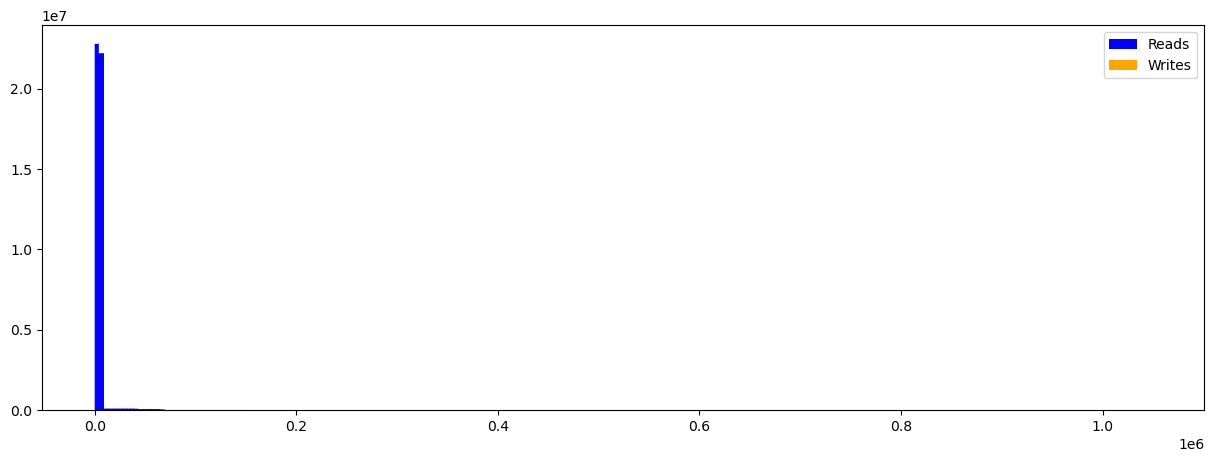

In [22]:
Graficar(Baseline_Acceses)


Gráficar

Accesos a la cache: durante el proceso de inferencia VBW

In [15]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/AlexNet_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)
##                           

ciclo de jecución de la red 

In [6]:

LI = [0,3,9,11,17,19,25,31,37,40,45,50]
AI = [2,8,10,16,18,24,30,36,38,44,49,53]
Buffer,ciclos =  buffer_simulation(AlexNet, test_dataset, integer_bits = 4, fractional_bits = 11, samples = 5, start_from = 0,
                                  bit_invertion = False, bit_shifting = False, CNN_gating = False,
                                  buffer_size = 1048576, write_mode ='default', save_results = False,
                                  results_dir = 'Data/Stats/AlexNet/Colorectal Dataset/CNN-Gated/',
                                  layer_indexes = LI , activation_indixes = AI)



buffer sections:  [0, 65536, 131072, 196608, 262144, 327680, 393216, 458752, 524288]
Simulation Started, time: 15:06:31 cycles:  0 offset:  0


CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

In [14]:
buffer

{'Number of Addresses': 290400,
 'Data': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'HighCyclesCount': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 'OffCyclesCount': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 'LowCyclesCount': array([4220838, 4220838, 4220838, ..., 4220838, 4220838, 4220838],
       dtype=uint32),
 'Flips': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 'offset': 0}

In [19]:
#ciclos

In [15]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\AlexNet\cycles')

1406946

In [3]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\AlexNet\PE_16_150\cycles')

211041900

In [5]:
211041900/1406946

150.0

# SqueezeNet

In [13]:

word_size  = 16
afrac_size = 9
aint_size  = 6
wfrac_size = 15
wint_size  = 0

trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)


# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'SqueezeNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:


activation_aging = [True]*22


#Acá la creamos, notese que como no se introduciran fallos en activaciones no es necesario pasar locs ni masks
SqueezeNet = GetNeuralNetworkModel('SqueezeNet', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
SqueezeNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
SqueezeNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
WeightQuantization(model=SqueezeNet, frac_bits=wfrac_size, int_bits=wint_size)
loss,acc =Net1.evaluate(test_dataset)

C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [18]:
#num_address= 801816

num_address  =1048576
samples      = 150
Indices = [0,3,7, 9,(13,14),20,(24,25),31,(35,36),42,44,(48,49),55,(59,60),66,(70,71),77,(81,82),88,90,(94,95),101,104]
Data    = GetReadAndWrites(SqueezeNet,Indices,num_address,samples,CNN_gating=False,network_name='SqueezeNet')
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(SqueezeNet,Indices,num_address,samples,CNN_gating=True,network_name='SqueezeNet')
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/SqueezeNet_reads_and_write_num_adress_total.xlsx') as writer:
       df_writes_Read.to_excel(writer, sheet_name='base', index=False)
##                           
#save_obj(Baseline_Acceses,'Data/Acceses/SqueezeNet/Baseline_v2')
#save_obj(CNN_gating_Acceses,'Data/Acceses/SqueezeNet/CNN_gating_Fix_v2')

procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150
procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150


NameError: name 'df_resumen_bit' is not defined

In [15]:
#Graficar(Baseline_Acceses)
Baseline_Acceses=load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\SqueezeNet\PE_16\Baseline_ya')


In [2]:
#plt.figure(figsize=(15, 5))
#plt.stackplot(Baseline_Acceses.to_dict()['index'].values(),
#              Baseline_Acceses.to_dict()['Lecturas'].values(),
#              Baseline_Acceses.to_dict()['Escrituras'].values(),
#              colors=['blue', 'orange'])
#plt.legend(['Reads','Writes'])

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/SqueezeNett_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)
##                           

ciclos

In [ ]:


LI = [0,3,7, 9,(13,14),20,(24,25),31,(35,36),42,44,(48,49),55,(59,60),66,(70,71),77,(81,82),88,90,(94,95),101,104]
AI = [2,6,8,12,     19,23,     30,34,     41,43,47,     54,58,     65,69,     76,80 ,    87,89,93,    100,103,107]
buffer_simulation(SqueezeNet,test_dataset, integer_bits = 6, fractional_bits = 9, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/SqueezeNet/Colorectal Dataset/CNN-Gated/Adjusted Buffer/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

In [13]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\SqueezeNet\PE_16\cycles')

218005350

In [2]:
218005350/150

1453369.0

# DenseNet

In [ ]:
trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)

word_size  = 16
afrac_size = 12
aint_size  = 3
wfrac_size = 13
wint_size  = 2

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'DenseNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:


activation_aging = [True]*188

DenseNet = GetNeuralNetworkModel('DenseNet', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size,
                                 batch_size = testBatchSize)
DenseNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
DenseNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

In [ ]:

num_address  =1048576
samples      = 150
Indices=[0,4,11,12,16,(22,11),25,29,(35,24),38,42,(48,37),51,55,(61,50),64,68,(74,63),77,81,(87,76),90,94,97,99,103,(109,97),
        112,116,(122,111),125,129,(135,124),138,142,(148,137),151,155,(161,150),164,168,(174,163),177,181,(187,176),
        190,194,(200,189),203,207,(213,202),216,220,(226,215),229,233,(239,228),242,246,(252,241),255,259,262,264,268,(274,262),
        277,281,(287,276),290,294,(300,289),303,307,(313,302),316,320,(326,315),329,333,(339,328),342,346,(352,341),
        355,359,(365,354),368,372,(378,367),381,385,(391,380),394,398,(404,393),407,411,(417,406),420,424,(430,419),
        433,437,(443,432),446,450,(456,445),459,463,(469,458),472,476,(482,471),485,489,(495,484),498,502,(508,497),
        511,515,(521,510),524,528,(534,523),537,541,(547,536),550,554,(560,549),563,567,(573,562),576,580,583,585,589,(595,583),
        598,602,(608,597),611,615,(621,610),624,628,(634,623),637,641,(647,636),650,654,(660,649),663,667,(673,662),
        676,680,(686,675),689,693,(699,688),702,706,(712,701),715,719,(725,714),728,732,(738,727),741,745,(751,740),
        754,758,(764,753),767,771,(777,765),780,784,(790,779),793,797,800]
Data     = GetReadAndWrites(DenseNet,Indices,num_address,samples,CNN_gating=False,network_name='DenseNet')
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data     = GetReadAndWrites(DenseNet,Indices,num_address,samples,CNN_gating=True,network_name='DenseNet')
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/DenseNet_reads_and_write_num_adress_total.xlsx') as writer:
        df_writes_Read.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/DenseNet_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

ciclos : analizar por qué start_fron esta en 137 correo con 0  aver que pasa

In [ ]:
LI = [0,4,11,12,16,     22,25,29,     35,38,42,     48,51,55,     61,64,68,     74,77,81,     87,90,94,97,99,103,      109,
     112,116,      122,125,129,      135,138,142,      148,151,155,      161,164,168,      174,177,181,      187,
     190,194,      200,203,207,      213,216,220,      226,229,233,      239,242,246,      252,255,259,262,264,268,      274,
     277,281,      287,290,294,      300,303,307,      313,316,320,      326,329,333,      339,342,346,      352,
     355,359,      365,368,372,      378,381,385,      391,394,398,      404,407,411,      417,420,424,      430,
     433,437,      443,446,450,      456,459,463,      469,472,476,      482,485,489,      495,498,502,      508,
     511,515,      521,524,528,      534,537,541,      547,550,554,      560,563,567,      573,576,580,583,585,589,      595,
     598,602,      608,611,615,      621,624,628,      634,637,641,      647,650,654,      660,663,667,      673,
     676,680,      686,689,693,      699,702,706,      712,715,719,      725,728,732,      738,741,745,      751,
     754,758,      764,767,771,      777,780,784,      790,793,797,800]
AI = [2,9,11,15,21,(23,11),28,34,(36,24),41,47,(49,37),54,60,(62,50),67,73,(75,63),80,86,(88,76),93,96,98,102,108,(110,98),
     115,121,(123,111),128,134,(136,124),141,147,(149,137),154,160,(162,150),167,173,(175,163),180,186,(188,176),
     193,199,(201,189),206,212,(214,202),219,225,(227,215),232,238,(240,228),245,251,(253,241),258,261,263,267,273,(275,263),
     280,286,(288,276),293,299,(301,289),306,312,(314,302),319,325,(327,315),332,338,(340,328),345,351,(353,341),
     358,364,(366,353),371,377,(379,367),384,390,(392,380),397,403,(405,393),410,416,(418,406),423,429,(431,419),
     436,442,(444,432),449,455,(457,445),462,468,(470,458),475,481,(483,471),488,494,(496,484),501,507,(509,497),
     514,520,(522,510),527,533,(535,523),540,546,(548,536),553,559,(561,549),566,572,(574,562),579,582,584,588,594,(596,584),
     601,607,(609,597),614,620,(622,610),627,633,(635,623),640,646,(648,636),653,659,(661,649),666,672,(674,662),
     679,685,(687,675),692,698,(700,688),705,711,(713,701),718,724,(726,714),731,737,(739,727),744,750,(752,740),
     757,763,(765,753),770,776,(778,766),783,789,(791,779),796,799,803]
Buffer,ciclos = buffer_simulation(DenseNet,test_dataset, integer_bits = 3, fractional_bits = 12, samples = 150, start_from = 137,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/DenseNet/Colorectal Dataset/CNN-Gated/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

In [10]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\DenseNet\PE_16_1imag\cycles')

6937351

# MobileNet

In [ ]:
trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)


# In[3]:


# Numero de bits para activaciones (a) y pesos (w)
word_size  = 16
afrac_size = 11
aint_size  = 4
wfrac_size = 14
wint_size  = 1

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'MobileNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:





In [ ]:
activation_aging = [True]*29
MobileNet = GetNeuralNetworkModel('MobileNet', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size,  batch_size = testBatchSize)
MobileNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
MobileNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
WeightQuantization(model=MobileNet, frac_bits=wfrac_size, int_bits=wint_size)
loss,acc  = MobileNet.evaluate(test_dataset)

In [ ]:
num_address  =1048576
samples      = 150
Indices = [0,4,10,16,23,29,35,41,48,54,60,66,73,79,85,91,97,103,109,115,121,127,133,139,146,152,158,164,170,175]
Data    = GetReadAndWrites(MobileNet,Indices,num_address,sample,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(MobileNet,Indices,num_address,samples,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/MobileNet_reads_and_write_num_adress_total.xlsx') as writer:
        df_writes_Read.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/MobileNet_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

ciclos analizar start_from = 128

In [ ]:
LI = [0,4,10,16,23,29,35,41,48,54,60,66,73,79,85,91,97,103,109,115,121,127,133,139,146,152,158,164,170,175]
AI = [2,9,15,21,28,34,40,46,53,59,65,71,78,84,90,96,102,108,114,120,126,132,138,144,151,157,163,169,173,179]
buffer_simulation(MobileNet,test_dataset, integer_bits = 4, fractional_bits = 11, samples = 150, start_from = 128,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/MobileNet/Colorectal Dataset/CNN-Gated/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

In [11]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\mobileNet\PE_16_1_imag\cycles')

1670088

# VGG16

In [ ]:
trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)


# In[3]:



word_size  = 16
afrac_size = 12
aint_size  = 3
wfrac_size = 15
wint_size  = 0

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'VGG16')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:


activation_aging = [True]*21

VGG16 = GetNeuralNetworkModel('VGG16', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
VGG16.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
VGG16.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
WeightQuantization(model=VGG16, frac_bits=wfrac_size, int_bits=wint_size)
loss,acc  = VGG16.evaluate(test_dataset)

In [ ]:
num_address  =1048576
samples      = 150
#num_address=802816
Indices = [0,3,7,11,13,17,21,23,27,31,35,37,41,45,49,51,55,59,63,66,70,74]
Data    = GetReadAndWrites(VGG16,Indices,num_address,samples,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(VGG16,Indices,num_address,samples,CNN_gating=True)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)

df_resumen_bit =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_resumen_bit.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
#print(df_resumen_bit)
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/VGG16_reads_and_write_num_adress_tota.xlsx') as writer:
        df_resumen_bit.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/VGG16_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

In [ ]:
LI = [0,3,7,11,13,17,21,23,27,31,35,37,41,45,49,51,55,59,63,66,70,74]
AI = [2,6,10,12,16,20,22,26,30,34,36,40,44,48,50,54,58,62,64,69,73,77]
buffer_simulation(VGG16,test_dataset, integer_bits = 3, fractional_bits = 12, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/VGG16/Colorectal Dataset/CNN-Gated/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

In [13]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\VGG16\PE_16_1_imag\cycles')

27160746

# ZFNet

In [ ]:
trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)



word_size  = 16
afrac_size = 11
aint_size  = 4
wfrac_size = 14
wint_size  = 1

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'ZFNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:


activation_aging = [True]*11

ZFNet = GetNeuralNetworkModel('ZFNet', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
ZFNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
ZFNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
WeightQuantization(model=ZFNet, frac_bits=wfrac_size, int_bits=wint_size)
loss,acc  = Net2.evaluate(test_dataset)

In [ ]:
num_address  =1048576
samples      = 150
Indices = [0,3,7,11,15,19,23,27,31,34,37,40]
Data    = GetReadAndWrites(ZFNet,Indices,num_address,samples,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(ZFNet,Indices,num_address,samples,CNN_gating=True)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Readt =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
#print(df_resumen_bit)
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/ZFNet_reads_and_write_num_adress_tota.xlsx') as writer:
        df_writes_Read.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/VGG16_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

ciclos

In [ ]:
LI = [0,3,7 ,11,15,19,23,27,31,34,37,40]
AI = [2,6,10,14,18,22,26,30,32,36,39,43]
buffer_simulation(ZFNett,testSet, integer_bits = 4, fractional_bits = 11, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/ZFNet/Colorectal Dataset/Baseline/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

# PiloNet

In [ ]:
trainBatchSize = testBatchSize = 1
_,_,test_dataset = GetPilotNetDataset(csv_dir='Data/Datos/driving_log.csv', train_batch_size=1, test_batch_size=1)



word_size  = 16
afrac_size = 15  
aint_size  = 0
wfrac_size = 15
wint_size  = 0

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'PilotNet')
wgt_dir = os.path.join(wgt_dir,'Weights')



# In[4]:


activation_aging = [True]*10

PilotNet = GetNeuralNetworkModel('PilotNet', (160,320,3), 1, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
PilotNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
PilotNet.compile(optimizer=optimizer, loss='mse')
WeightQuantization(model=PilotNet, frac_bits=wfrac_size, int_bits=wint_size)
loss  = PilotNet.evaluate(test_dataset)


In [ ]:
num_address  =1048576
samples      = 150
Indices = [5,6,10,14,18,22,28,32,36,40,44]
Data    = GetReadAndWrites(PilotNet,Indices,num_address,samples,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data   = GetReadAndWrites(PilotNet,Indices,num_address,samples,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/PilotNet_reads_and_write_num_adress_tota.xlsx') as writer:
        df_writes_Read.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/PilotNet_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

Ciclos

In [ ]:
LI = [5,6,10,14,18,22,28,32,36,40,44]
AI = [5,9,13,17,21,25,31,35,39,43,45]
buffer_simulation(PilotNet,testSet, integer_bits = 0, fractional_bits = 15, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/PilotNet/Steering Regression/Baseline/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

# Gráficos 

In [ ]:
# Lineas de los gráficos solo horizontales y a 0.5
#Los colores siempre los mismos para cada red(colocarlos los valores en variables)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py
l='0.5'
marksize=4



datos  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC')
ECC= datos.set_index("Voltajes")

ECC  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Acc_Sque" ])/0.930667 
#df= df.dropna()
Baseline=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Acc_Sque"])/0.930667


ECC_VGG  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Acc_VGG16" ])/0.805333316326141
#df= df.dropna()
Baseline_VGG=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Acc_VGG16"])/0.805333316326141

ECC_FZNet  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Acc_ZFNet" ])/0.833333313465118
#df= df.dropna()
Baseline_FZNet =pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Acc_ZFNet"])/0.833333313465118

ECC_ResNet  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Acc_ResNet" ])/0.8119999
#df= df.dropna()
Baseline_ResNet =pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Acc_ResNet"])/0.8119999465118


ECC_Inception  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Inception" ])/0.7879999876022339
#df= df.dropna()
Baseline_Inception=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Inception"])/0.7879999876022339

ECC_Xception  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Xception" ])/0.9039999842643738
#df= df.dropna()
Baseline_Xception=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Xception"])/0.9039999842643738



In [118]:
Baseline_Xception

,Xception
0,0.265487
1,0.685841
2,0.884956
3,0.880531
4,0.995575
5,1.000000
6,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

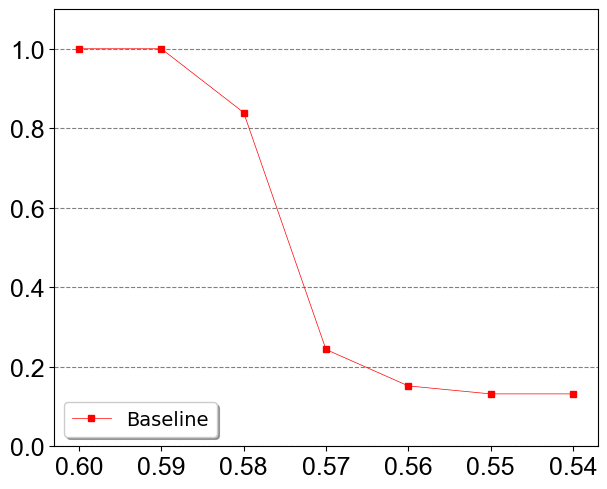

In [4]:
    from matplotlib.backends.backend_pdf import PdfPages, PdfFile

x=datos["Voltajes"]

# Graficar ejes con , en los numeros
#x_esp =['0,54','0,55','0,56','0,57','0,58','0,59','0,60']
x =['0.54','0.55','0.56','0.57','0.58','0.59','0.60']
#fig = plt.figure(figsize=(5,3), dpi=100)
#figsize=(7,3)

fig1, ax1 = plt.subplots(figsize=(6.2,5))
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
#plt.xlabel('Vdd', fontsize=12)

# Graficar ejes con , en los numeros
plt.xticks(x_values, x, fontsize=18, fontfamily="arial")
plt.yticks(fontsize=18, fontfamily="arial")

#fig2, ax2 = plt.subplots(figsize=(6.5,4))
##ax2= fig.add_subplot(1,3,2)
#x_values = range(len(x))
##plt.xlabel('Vdd',fontsize=12)
#plt.ylabel('Normalized accuracy', fontsize=12)
#plt.xticks(x_values, x)
#
#fig3, ax3 = plt.subplots(figsize=(6.5,4))
##ax3= fig.add_subplot(1,3,3)
#x_values = range(len(x))
#plt.xticks(x_values, x)
##plt.xlabel('Vdd', fontsize=12)
#plt.ylabel('Normalized accuracy', fontsize=12)
#
#fig4, ax4 = plt.subplots(figsize=(6.5,4))
##ax3= fig.add_subplot(1,3,3)
#x_values = range(len(x))
#plt.xticks(x_values, x)
##plt.xlabel('Vdd', fontsize=12)
#plt.ylabel('Normalized accuracy', fontsize=12)
#
#
#
#fig5, ax5 = plt.subplots(figsize=(6.5,4))
##ax3= fig.add_subplot(1,3,3)
#x_values = range(len(x))
#plt.xticks(x_values, x)
##plt.xlabel('Vdd', fontsize=12)
#plt.ylabel('Normalized accuracy', fontsize=12)
#
#fig6, ax6 = plt.subplots(figsize=(6.5,4))
##ax3= fig.add_subplot(1,3,3)
#x_values = range(len(x))
#plt.xticks(x_values, x)
##plt.xlabel('Vdd', fontsize=12)
#plt.ylabel('Normalized accuracy', fontsize=12)


ax1.set_ylim(0,1.1)
#plt.ylabel('Normalized accuracy', fontsize=16, fontfamily="arial")
#ax1.set_title(" ECC vs Baseline SqueezeNet")
ax1.invert_xaxis()
#ax1.set(xlabel=r'$V_{dd}$')
#ax1.set_yticklabels(['0,0', '0,2', '0,4', '0,6','0,8','1,0'])

#plt.ylabel('Normalized accuracy', fontsize=12)
#ax2.set_ylim(0,1.1)
##ax2.set_title(" ECC vs Baseline VGG16")
#ax2.invert_xaxis()
#ax2.set(xlabel=r'$V_{dd}$')
##
#plt.ylabel('Normalized accuracy', fontsize=12)
#ax3.set_ylim(0,1.1)
##ax3.set_title(" ECC vs Baseline ZFNet")
#ax3.invert_xaxis()
#ax3.set(xlabel=r'$V_{dd}$')
#
#ax4.set_ylim(0,1)
##ax3.set_title(" ECC vs Baseline ZFNet")
#ax4.invert_xaxis()
#ax4.set(xlabel=r'$V_{dd}$')
#
#ax5.set_ylim(0,1)
##ax3.set_title(" ECC vs Baseline ZFNet")
#ax5.invert_xaxis()
#ax5.set(xlabel=r'$V_{dd}$')
#
#ax6.set_ylim(0,1)
##ax3.set_title(" ECC vs Baseline ZFNet")
#ax6.invert_xaxis()
#ax6.set(xlabel=r'$V_{dd}$')
#
#
#ax1.plot(ECC["Acc_Sque"], label='ECC', color='b', ls='-', lw=l, marker='x', markersize=marksize, zorder=2)
#ax1.plot(df["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(Baseline["Acc_Sque"], label='Baseline', color="r", ls='-', lw=l, marker='s', markersize=marksize)
ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=14, loc ="lower left", shadow = True)



#ax2.plot(ECC_VGG["Acc_VGG16"], label='ECC', color='b', ls='-', lw=l, marker='x', markersize=marksize)
###ax2.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
#ax2.plot(Baseline_VGG["Acc_VGG16"], label='No ECC', color="r", ls='-', lw=l, marker='s', markersize=marksize)
#ax2.grid(axis='y', color = 'gray', linestyle = 'dashed')
#ax2.legend(fontsize=12, loc ="upper right", shadow = True)
##
##
#
#ax3.plot(ECC_FZNet["Acc_ZFNet"],label='ECC', color='b', ls='-', lw=l, marker='x', markersize=marksize)
###ax3.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
#ax3.plot(Baseline_FZNet["Acc_ZFNet"], label='No ECC', color="r", ls='-', lw=l, marker='s', markersize=marksize)
#ax3.grid(axis='y', color = 'gray', linestyle = 'dashed')
#ax3.legend(fontsize=12, loc ="lower left", shadow = True)
#
#ax4.plot(ECC_ResNet["Acc_ResNet"],label='ECC', color='c', ls='-', lw=l, marker='x', markersize=marksize)
###ax3.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
#ax4.plot(Baseline_ResNet["Acc_ResNet"], label='No ECC', color="r", ls='-', lw=l, marker='s', markersize=marksize)
#ax4.grid(axis='y', color = 'gray', linestyle = 'dashed')
#ax4.legend(fontsize=12, loc ="lower left", shadow = True)
#
#ax5.plot(ECC_Inception["Inception"],label='ECC', color='c', ls='-', lw=l, marker='x', markersize=marksize)
###ax3.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
#ax5.plot(Baseline_Inception["Inception"], label='No ECC', color="r", ls='-', lw=l, marker='s', markersize=marksize)
#ax5.grid(axis='y', color = 'gray', linestyle = 'dashed')
#ax5.legend(fontsize=12, loc ="lower left", shadow = True)
#
#ax6.plot(ECC_Xception["Xception"],label='ECC', color='c', ls='-', lw=l, marker='x', markersize=marksize)
###ax3.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
#ax6.plot(Baseline_Xception["Xception"], label='No ECC', color="r", ls='-', lw=l, marker='s', markersize=marksize)
#ax6.grid(axis='y', color = 'gray', linestyle = 'dashed')
#ax6.legend(fontsize=12, loc ="lower left", shadow = True)
#

#pdfFile=PdfPages("ECC vs Baseline SqueezeNet.pdf")
#pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()
#pdfFile=PdfPages("ECC vs Baseline VGG16.pdf")
#pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()
#pdfFile=PdfPages("ECC vs Baseline ZFNet.pdf")

#pdfFile=PdfPages("ECC vs Baseline Inception.pdf")
#pdfFile.savefig(fig5, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()
#pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.savefig("zque.TIFF", transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.tight_layout()



plt.show

#with slides.Presentation() as pres:
#    pres.save("scatter-chart.pptx", slides.export.SaveFormat.PPTX)


#pdfFile=PdfPages("ECC vs Baseline Xception.pdf")
#pdfFile.savefig(zque, transparent = True, bbox_inches = 'tight', pad_inches = 0)




In [12]:
pip install aspose.slides

     ---------------------------------------- 64.7/64.7 MB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Generar graficos: cantidad de fallos x bits (acumulado)

In [3]:
fallos_xbits =pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/cantidad_fallos_xbits.xlsx',sheet_name='fallosxbits')
bits= fallos_xbits.set_index("bits")
fail_xbits=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/cantidad_fallos_xbits.xlsx',sheet_name='fallosxbits', usecols=["Acum_Base","Acum_Volt" ])/10360


In [4]:
fail_xbits

,Acum_Base,Acum_Volt
0,0.038417,0.000000
1,0.107432,0.000290
2,0.189575,0.001158
3,0.265347,0.001544
4,0.316120,0.001931
5,0.383108,0.002799
6,0.429247,0.003282
7,0.500000,0.003958
8,0.538417,0.112452
9,0.607432,0.227124


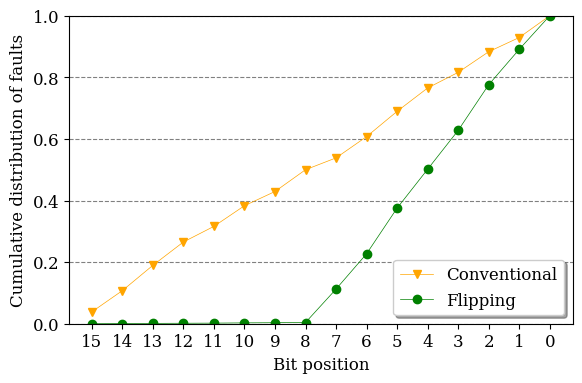

In [6]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import matplotlib as mpl  
mpl.rcParams['font.family']='serif'
l='0.5'
marksize=6
x=fallos_xbits["bits"]

plt.rcParams.update({'font.size': 12})
fig1, ax1 = plt.subplots(figsize=(6.5,4))

x_values = range(len(x))

plt.xlabel('Bit position', fontsize=12,  fontfamily="serif")
#plt.xlabel('Posición del bit', fontsize=12,  fontfamily="serif")
plt.ylabel('Cumulative distribution of faults', fontsize=12, fontfamily="serif")
plt.xticks(x_values, x)


ax1.set_ylim(0,1)
#ax1.set_title(" Accumulated bit errors")


ax1.plot(fail_xbits["Acum_Base"], label='Conventional', color="orange", ls='-', lw=l, marker='v', markersize=marksize, zorder=2)
ax1.plot(fail_xbits["Acum_Volt"], label='Flipping', color='g', ls='-', lw=l, marker='o', markersize=marksize, zorder=2)
#ax1.plot(df["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=12, loc ="lower right", shadow = True)

plt.savefig('Errores_bit_acumulados.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile=PdfPages("Accumulated_bit_errors.pdf")
#pdfFile=PdfPages("Errores_bit_acumulados.pdf")
#pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()





In [120]:

datos  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos los voltajes_y redes.xlsx',sheet_name='poster_women')
tabla= datos.set_index("Voltajes")


tabla
df_tabla = pd.DataFrame(tabla)
df_tabla

,ECC,No ECC,% Fallos,Unnamed: 4,1048576,Faults
Voltajes,,,,,,
0.54,0.170667,0.122667,1.259232,NaN,1048576.0,13204
0.55,0.230667,0.122667,0.393295,NaN,NaN,4124
0.56,0.421333,0.141333,0.149727,NaN,NaN,1570
0.57,0.806667,0.226667,0.040627,NaN,NaN,426
0.58,0.930667,0.781333,0.008583,NaN,NaN,90
0.59,0.930667,0.930667,0.001717,NaN,NaN,18
0.60,0.930667,0.930667,0.000191,NaN,NaN,2


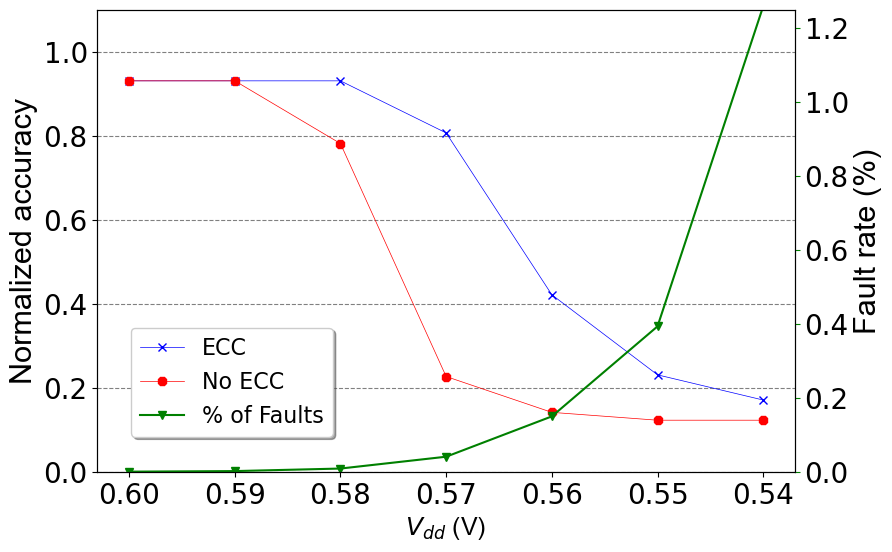

<Figure size 640x480 with 0 Axes>

In [139]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MultipleLocator

#from datetime import datetime
import time

plt.rcParams.update({'font.size': 20})



l='0.5'
marksize=6

x=datos["Voltajes"]


fig1, ax1 = plt.subplots(figsize=(9,6))

#fig1 = plt.figure()
ax2 = ax1.twinx()




#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))

plt.xlabel("$V_{dd}$ (V)", fontsize=22,  fontfamily="arial")
#plt.ylabel('Normalized accuracy', fontsize=12,  fontfamily="serif")

#ax1.yaxis.set_label_position("left")
#ax1.yaxis.tick_left()
#ax2.yaxis.set_label_position("right")
ax1.set_ylabel('Normalized accuracy', fontsize=22,  fontfamily="arial")
ax2.set_ylabel('Fault rate (%)', fontsize=22,  fontfamily="arial")
#ax2.yaxis.tick_right()


ax1.set_xticks([0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60],fontsize= 22,fontfamily="arial") 

#ax2.set_xticks([6.9,1.12,0.30,0.10,0.03,0.005,0.0005,0.0001]) 

#ax1.tick_params(axis="x",labelsize=22,fontfamily="arial") 
#plt.xticks(x, tabla.index, fontsize= 22, fontfamily="arial" )
#plt.yticks( fontsize= 22, fontfamily="arial" )
ax1.set_ylabel('Normalized accuracy', fontsize=22,  fontfamily="arial")
ax1.set_xlabel("$V_{dd}$ (V)", fontsize=18,  fontfamily="arial")
ax2.set_ylim(0,  1.25)
ax1.set_ylim(0,1.1)
#ax1.set_title(" ECC vs Baseline SqueezeNet")
ax1.invert_xaxis()


ax1.plot(tabla["ECC"], label='ECC', color='b', ls='-', lw=l, marker='x', markersize=marksize)
ax1.plot(tabla["No ECC"], label='No ECC', color='r', ls='-', lw=l, marker='8', markersize=marksize)
ax2.plot(tabla["% Fallos"] ,label='% of Faults', color='g', ls='-',marker='v', markersize=marksize)
#ax1.plot(tabla["FlipPatch_0.53"], label='FlipPatch 0.53 V', color="b", ls='-', lw=l, marker='x', markersize=marksize)
#ax1.plot(tabla["FlipPatch_0.54"], label='FlipPatch 0.54 V', color="r", ls='-', lw=l, marker='8', markersize=marksize)
#ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
#ax1.grid(axis='x', color = 'gray', linestyle = 'dashed')

ax1.yaxis.grid(color='gray', linestyle='dashed')
#ax2.yaxis.grid(color='g', linestyle='dashed')



ax2.tick_params(axis='y', color='g')



fig1.legend(fontsize=16,bbox_to_anchor=(0.15,0.15),loc ="lower left", shadow = True)







plt.savefig('Acc_by_fault_rate_post.TIF', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#
plt.tight_layout()



In [3]:
errores_voltaje =pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='Hoja2', usecols=["Voltajes","Errores" ])
errores_voltaje_= errores_voltaje.set_index("Voltajes")
errores_voltaje_

,Errores
Voltajes,
0.54,13204
0.55,4124
0.56,1570
0.57,426
0.58,90
0.59,18
0.60,2


range(0, 7)


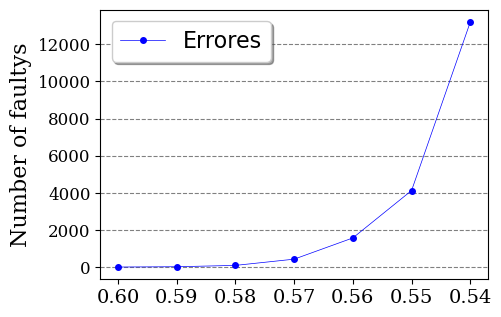

In [65]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
l='0.5'
marksize=4
#x=errores_voltaje["Voltajes"]
x =['0.54','0.55','0.56','0.57','0.58','0.59','0.60']
fallos_xbits= ['2','18', '90','426','1570','4124','13204']

fig1, ax1 = plt.subplots(figsize=(5,3.5))
fig1, ax1 = plt.subplots(figsize=(5,3.5))

x_values = range(len(x))
print(x_values)
y_values = range(len(fallos_xbits))
#print(y_values)

#plt.xlabel('Voltajes', fontsize=16,  fontfamily="serif")
plt.ylabel('Number of faultys', fontsize=16, fontfamily="serif")
plt.xticks(x_values, x,fontsize=14,  fontfamily="serif")
#plt.yticks(np.arange(0,14000, step=8), ('0','2','18', '90','426','1570','4124','13204'))
plt.yticks( fontsize=14,  fontfamily="serif")
ax1.invert_xaxis()

#plt.yticks(y_values,fallos_xbits)


#ax1.set_ylim(0,14000)
#ax1.set_title(" Accumulated bit errors")

ax1.plot(errores_voltaje["Errores"], label='Errores', color='b', ls='-', lw=l, marker='o', markersize=marksize, zorder=2)
#ax1.plot(df["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
#ax1.plot(fail_xbits["Acum_Base"], label='Conventional', color="orange", ls='-', lw=l, marker='s', markersize=marksize, zorder=2)
ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=16, loc ="best", shadow = True)

#ax1.set(xlabel=r'$V_{dd}$')
plt.savefig("error_by_volts.png", transparent = True, bbox_inches = 'tight', pad_inches = 0)





In [11]:
acc_correc_bits=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/cantidad_fallos_xbits.xlsx',sheet_name='acc_correct_bit_to_bit', usecols=["bits","Acc_Alex","Acc_Sque", "Acc_Dense" , "Acc_Mobile","Acc_VGG16", "Acc_ZFNet"])
bits= acc_correc_bits.set_index("bits")

In [12]:
bits

,Acc_Alex,Acc_Sque,Acc_Dense,Acc_Mobile,Acc_VGG16,Acc_ZFNet
bits,,,,,,
15,0.446667,0.122667,0.668000,0.122667,0.117333,0.117333
14,0.713333,0.122667,0.892000,0.202667,0.117333,0.122667
13,0.864000,0.122667,0.917333,0.425333,0.174667,0.452000
12,0.889333,0.126667,0.917333,0.685333,0.257333,0.620000
11,0.892000,0.374667,0.914667,0.729333,0.544000,0.704000
10,0.892000,0.722667,0.917333,0.873333,0.788000,0.822667
9,0.890667,0.888000,0.917333,0.874667,0.798667,0.830667
8,0.890667,0.928000,0.916000,0.880000,0.804000,0.830667
7,0.890667,0.932000,0.916000,0.878667,0.806667,0.829333


<Figure size 2000x500 with 0 Axes>

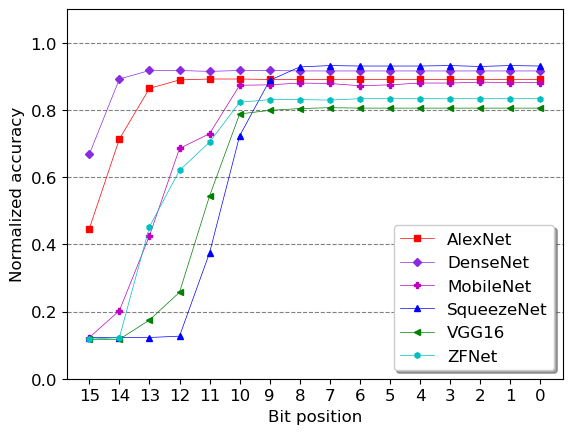

In [13]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile

l='0.5'
marksize=4

x=acc_correc_bits["bits"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 12})
fig1, ax1 = plt.subplots()

x_values = range(len(x))

plt.xlabel('Bit position', fontsize=12)
plt.ylabel('Normalized accuracy', fontsize=12)
plt.xticks(x_values, x)


ax1.set_ylim(0,1.1)
#ax1.set_title("  bit ")

ax1.plot(acc_correc_bits["Acc_Alex"], label='AlexNet', color='r', ls='-', lw=l, marker='s', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Dense"], label='DenseNet', color="blueviolet", ls='-', lw=l, marker='D', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Mobile"], label='MobileNet', color="m", ls='-', lw=l, marker='P', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Sque"], label='SqueezeNet', color="b", ls='-', lw=l, marker='^', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_VGG16"], label='VGG16', color="g", ls='-', lw=l, marker='<', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_ZFNet"], label='ZFNet', color="c", ls='-', lw=l, marker='h', markersize=marksize)
ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=12, loc ="lower right", shadow = True)

pdfFile=PdfPages("Correction bit_to_bit_new.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
#



In [5]:
import pandas as pd
acc_low_and_high_VBW_error=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='graficar_english',usecols=["Mask", "L&HO","HO","LO"] )
acc_low_and_high_VBW_error= acc_low_and_high_VBW_error.set_index("Mask")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [6]:
acc_low_and_high_VBW_error

,LO,L&HO,HO
Mask,,,
Alex,1.000000,1.000000,0.500000
Dense,1.002956,1.001496,0.722654
Mobile,0.996974,0.993949,0.142209
Squeeze,0.997135,0.471347,0.131805
VGG,0.998344,0.632450,0.145695
ZF,0.996800,0.848000,0.140800
Avg,0.998702,0.824540,0.297194


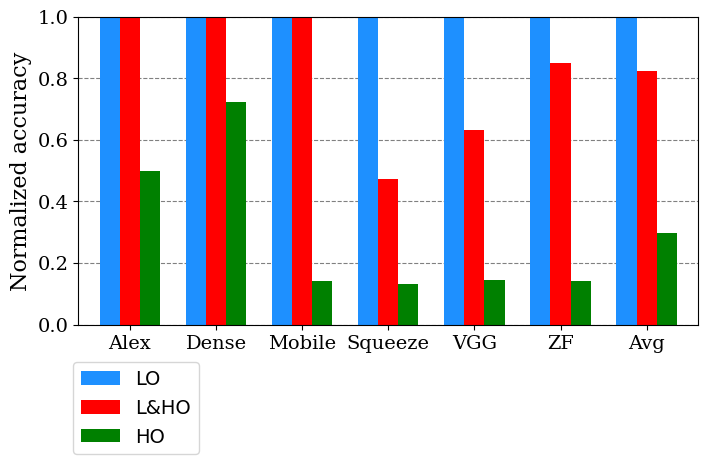

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(acc_low_and_high_VBW_error.index)
#acc=['0,0', '0,2', '0,4', '0,6','0,8','1,0']
#fig1, ax1 = plt.subplots(figsize=(6.5,4))
 
x = np.arange(n)
y = np.linspace(0,1,6)
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red', 'green','c']
#fig = plt.figure(figsize=(10,5), dpi=100)
#plt.yticks([y,acc])

#ax1.plot(acc_low_and_high_VBW_error,kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,3.5), zorder=2)
acc_low_and_high_VBW_error.plot(kind ='bar', width = 0.70, fontsize=14, color = coloresRedes, figsize=(8,4), zorder=2)
#plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
#plt.yticks('')
#Colocar los valores del eje con , en lugar d epunto
#plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.ylabel('Normalized accuracy', fontsize=16, fontfamily="serif")
plt.xticks(x, acc_low_and_high_VBW_error.index, fontsize= 14, fontfamily="serif" )
plt.yticks( fontsize= 14, fontfamily="serif" )
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
#plt.xlabel('', fontsize=12)
plt.xlabel('', fontsize=16)
plt.legend(fontsize=14, bbox_to_anchor=(0.21,-0.09), shadow = False)
plt.savefig('acc_error_LO_HO_VBW_HO.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.savefig('acc_error_PB_PA_VBW_.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.show()



## Para power point

In [105]:
import pandas as pd
acc_low_and_high_VBW_error=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='graficar_english',usecols=["Mask", "L&HO","HO","LO"] )
acc_low_and_high_VBW_error= acc_low_and_high_VBW_error.set_index("Mask")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


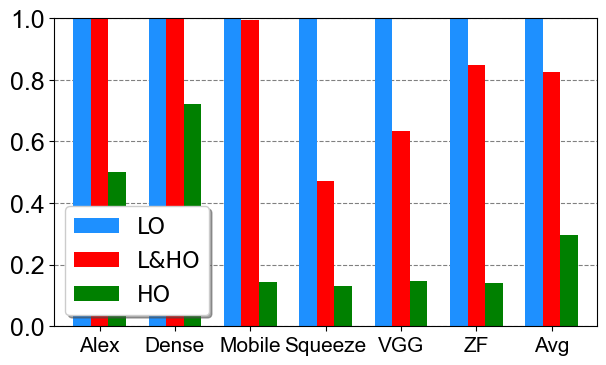

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(acc_low_and_high_VBW_error.index)
#acc=['0,0', '0,2', '0,4', '0,6','0,8','1,0']
#fig1, ax1 = plt.subplots(figsize=(7,))
 
x = np.arange(n)
y = np.linspace(0,1,6)
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red', 'green','c']
#fig = plt.figure(figsize=(10,5), dpi=100)
#plt.yticks([y,acc])

#ax1.plot(acc_low_and_high_VBW_error,kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,3.5), zorder=2)
acc_low_and_high_VBW_error.plot(kind ='bar', width = 0.70,  color = coloresRedes, figsize=(7,4), zorder=2)
#plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
#plt.yticks('')
#Colocar los valores del eje con , en lugar d epunto
#plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
#plt.ylabel('Normalized accuracy', fontsize=20, fontfamily="arial")
plt.xticks(x, acc_low_and_high_VBW_error.index, fontsize= 15, fontfamily="arial" )
plt.yticks( fontsize= 18, fontfamily="arial" )
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
#plt.xlabel('', fontsize=12)
plt.xlabel('')
plt.legend(fontsize=16, shadow = True,loc ="lower left")
plt.savefig('acc_error_LO_HO_VBW_HO_poster.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.savefig('acc_error_PB_PA_VBW_.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.show()



# jornadas women encourge

In [95]:
import pandas as pd
acc_low_and_high_VBW_error=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='graficar_english',usecols=["Mask", "L&HO","HO","LO"] )
acc_low_and_high_VBW_error= acc_low_and_high_VBW_error.set_index("Mask")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [98]:
acc_low_and_high_VBW_error

,LO,L&HO,HO
Mask,,,
Alex,1.000000,1.000000,0.500000
Dense,1.002956,1.001496,0.722654
Mobile,0.996974,0.993949,0.142209
Squeeze,0.997135,0.471347,0.131805
VGG,0.998344,0.632450,0.145695
ZF,0.996800,0.848000,0.140800
Avg,0.998702,0.824540,0.297194


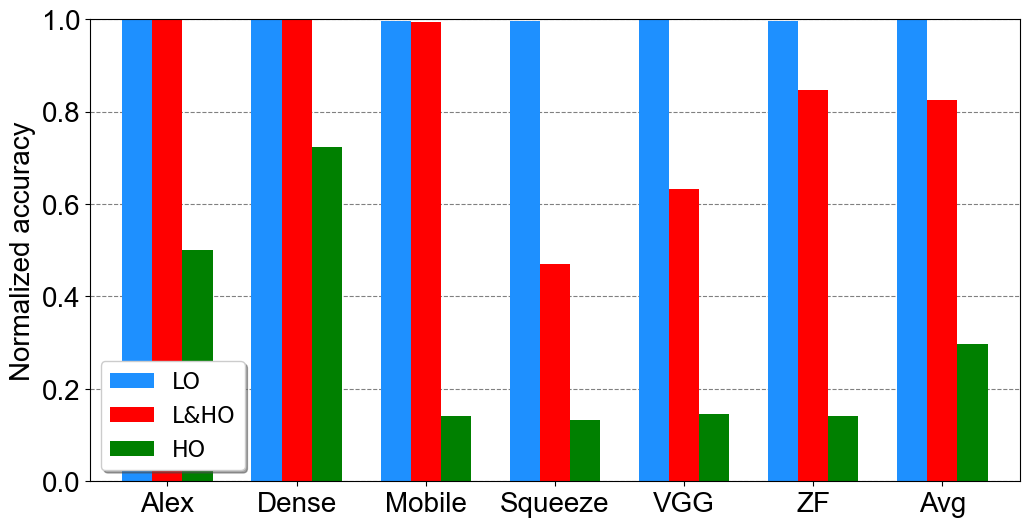

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(acc_low_and_high_VBW_error.index)
#acc=['0,0', '0,2', '0,4', '0,6','0,8','1,0']
#fig1, ax1 = plt.subplots(figsize=(7,))
 
#x = np.arange(n)

y = np.linspace(0,1,6)
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red', 'green','c']
#fig = plt.figure(figsize=(10,5), dpi=100)
#plt.yticks([y,acc])

#ax1.plot(acc_low_and_high_VBW_error,kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,3.5), zorder=2)
acc_low_and_high_VBW_error.plot(kind ='bar', width = 0.70,  color = coloresRedes, figsize=(12,6), zorder=2)
#plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
#plt.yticks('')
#Colocar los valores del eje con , en lugar d epunto
#plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.ylabel('Normalized accuracy', fontsize=20, fontfamily="arial")
plt.xticks(x, acc_low_and_high_VBW_error.index, fontsize= 20, fontfamily="arial" )
plt.yticks( fontsize= 20, fontfamily="arial" )
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
#plt.xlabel('', fontsize=12)
plt.xlabel('')
plt.legend(fontsize=16, shadow = True,loc ="lower left")
#lt.legend(fontsize=16, bbox_to_anchor=(0.21,-0.09), shadow = False)
plt.savefig('acc_error_LO_HO_VBW_HO_sarteco.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.savefig('acc_error_PB_PA_VBW_.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.show()

In [48]:
import pandas as pd

acc_low_and_high_056=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='56vol',usecols=["Mask", "L&HO","HO","LO"] )
acc_low_and_high_056= acc_low_and_high_056.set_index("Mask")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


acc_low_and_high_058=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='58vol',usecols=["Mask", "L&HO","HO","LO"] )
#acc_low_and_high_058= acc_low_and_high_056.set_index("Mask")
acc_low_and_high_058

,Mask,LO,L&HO,HO
0,Alex,1.000000,1.000000,1.000000
1,Dense,1.002956,1.002956,1.002956
2,Mobile,1.001513,1.000000,0.996974
3,ResNet,NaN,NaN,NaN
4,Squeeze,1.000000,1.000000,0.839542
5,VGG,1.000000,1.000000,0.842715
6,ZF,1.000000,1.000000,0.856000
7,Avg,1.000745,1.000493,0.923031


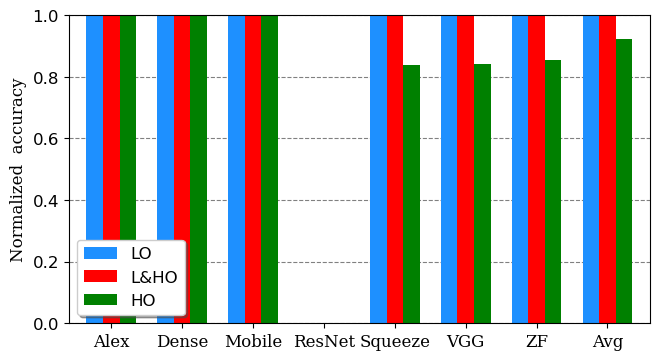

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(acc_low_and_high_056.index)
#acc=['0,0', '0,2', '0,4', '0,6','0,8','1,0']
#fig1, ax1 = plt.subplots(figsize=(6.5,4))
 
x = np.arange(n)
y = np.linspace(0,1,6)
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red', 'green','c']
#fig = plt.figure(figsize=(10,5), dpi=100)
#plt.yticks([y,acc])

##ax1.plot(acc_low_and_high_VBW_error,kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2)
#acc_low_and_high_056.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(7.5,4), zorder=2)
#plt.ylabel('Normalized  accuracy', fontsize=12, fontfamily="serif")
#plt.xticks(x, acc_low_and_high_056.index, fontsize= 12, fontfamily="serif" )
#plt.xticks(rotation = 0)
#plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
##plt.xlabel('', fontsize=12)
#plt.xlabel('', fontsize=12)
#plt.legend(fontsize=12, loc ="lower left", shadow = True)
#plt.ylim(0,1)

acc_low_and_high_058.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(7.5,4), zorder=2)
plt.ylabel('Normalized  accuracy', fontsize=12, fontfamily="serif")
plt.xticks(x, acc_low_and_high_056.index, fontsize= 12, fontfamily="serif" )
#plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
#plt.yticks('')
#Colocar los valores del eje con , en lugar d epunto
#plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))

#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
#plt.xlabel('', fontsize=12)
plt.xlabel('', fontsize=12)
plt.legend(fontsize=12, loc ="lower left", shadow = True)
#plt.savefig('acc_low_and_high_056.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.savefig('acc_low_and_high_058.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.savefig('acc_error_PB_PA_VBW_.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.show()

In [114]:
acc_low_and_high_volts=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/Analisis_LO_HO_and_both/analize_by_parts_v2.xlsx',sheet_name='Hoja2')
acc_low_and_high_volts= acc_low_and_high_volts.set_index("Tecnic")

In [84]:
#Rectificar para ResNet si lo hice o no

In [115]:
acc_low_and_high_volts

,Redes,0.54,0.56,0.58
Tecnic,,,,
LO,Alex,1.000000,1.000000,1.000000
L&HO,NaN,1.000000,1.000000,1.000000
HO,NaN,0.500000,0.844311,1.000000
LO,Dense,1.000000,1.000000,1.000000
L&HO,NaN,0.998544,1.000000,1.000000
HO,NaN,0.720524,1.000000,1.000000
LO,Inception,0.984375,1.015625,0.989583
L&HO,NaN,0.807292,1.000000,1.000000
HO,NaN,0.171875,0.171875,1.041667


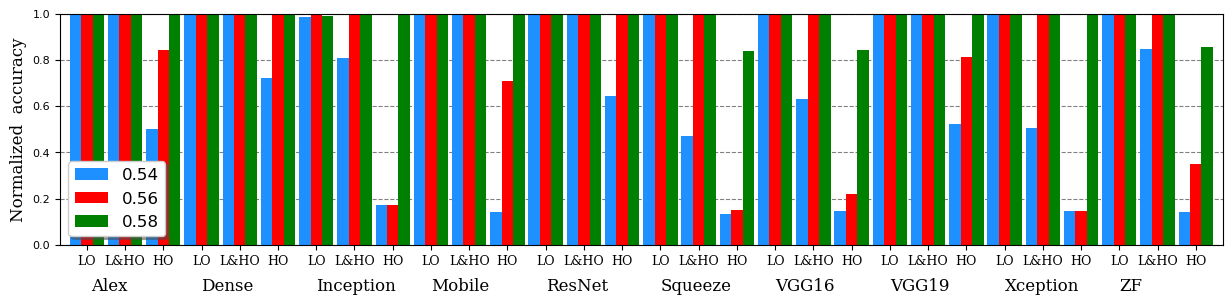

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(acc_low_and_high_volts.index)
#acc=['0,0', '0,2', '0,4', '0,6','0,8','1,0']
#fig1, ax1 = plt.subplots(figsize=(6.5,4))
usecols=["0.54","0.56","0.58"]
x = np.arange(n)
y = np.linspace(0,1,6)
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red', 'green','c']
#fig = plt.figure(figsize=(10,5), dpi=100)
#plt.yticks([y,acc])

##ax1.plot(acc_low_and_high_VBW_error,kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2)
#acc_low_and_high_056.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(7.5,4), zorder=2)
#plt.ylabel('Normalized  accuracy', fontsize=12, fontfamily="serif")
#plt.xticks(x, acc_low_and_high_056.index, fontsize= 12, fontfamily="serif" )
#plt.xticks(rotation = 0)
#plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
##plt.xlabel('', fontsize=12)
#plt.xlabel('', fontsize=12)
#plt.legend(fontsize=12, loc ="lower left", shadow = True)
#plt.ylim(0,1)



acc_low_and_high_volts.plot(kind ='bar',width = 0.9, fontsize=8, color = coloresRedes, figsize=(15,3), 
                            zorder=2)
plt.ylabel('Normalized  accuracy', fontsize=12, fontfamily="serif")
plt.xticks(x, acc_low_and_high_volts.index, fontsize= 12, fontfamily="serif" )
#plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
#plt.yticks('')
#Colocar los valores del eje con , en lugar d epunto
#plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))

#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0, fontsize=9)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
#plt.xlabel('', fontsize=12)
plt.xlabel('')
plt.legend(fontsize=12, loc ="lower left", shadow = True)
plt.text(0.10, -0.2, 'Alex', fontsize=12, fontfamily="serif")
plt.text(3, -0.2, 'Dense', fontsize=12, fontfamily="serif")
plt.text(6, -0.2, 'Inception', fontsize=12, fontfamily="serif")
plt.text(9, -0.2, 'Mobile', fontsize=12, fontfamily="serif")
plt.text(12, -0.2, 'ResNet', fontsize=12, fontfamily="serif")
plt.text(15,-0.2, 'Squeeze', fontsize=12, fontfamily="serif")
plt.text(18, -0.2, 'VGG16', fontsize=12, fontfamily="serif")
plt.text(21, -0.2, 'VGG19', fontsize=12, fontfamily="serif")
plt.text(24, -0.2,'Xception' , fontsize=12, fontfamily="serif")
plt.text(27, -0.2, 'ZF', fontsize=12, fontfamily="serif")

#plt.text(12, -0.4, 'Avg', fontsize=12, fontfamily="serif")
#plt.text(12, -0.15, 'Avg', fontsize=12, fontfamily="serif")
#plt.savefig('acc_low_and_high_056.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.savefig('acc_low_and_high_volts.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.savefig('acc_low_and_high_and_both_bar.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.show()

In [31]:
import pandas as pd
Error_by_layer=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/Analisis_LO_HO_and_both/Error_by_layer_redes.xlsx',sheet_name='Hoja1',usecols=["Redes", "L&HO","HO","LO"] )
Error_by_layer= Error_by_layer.set_index("Redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])
Error_by_layer

,LO,HO,L&HO
Redes,,,
Alex,2852.000000,2852.000000,6.000000
Dense,61022.000000,61022.000000,290.000000
Mobile,20321.000000,20321.000000,97.000000
ResNet,NaN,NaN,NaN
Squeeze,20265.000000,20265.000000,116.000000
Sentimen,NaN,NaN,NaN
VGG,43226.000000,43226.000000,340.000000
ZF,7421.000000,7421.000000,43.000000
Avg,25851.166667,25851.166667,148.666667


<Figure size 500x500 with 0 Axes>

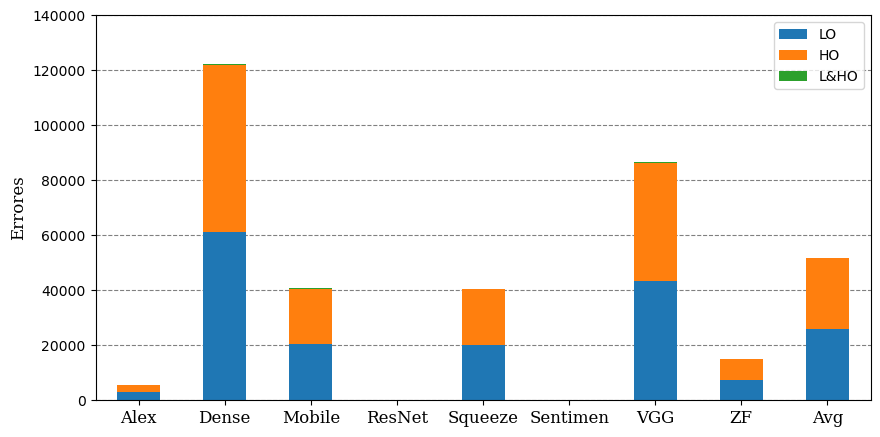

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n = len(Error_by_layer.index)
fig = plt.figure(figsize=(5,5), dpi=100)


#plt.yticks('')
x = np.arange(n)

Error_by_layer.plot( kind='bar', stacked=True, figsize=(10,5), zorder=2 )
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') 
#plt.xticks(fontsize= 12, fontfamily="serif" )
plt.ylim(0,140000)
plt.xticks(rotation = 0)
plt.xticks(x, Error_by_layer.index, fontsize= 12, fontfamily="serif" )
plt.xlabel('')
plt.ylabel('Errores', fontsize=12, fontfamily="serif")
plt.savefig('Error_by_layer.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)




In [ ]:
import pandas as pd
acc_low_and_high_VBW_error=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/High_order_greater_2.xlsx',sheet_name='fichero_707',usecols=["Mask", "PB&A","PA","PB"] )
acc_low_and_high_VBW_error= acc_low_and_high_VBW_error.set_index("Mask")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(acc_low_and_high_VBW_error.index)
acc=['0,0', '0,2', '0,4', '0,6','0,8','1,0']
#fig1, ax1 = plt.subplots(figsize=(6.5,4))
 
x = np.arange(n)
y = np.linspace(0,1,6)
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red', 'green']
#fig = plt.figure(figsize=(10,5), dpi=100)
#plt.yticks([y,acc])

#ax1.plot(acc_low_and_high_VBW_error,kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2)
acc_low_and_high_VBW_error.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(7.5,4), zorder=2);plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
#plt.yticks('')
plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.ylabel('Normalized accuracy', fontsize=12, fontfamily="serif")
plt.xticks(x, acc_low_and_high_VBW_error.index, fontsize= 12, fontfamily="serif" )
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
#plt.xlabel('', fontsize=12)
plt.xlabel('', fontsize=12)

plt.savefig('acc_error_PB_PA_VBW.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()


In [3]:
import pandas as pd
Tipos_errores=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='errores_poster')
Tipos_errores= Tipos_errores.set_index("Vol")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])
Tipos_errores

,LO,L&HO,HO
Vol,,,
0.54,4701,37,4701
0.55,1592,7,1592
0.56,562,2,562
0.57,168,1,168
0.58,28,0,28
0.59,3,0,3
0.60,1,0,1


### Máscra base

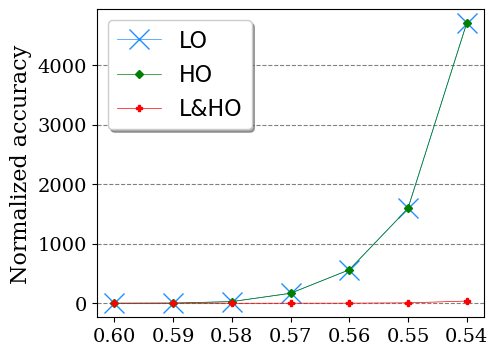

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Tipos_errores.index)

l='0.5'
marksize=4 
x = np.arange(n)


fig1, ax1 = plt.subplots(figsize=(5,4))
#plt.rcParams.update({'font.size': 12})
#fig1, ax1 = plt.subplots()


x_values = range(len(x))
#coloresRedes = [ 'lightskyblue', 'dodgerblue','cornflowerblue','blue', 'navy']
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red', 'green','c']
#fig = plt.figure(figsize=(10,5), dpi=100)

ax1.plot(Tipos_errores["LO"], label='LO', color='dodgerblue', ls='-', lw=l, marker='x', markersize=15)
ax1.plot(Tipos_errores["HO"], label='HO', color="green", ls='-', lw=l, marker='D', markersize=marksize)
ax1.plot(Tipos_errores["L&HO"], label='L&HO', color="red", ls='-', lw=l, marker='P', markersize=marksize)
#Tipos_errores.plot( fontsize=12,figsize=(4,4), color = coloresRedes, zorder=2  )
#plt.pie(anais_Tipos_errores, labels=nombres)
plt.ylabel('Normalized accuracy', fontsize=16, fontfamily="serif")
#plt.ylabel('Number of faultys', fontsize=18, fontfamily="serif")
plt.xticks( fontsize= 14, fontfamily="serif" )
plt.yticks( fontsize= 14, fontfamily="serif" )
ax1.legend(fontsize=16, loc ="best", shadow = True)
ax1.invert_xaxis()
plt.xticks(rotation = 0)

plt.grid(axis='y', color = 'gray', linestyle = 'dashed')


#xlabel('')

plt.savefig('number_faults_poster.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
from matplotlib.ticker import MultipleLocator

#from datetime import datetime
import time
mpl.rcParams['font.family']='serif'



l='0.5'
marksize=6

x=datos["Voltajes"]
y1 = 0.05 * x**2
y2 = 1 *y1

fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 15})
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()




#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))

plt.xlabel("$V_{dd}$ (V)", fontsize=12,  fontfamily="serif")
#plt.ylabel('Normalized accuracy', fontsize=12,  fontfamily="serif")

#ax1.yaxis.set_label_position("left")
#ax1.yaxis.tick_left()
#ax2.yaxis.set_label_position("right")
ax1.set_ylabel('Normalized accuracy', fontsize=12,  fontfamily="serif")
ax2.set_ylabel('Fault rate (%)', fontsize=12,  fontfamily="serif")
#ax2.yaxis.tick_right()


ax1.set_xticks([0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60],labelsize=12,fontfamily="serif") 
#ax2.set_xticks([6.9,1.12,0.30,0.10,0.03,0.005,0.0005,0.0001]) 

#ax1.tick_params(axis="x",labelsize=12,fontfamily="serif") 
#plt.xticks(x, tabla.index, fontsize= 12, fontfamily="serif" )
plt.yticks( fontsize= 12, fontfamily="serif" )
ax2.set_ylim(0,  7.1)
ax1.set_ylim(0,1.1)
#ax1.set_title(" ECC vs Baseline SqueezeNet")
ax1.invert_xaxis()


ax1.plot(tabla["E"], label='ECC', color='b', ls='-', lw=l, marker='x', markersize=marksize)
ax1.plot(tabla["FlipPatch"], label='Flip-and-Patch', color='r', ls='-', lw=l, marker='8', markersize=marksize)
ax2.plot(tabla["% Fallos"] ,label='% of Faults', color='g', ls='-',marker='v', markersize=marksize)
#ax1.plot(tabla["FlipPatch_0.53"], label='FlipPatch 0.53 V', color="b", ls='-', lw=l, marker='x', markersize=marksize)
#ax1.plot(tabla["FlipPatch_0.54"], label='FlipPatch 0.54 V', color="r", ls='-', lw=l, marker='8', markersize=marksize)
#ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
#ax1.grid(axis='x', color = 'gray', linestyle = 'dashed')

ax1.yaxis.grid(color='gray', linestyle='dashed')
#ax2.yaxis.grid(color='g', linestyle='dashed')



ax2.tick_params(axis='y', color='g')



fig1.legend(fontsize=12,bbox_to_anchor=(0.15,0.15),loc ="lower left", shadow = True)




#plt.text(1, 1, 'alexnet', fontsize=13.5, fontfamily="serif")
#ax1.text(-2.90, -0.24, '0,0005', fontsize=13.5, fontfamily="serif")
#ax1.text(5.8, -0.24, '0,005', fontsize=13.5, fontfamily="serif")
#plt.text(8.6,-0.24, '0,032', fontsize=13.5, fontfamily="serif")
#plt.text(12.2, -0.24, '0,30', fontsize=13.5, fontfamily="serif")
#plt.text(15.45, -0.24, '1,12', fontsize=13.5, fontfamily="serif")
#plt.text(18.2, -0.24, '6,9', fontsize=13.5, fontfamily="serif")
#
#plt.legend(  fontsize=11, bbox_to_anchor=(0.653,0.2),shadow = True)
#prop={'size':15}



plt.savefig('Acc_by_fault_rate.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#
plt.tight_layout()





plt.show

In [137]:
import pandas as pd
Resumen_x2_x3_4_esp=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_base_esp',usecols=["redes","Base","I-A ECC", "ECC","Flip","F + P"] )
Resumen_x2_x3_4_es= Resumen_x2_x3_4_esp.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [74]:
Resumen_x2_x3_4_es

,Base,I-A ECC,ECC,Flip,F + P
redes,,,,,
Alex,0.499981,0.582314,0.836795,0.999963,0.999963
Dense,0.722654,0.779591,0.997117,1.001496,1.002956
Mobile,0.141892,0.141892,0.608325,0.996264,0.990226
Squeeze,0.131800,0.131800,0.183375,0.792235,0.989936
VGG,0.145701,0.145701,0.145701,0.771555,0.996730
ZF,0.140806,0.140806,0.352014,0.846434,0.996840
Avg,0.297139,0.320351,0.520554,0.901325,0.996108


<Figure size 2000x500 with 0 Axes>

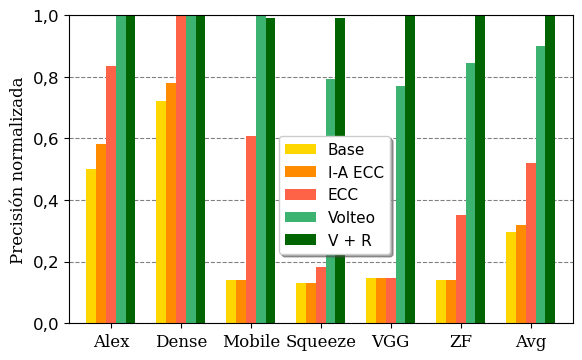

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_x2_x3_4_es.index)

 
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_x2_x3_4_es.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2 );
#plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.55), shadow = True)
plt.legend(  fontsize=11, bbox_to_anchor=(0.653,0.2),shadow = True)
plt.ylim(0,1.0)
#plt.ylabel('Precisión normalizada', fontsize=12, fontfamily="serif")
plt.xlabel('')
plt.xticks(x, Resumen_x2_x3_4_es.index, fontsize= 12, fontfamily="serif")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.savefig('Resumen_acc_experimentos.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#


In [2]:
import pandas as pd
Resumen_x2_x3_4_esp=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_base_esp_pow_p',usecols=["redes","Base","Flip","F + P"] )
Resumen_x2_x3_4_es= Resumen_x2_x3_4_esp.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


<Figure size 2000x500 with 0 Axes>

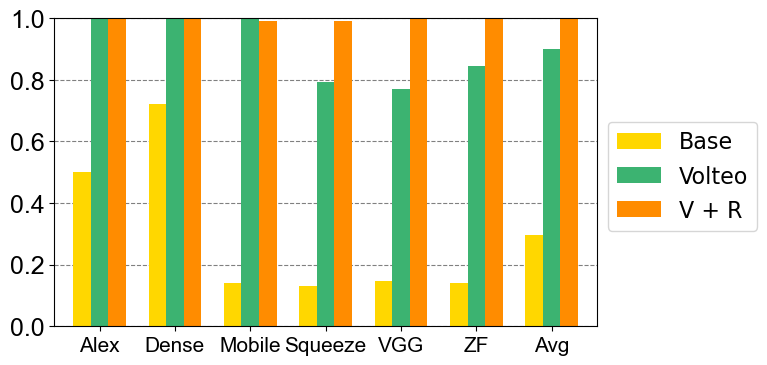

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_x2_x3_4_es.index)

 
x = np.arange(n)
coloresRedes = ['gold','mediumseagreen', 'darkorange']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_x2_x3_4_es.plot(kind ='bar', width = 0.70, fontsize=15, color = coloresRedes, figsize=(7,4), zorder=2 );
#plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.55), shadow = True)
#plt.legend(  fontsize=16, bbox_to_anchor=(0.7,0.2),shadow = True)
#legend = plt.legend(['Day 1','Day 2'])
plt.legend(['Base','Volteo','V + R'] , fontsize=16, bbox_to_anchor=(1,0.7),shadow = False)

plt.ylim(0,1.0)
#plt.ylabel('Precisión normalizada', fontsize=16, fontfamily="serif")
plt.xlabel('')
plt.xticks(x, Resumen_x2_x3_4_es.index, fontsize= 15, fontfamily="arial")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0.0', '0.2', '0.4', '0.6','0.8','1.0'),fontsize= 18, fontfamily="arial")
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.savefig('Resumen_acc_experimentos_ppt.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#

In [1]:
import pandas as pd
Evento_Gaz=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_base',usecols=["redes","Base","Flip","F+P"] )
Evento_Gaz= Evento_Gaz.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])
Evento_Gaz

,Base,Flip,F+P
redes,,,
AlexNet,0.499981,0.999963,0.999963
DenseNet,0.722654,1.001496,1.002956
MobileNet,0.142209,0.998487,0.992436
Inception,0.171875,0.859375,0.973958
ResNet,0.635468,1.000000,1.000000
SqueezeNet,0.131800,0.792235,0.989936
VGG16,0.145701,0.771555,0.996730
VGG19,0.510593,1.000000,1.000000
Xception,0.146018,0.782222,1.000000


<Figure size 2000x500 with 0 Axes>

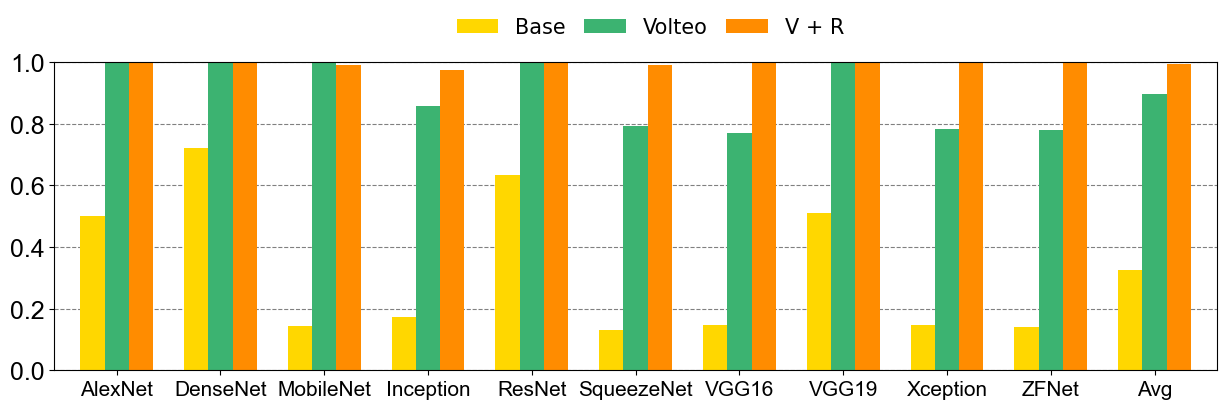

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Evento_Gaz.index)

 
x = np.arange(n)
coloresRedes = ['gold','mediumseagreen', 'darkorange']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Evento_Gaz.plot(kind ='bar', width = 0.70, fontsize=15, color = coloresRedes, figsize=(15,4), zorder=2 );
lg = plt.legend(['Base','Volteo','V + R'],  fontsize=15, loc ="lower left",bbox_to_anchor=(0.33,1.02), shadow = False, ncol=3, columnspacing=0.9)
lg.draw_frame(False)
#plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.55), shadow = True)
#plt.legend(  fontsize=16, bbox_to_anchor=(0.7,0.2),shadow = True)
#legend = plt.legend(['Day 1','Day 2'])
#plt.legend(['Base','Volteo','V + R'] , fontsize=16, bbox_to_anchor=(1,0.7),shadow = False)

plt.ylim(0,1.0)
#plt.ylabel('Precisión normalizada', fontsize=16, fontfamily="serif")
plt.xlabel('')
plt.xticks(x, Evento_Gaz.index, fontsize= 15, fontfamily="arial")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0.0', '0.2', '0.4', '0.6','0.8','1.0'),fontsize= 18, fontfamily="arial")
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.savefig('Evento_Gaz.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#

# Poster

In [49]:
import pandas as pd
Resumen_x2_x3_4_post=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_base_esp',usecols=["redes","Base","I-A ECC", "ECC","Flip","F + P"] )
Resumen_x2_x3_4_post= Resumen_x2_x3_4_post.set_index("redes")

In [50]:
Resumen_x2_x3_4_post

,Base,I-A ECC,ECC,Flip,F + P
redes,,,,,
Alex,0.499981,0.582314,0.836795,0.999963,0.999963
Dense,0.722654,0.779591,0.997117,1.001496,1.002956
Mobile,0.141892,0.141892,0.608325,0.996264,0.990226
Squeeze,0.131800,0.131800,0.183375,0.792235,0.989936
VGG,0.145701,0.145701,0.145701,0.771555,0.996730
ZF,0.140806,0.140806,0.352014,0.846434,0.996840
Avg,0.297139,0.320351,0.520554,0.901325,0.996108


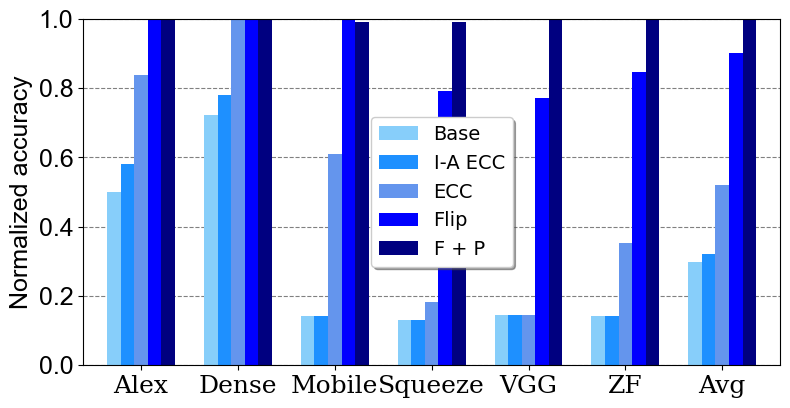

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_x2_x3_4_post.index)

 
x = np.arange(n)
coloresRedes = [ 'lightskyblue', 'dodgerblue','cornflowerblue','blue', 'navy']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
#fig = plt.figure(figsize=(5,4), dpi=100)

Resumen_x2_x3_4_post.plot(kind ='bar', width = 0.70, fontsize=18, color = coloresRedes, figsize=(9,4.5), zorder=2 );
plt.legend(  fontsize=14, loc ="center right",bbox_to_anchor=(0.63,0.50), shadow = True)
#plt.legend(  fontsize=14, bbox_to_anchor=(0.21,-0.09),shadow = False)
plt.ylim(0,1.0)
plt.ylabel('Normalized accuracy', fontsize=18, fontfamily="arial")
plt.xlabel('')
plt.xticks(x, Resumen_x2_x3_4_post.index, fontsize= 18, fontfamily="serif")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0.0', '0.2', '0.4', '0.6','0.8','1.0'),fontsize= 18, fontfamily="arial")
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.savefig('Resumen_acc_experimentos_poster.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#

In [4]:
import pandas as pd
Resumen_x2_x3_4=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_base',usecols=["redes","Base","I-A ECC", "ECC","Flip","F+P"] )
Resumen_x2_x3_4= Resumen_x2_x3_4.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


<Figure size 2000x500 with 0 Axes>

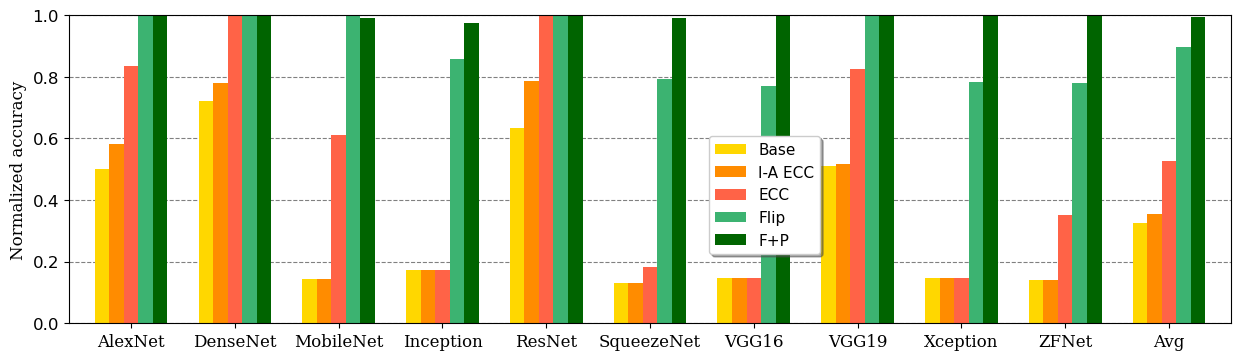

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_x2_x3_4.index)

 
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_x2_x3_4.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(15,4), zorder=2 );
#plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.55), shadow = True)
plt.legend(  fontsize=11, bbox_to_anchor=(0.653,0.2),shadow = True)
plt.ylim(0,1.0)
plt.ylabel('Normalized accuracy', fontsize=12, fontfamily="serif")
plt.xlabel('')
plt.xticks(x, Resumen_x2_x3_4.index, fontsize= 12, fontfamily="serif")
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.savefig('summary_acc_exp_all_nets.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()


In [76]:
#import pandas as pd
#Resumen_all_volts=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/Resumen_acc_exp_todos los voltajes_y redes.xlsx',sheet_name='graficar',usecols=["voltajes","Base","I-A ECC", "ECC","Flip","F+P"] )
#Resumen_all_volts= Resumen_all_volts.set_index("voltajes")
##Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])
#Resumen_all_volts

In [77]:
#import numpy as np
#import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages, PdfFile
#n = len(Resumen_all_volts.index)
#
# 
#x = np.arange(n)
#coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
##coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
##fig = plt.figure(figsize=(20,5), dpi=100)
#
#Resumen_all_volts.plot(kind ='bar', width = 0.80, fontsize=12, color = coloresRedes, figsize=(15,2.5), zorder=2 );
##plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.55), shadow = True)
#plt.legend(  fontsize=11, bbox_to_anchor=(0.653,0.2),shadow = True)
#plt.ylim(0,1.0)
#plt.ylabel('Normalized accuracy', fontsize=12, fontfamily="serif")
#plt.xlabel('')
#plt.xticks(x, Resumen_all_volts.index, fontsize= 12, fontfamily="serif")
#plt.xticks(rotation = 0)
#plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
#plt.savefig('summary_acc_experiments.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.show()
##pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
##pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
##pdfFile.close()
#

### Máscra basex2

In [28]:
import pandas as pd
Resumen_x2_x3_4=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_basex2',usecols=["redes","Baseline","Iso-area ECC",  "ECC","Flip","Flip+Patch"] )
Resumen_base_x2= Resumen_x2_x3_4.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [29]:
Resumen_base_x2

,Baseline,Iso-area ECC,ECC,Flip,Flip+Patch
redes,,,,,
Alex,0.348802,0.365269,0.729042,1.001497,1.001497
Dense,0.427753,0.458411,0.947480,1.000037,1.004416
Mobile,0.139183,0.139183,0.189107,0.954614,0.995461
Squeeze,0.131805,0.131805,0.131805,0.588825,0.954155
VGG,0.145695,0.145695,0.145695,0.649007,0.993378
ZF,0.140800,0.140800,0.190400,0.852800,0.996800
Avg,0.222340,0.230194,0.388922,0.841130,0.990951


<Figure size 2000x500 with 0 Axes>

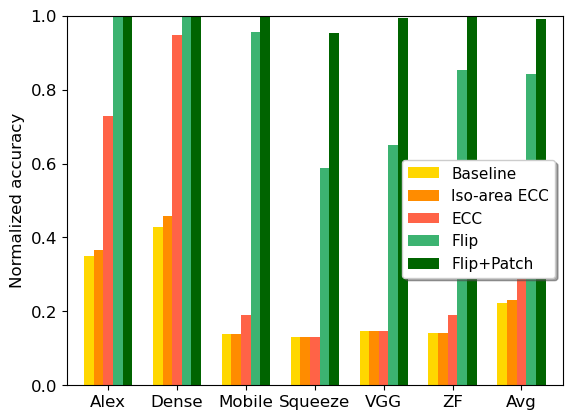

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_base_x2.index)

 
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_base_x2.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
plt.ylabel('Normalized accuracy', fontsize=12)
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, Resumen_base_x2.index, fontsize= 12)
plt.xticks(rotation = 0)

plt.savefig('Resumen_acc_exp_base_x2.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#


### Máscra basex3

In [2]:
import pandas as pd
Resumen_x2_x3_4=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_basex3',usecols=["redes","Baseline","Iso-area ECC",  "ECC","Flip","Flip+Patch"] )
Resumen_base_x3= Resumen_x2_x3_4.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [3]:
Resumen_base_x3

,Baseline,Iso-area ECC,ECC,Flip,Flip+Patch
redes,,,,,
Alex,0.285928,0.297904,0.585329,1.000000,1.001497
Dense,0.262783,0.322640,0.727034,0.997117,1.004416
Mobile,0.139183,0.139183,0.139183,0.845688,0.987897
Squeeze,0.131805,0.131805,0.131805,0.383954,0.808023
VGG,0.145695,0.145695,0.145695,0.485099,0.978477
ZF,0.140800,0.140800,0.140800,0.856000,1.006400
Avg,0.184366,0.196338,0.311641,0.761310,0.964452


<Figure size 2000x500 with 0 Axes>

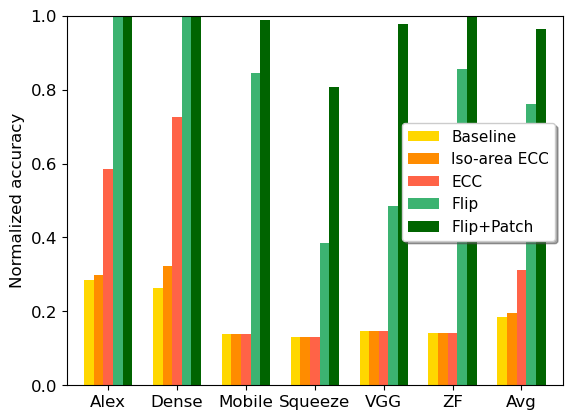

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_base_x3.index)

 
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_base_x3.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
#plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(0.70,0.50), shadow = True)
plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.55) ,shadow = True)
plt.ylim(0,1)
plt.ylabel('Normalized accuracy', fontsize=12)
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, Resumen_base_x3.index, fontsize= 12)
plt.xticks(rotation = 0)

plt.savefig('Resumen_acc_exp_base_x3.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#


### Máscra basex4

In [4]:
import pandas as pd
Resumen_x2_x3_4=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_basex4',usecols=["redes","Base","I-A ECC",  "ECC","Flip","F+P"] )
Resumen_base_x4= Resumen_x2_x3_4.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [5]:
Resumen_base_x4

,Base,I-A ECC,ECC,Flip,F+P
redes,,,,,
Alex,0.245509,0.248503,0.435629,0.998503,1.002994
Dense,0.140151,0.197087,0.611701,0.998577,1.004416
Mobile,0.139183,0.139183,0.139183,0.851740,0.989410
Squeeze,0.131805,0.131805,0.131805,0.283668,0.727794
VGG,0.145695,0.145695,0.145695,0.377483,0.965232
ZF,0.140800,0.140800,0.140800,0.852800,1.004800
Avg,0.157191,0.167179,0.267469,0.727128,0.949108


<Figure size 2000x500 with 0 Axes>

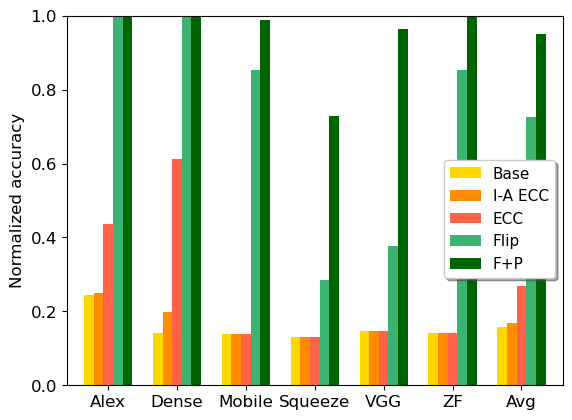

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_base_x4.index)
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_base_x4.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1.0)
plt.ylabel('Normalized accuracy', fontsize=12)
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, Resumen_base_x4.index, fontsize= 12)
plt.xticks(rotation = 0)

plt.savefig('Resumen_acc_exp_base_x4.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#


In [ ]:
#poner las redes como el index es decir decir que el index seran las redes

In [9]:
Gráfica_general_técnicas_redes=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja3')
Resumen_mask= Gráfica_general_técnicas_redes.set_index("Tec_red")

In [2]:
Gráfica_general_técnicas_redes=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja_españ')
Resumen_mask= Gráfica_general_técnicas_redes.set_index("Tec_red")

In [3]:
Resumen_mask

,1x fallos,2x fallos,3x fallos,4x fallos
Tec_red,,,,
Base,0.445333,0.310667,0.254667,0.218667
I-A ECC,0.518667,0.325333,0.265333,0.221333
ECC,0.745333,0.649333,0.265333,0.221333
Volteo,0.890667,0.892000,0.890667,0.889333
V + R,0.890667,0.892000,0.892000,0.893333
Base,0.660000,0.122667,0.122667,0.122667
I-A ECC,0.712000,0.122667,0.122667,0.122667
ECC,0.910667,0.865333,0.294667,0.180000
Volteo,0.914667,0.913333,0.910667,0.912000


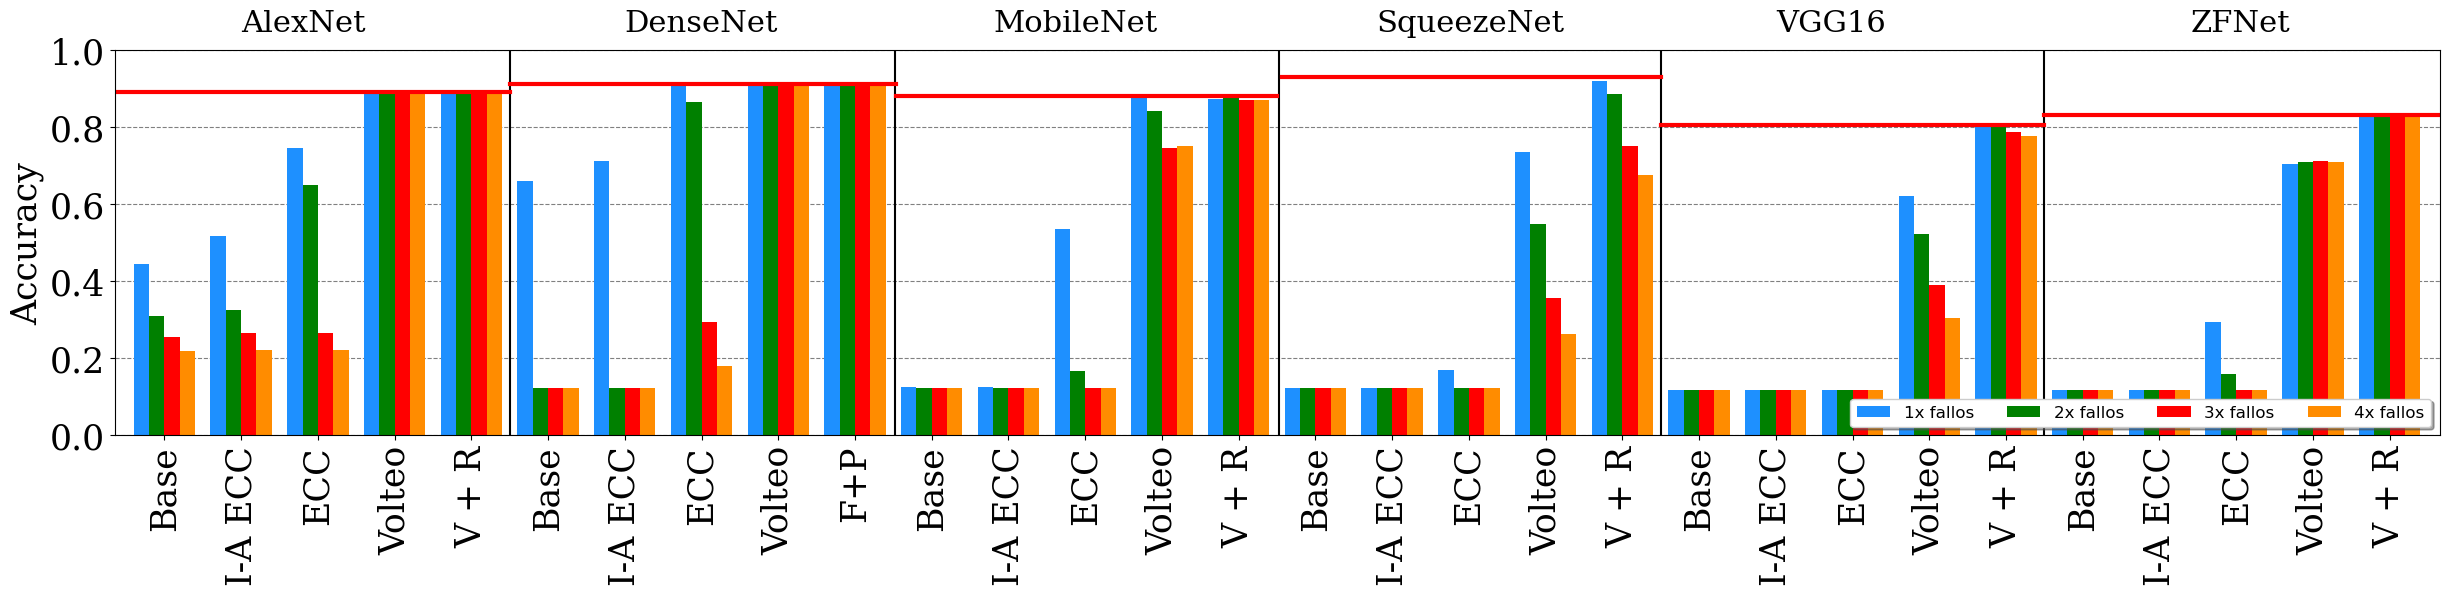

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns

n = len(Resumen_mask.index)
x = np.arange(n)
#coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','green','red', 'darkorange']


Resumen_mask.plot(kind ='bar', width = 0.80, fontsize=22, color = coloresRedes, figsize=(30,5), zorder=2 );
plt.legend(fontsize=12, loc ="lower right", shadow = True, ncol=4)
#plt.legend(  fontsize=19, bbox_to_anchor=(0.24,0.40),shadow = True, ncol=4)
plt.ylim(0,1.0)
plt.ylabel('Accuracy', fontsize=25, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras


plt.axvline(x=4.5, ymax= 5, color="black")
plt.axvline(x=9.52, ymax= 5, color="black")
plt.axvline(x=14.52, ymax= 5, color="black")
plt.axvline(x=19.5, ymax= 5, color="black")
plt.axvline(x=24.5, ymax= 5, color="black")

plt.axhline(y=0.8907, xmax= 0.17,             linewidth=3,color="red") #'AlexNet'
plt.axhline(y=0.9133, xmin=0.17, xmax= 0.336, linewidth=3,color="red")#DenseNet
plt.axhline(y=0.8813, xmin=0.336, xmax= 0.50, linewidth=3, color="red")#MobileNet
plt.axhline(y=0.9307, xmin=0.502, xmax= 0.665,linewidth=3,color="red")# SqueezeNet
plt.axhline(y=0.8053, xmin=0.665, xmax= 0.83,linewidth=3, color="red")#VGG
plt.axhline(y=0.8333, xmin=0.83,  xmax= 1,   linewidth=3, color="red")#ZFNet


plt.xlabel('')
plt.xticks(x, Resumen_mask.index, fontsize= 25, fontfamily="serif")
plt.yticks( fontsize= 25, fontfamily="serif")
plt.xticks(rotation = 90)
plt.text(1, 1.05, 'AlexNet', fontsize=22, fontfamily="serif")
plt.text(6, 1.05, 'DenseNet', fontsize=22, fontfamily="serif")
plt.text(10.8, 1.05, 'MobileNet', fontsize=22, fontfamily="serif")
plt.text(15.8, 1.05, 'SqueezeNet', fontsize=22, fontfamily="serif")
plt.text(21.0, 1.05, 'VGG16', fontsize=22, fontfamily="serif")
plt.text(26.4, 1.05, 'ZFNet', fontsize=22, fontfamily="serif")

#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '93.07 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '80.53 %', fontsize=20, fontfamily="serif")
#plt.text(26.4, 0.85, '83.33 %', fontsize=20, fontfamily="serif")


plt.savefig('Resumen_acc_exp_mascaras_.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()


In [2]:
Gráfica_general_técnicas_redes_hoja3=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja3')
Resumen_mask_3= Gráfica_general_técnicas_redes_hoja3.set_index("Tec_red")

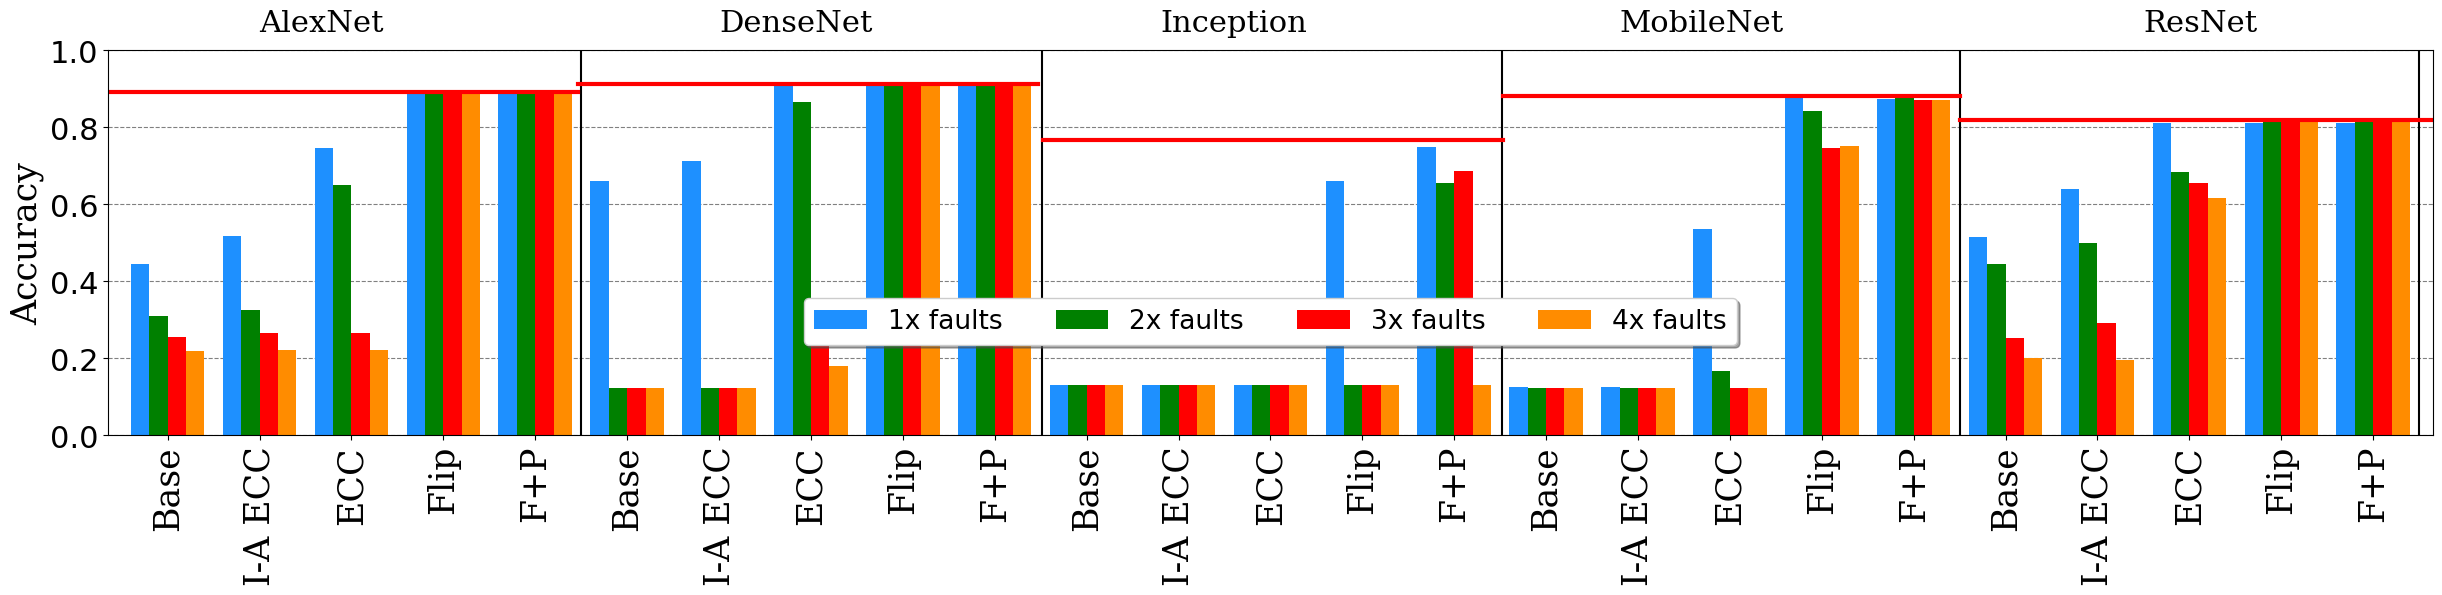

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns

n = len(Resumen_mask_3.index)
x = np.arange(n)
#coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','green','red', 'darkorange']


Resumen_mask_3.plot(kind ='bar', width = 0.80, fontsize=22, color = coloresRedes, figsize=(30,5), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=19, bbox_to_anchor=(0.5,0.2),shadow = True,ncol=4)
plt.ylim(0,1.0)
plt.ylabel('Accuracy', fontsize=25, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras


plt.axvline(x=4.5, ymax= 5, color="black")
plt.axvline(x=9.52, ymax= 5, color="black")
plt.axvline(x=14.52, ymax= 5, color="black")
plt.axvline(x=19.5, ymax= 5, color="black")
plt.axvline(x=24.5, ymax= 5, color="black")

plt.axhline(y=0.8907, xmax= 0.202,             linewidth=3,color="red") #'AlexNet'
plt.axhline(y=0.9133, xmin=0.202, xmax= 0.4, linewidth=3,color="red")#DenseNet
plt.axhline(y=0.7680, xmin=0.402, xmax= 0.5999, linewidth=3, color="red")#Incept
plt.axhline(y=0.8813, xmin=0.5999, xmax= 0.7966,linewidth=3,color="red")# Mobile
plt.axhline(y=0.82, xmin=0.7966, xmax= 1,linewidth=3, color="red")#ResNet



plt.xlabel('')
plt.xticks(x, Resumen_mask_3.index, fontsize= 25, fontfamily="serif")
plt.xticks(rotation = 90)
plt.text(1, 1.05, 'AlexNet', fontsize=22, fontfamily="serif")
plt.text(6, 1.05, 'DenseNet', fontsize=22, fontfamily="serif")
plt.text(10.8, 1.05, 'Inception', fontsize=22, fontfamily="serif")
plt.text(15.8, 1.05, 'MobileNet', fontsize=22, fontfamily="serif")
plt.text(21.5, 1.05, 'ResNet', fontsize=22, fontfamily="serif")


#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '76.80 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '81.19 %', fontsize=20, fontfamily="serif")



plt.savefig('Resumen_acc_exp_mascaras_.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()


In [30]:
Gráfica_general_técnicas_redes=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja4')
Resumen_mask= Gráfica_general_técnicas_redes.set_index("Tec_red")

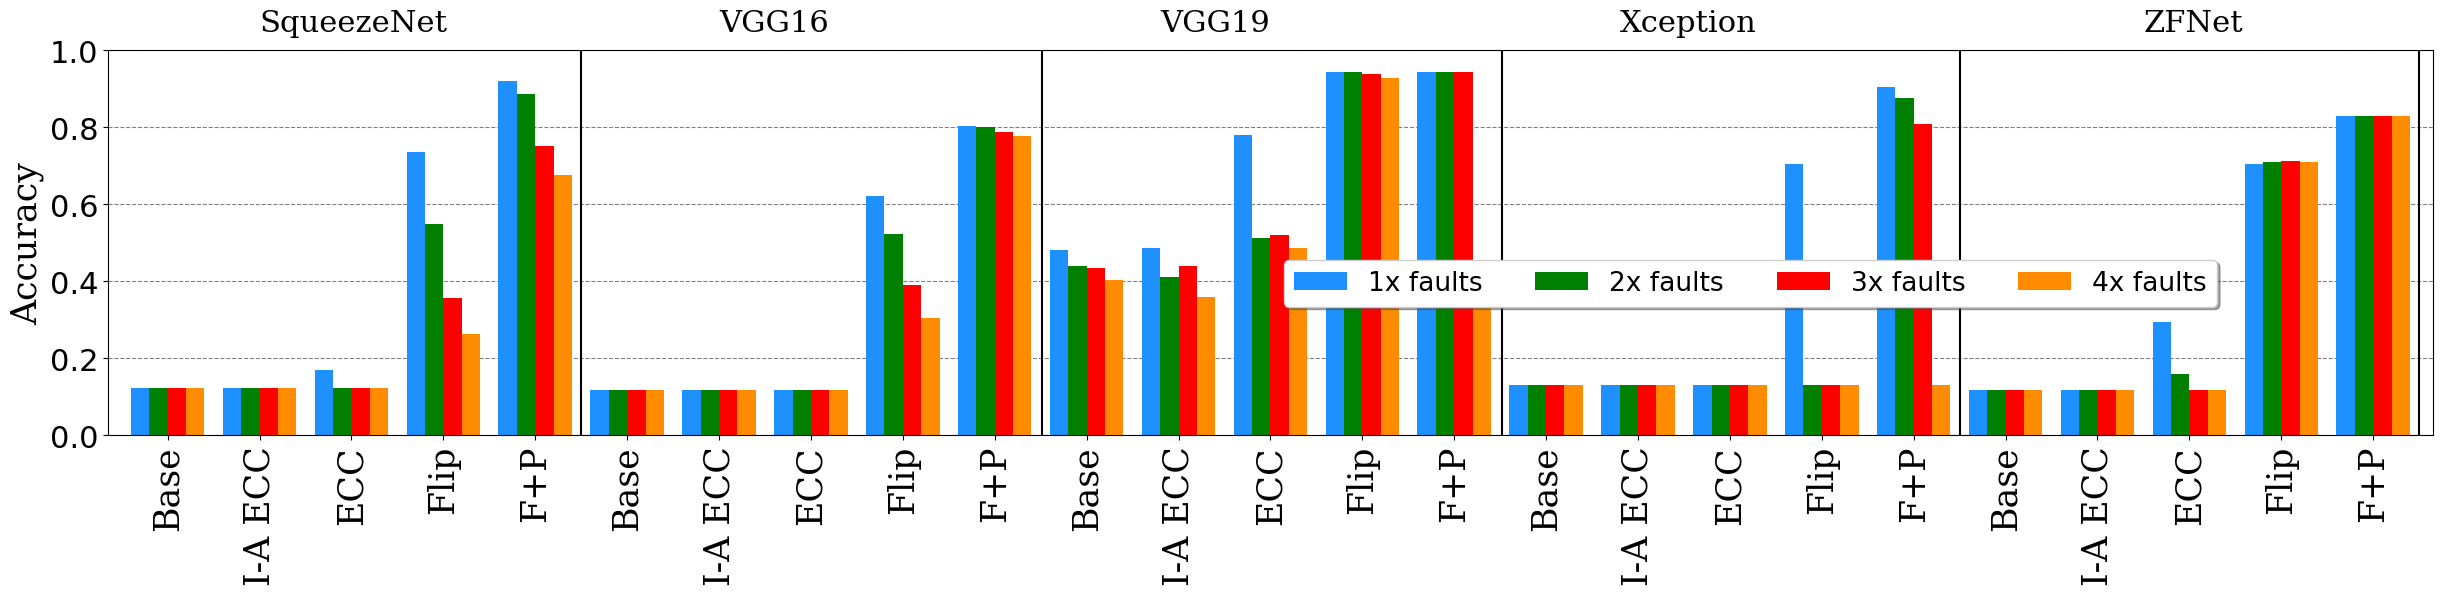

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns

n = len(Resumen_mask.index)
x = np.arange(n)
#coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','green','red', 'darkorange']


Resumen_mask.plot(kind ='bar', width = 0.80, fontsize=22, color = coloresRedes, figsize=(30,5), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=19, bbox_to_anchor=(0.5,0.3),shadow = True, ncol=4)
plt.ylim(0,1.0)
plt.ylabel('Accuracy', fontsize=25, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras


plt.axvline(x=4.5, ymax= 5, color="black")
plt.axvline(x=9.52, ymax= 5, color="black")
plt.axvline(x=14.52, ymax= 5, color="black")
plt.axvline(x=19.5, ymax= 5, color="black")
plt.axvline(x=24.5, ymax= 5, color="black")

#plt.axhline(y=0.8907, xmax= 0.17,             linewidth=3,color="red") #'AlexNet'
#plt.axhline(y=0.9133, xmin=0.17, xmax= 0.336, linewidth=3,color="red")#DenseNet
#plt.axhline(y=0.8813, xmin=0.336, xmax= 0.50, linewidth=3, color="red")#MobileNet
#plt.axhline(y=0.9307, xmin=0.502, xmax= 0.665,linewidth=3,color="red")# SqueezeNet
#plt.axhline(y=0.8053, xmin=0.665, xmax= 0.83,linewidth=3, color="red")#VGG
#plt.axhline(y=0.8333, xmin=0.83,  xmax= 1,   linewidth=3, color="red")#ZFNet


plt.xlabel('')
plt.xticks(x, Resumen_mask.index, fontsize= 25, fontfamily="serif")
plt.xticks(rotation = 90)
plt.text(1, 1.05, 'SqueezeNet', fontsize=22, fontfamily="serif")
plt.text(6, 1.05, 'VGG16', fontsize=22, fontfamily="serif")
plt.text(10.8, 1.05, 'VGG19', fontsize=22, fontfamily="serif")
plt.text(15.8, 1.05, 'Xception', fontsize=22, fontfamily="serif")
plt.text(21.5, 1.05, 'ZFNet', fontsize=22, fontfamily="serif")


#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '93.07 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '80.53 %', fontsize=20, fontfamily="serif")
#plt.text(26.4, 0.85, '83.33 %', fontsize=20, fontfamily="serif")


#plt.savefig('Resumen_acc_exp_mascaras.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

In [2]:
Gráfica_general_técnicas_redes_all_nets_vbw16x=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja3VBW_16x_all_nets')
Resumen_all_nets_vbw16x= Gráfica_general_técnicas_redes_all_nets_vbw16x.set_index("Tec_red")

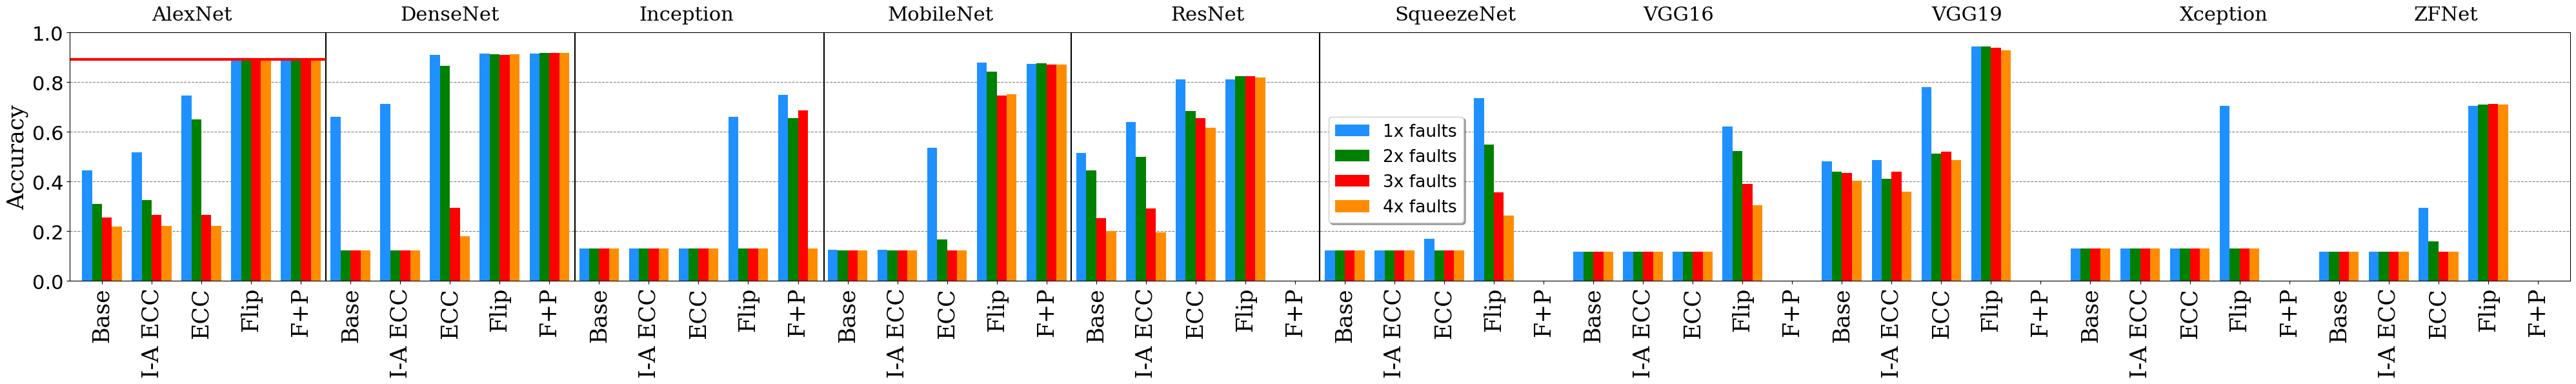

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns

n = len(Resumen_all_nets_vbw16x.index)
x = np.arange(n)
#coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','green','red', 'darkorange']


Resumen_all_nets_vbw16x.plot(kind ='bar', width = 0.80, fontsize=22, color = coloresRedes, figsize=(50,5), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=19, bbox_to_anchor=(0.5,0.2),shadow = True)
plt.ylim(0,1.0)
plt.ylabel('Accuracy', fontsize=25, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras


plt.axvline(x=4.5, ymax= 5, color="black")
plt.axvline(x=9.52, ymax= 5, color="black")
plt.axvline(x=14.52, ymax= 5, color="black")
plt.axvline(x=19.5, ymax= 5, color="black")
plt.axvline(x=24.5, ymax= 5, color="black")

plt.axhline(y=0.8907, xmax= 0.102,linewidth=3,color="red") #'AlexNet'
#plt.axhline(y=0.95, xmin=0.203, xmax= 0.4, linewidth=3,color="red")#DenseNet
#plt.axhline(y=0.7680, xmin=0.402, xmax= 0.5999, linewidth=3, color="red")#Incept
#plt.axhline(y=0.8813, xmin=0.5999, xmax= 0.7966,linewidth=3,color="red")# Mobile
#plt.axhline(y=0.82, xmin=0.7966, xmax= 0.9966,linewidth=3, color="red")#ResNet
#plt.axhline(y=0.7966, xmin=0.9966, xmax= 1,linewidth=3,color="red")# Squez
#plt.axhline(y=0.805, xmin=0.203, xmax= 0.4, linewidth=3,color="red")#VGG16
#plt.axhline(y=0.9440, xmin=0.402, xmax= 0.5999, linewidth=3, color="red")#VGG19
#plt.axhline(y=0.9040,xmin=0.5999, xmax= 0.7966,linewidth=3,color="red") #'Xception'
#plt.axhline(y=0.8333, xmin=0.7966,  xmax= 1,   linewidth=3, color="red")#ZFNet
#


plt.xlabel('')
plt.xticks(x, Resumen_all_nets_vbw16x.index, fontsize= 25, fontfamily="serif")
plt.xticks(rotation = 90)
plt.text(1, 1.05, 'AlexNet', fontsize=22, fontfamily="serif")
plt.text(6, 1.05, 'DenseNet', fontsize=22, fontfamily="serif")
plt.text(10.8, 1.05, 'Inception', fontsize=22, fontfamily="serif")
plt.text(15.8, 1.05, 'MobileNet', fontsize=22, fontfamily="serif")
plt.text(21.5, 1.05, 'ResNet', fontsize=22, fontfamily="serif")
plt.text(26, 1.05, 'SqueezeNet', fontsize=22, fontfamily="serif")
plt.text(31, 1.05, 'VGG16', fontsize=22, fontfamily="serif")
plt.text(36.8, 1.05, 'VGG19', fontsize=22, fontfamily="serif")
plt.text(41.8, 1.05, 'Xception', fontsize=22, fontfamily="serif")
plt.text(46.5, 1.05, 'ZFNet', fontsize=22, fontfamily="serif")

#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '93.07 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '80.53 %', fontsize=20, fontfamily="serif")
#plt.text(26.4, 0.85, '83.33 %', fontsize=20, fontfamily="serif")


#plt.savefig('Resumen_acc_exp_mascaras_F+P_modificado_prueba.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()


## Versión Final

In [148]:
import pandas as pd
Gráfica_general_técnicas_redes_hoja3vbw16x=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja3VBW_16x')
Resumen_mask_3_vbw16x= Gráfica_general_técnicas_redes_hoja3vbw16x.set_index("Tec_red")

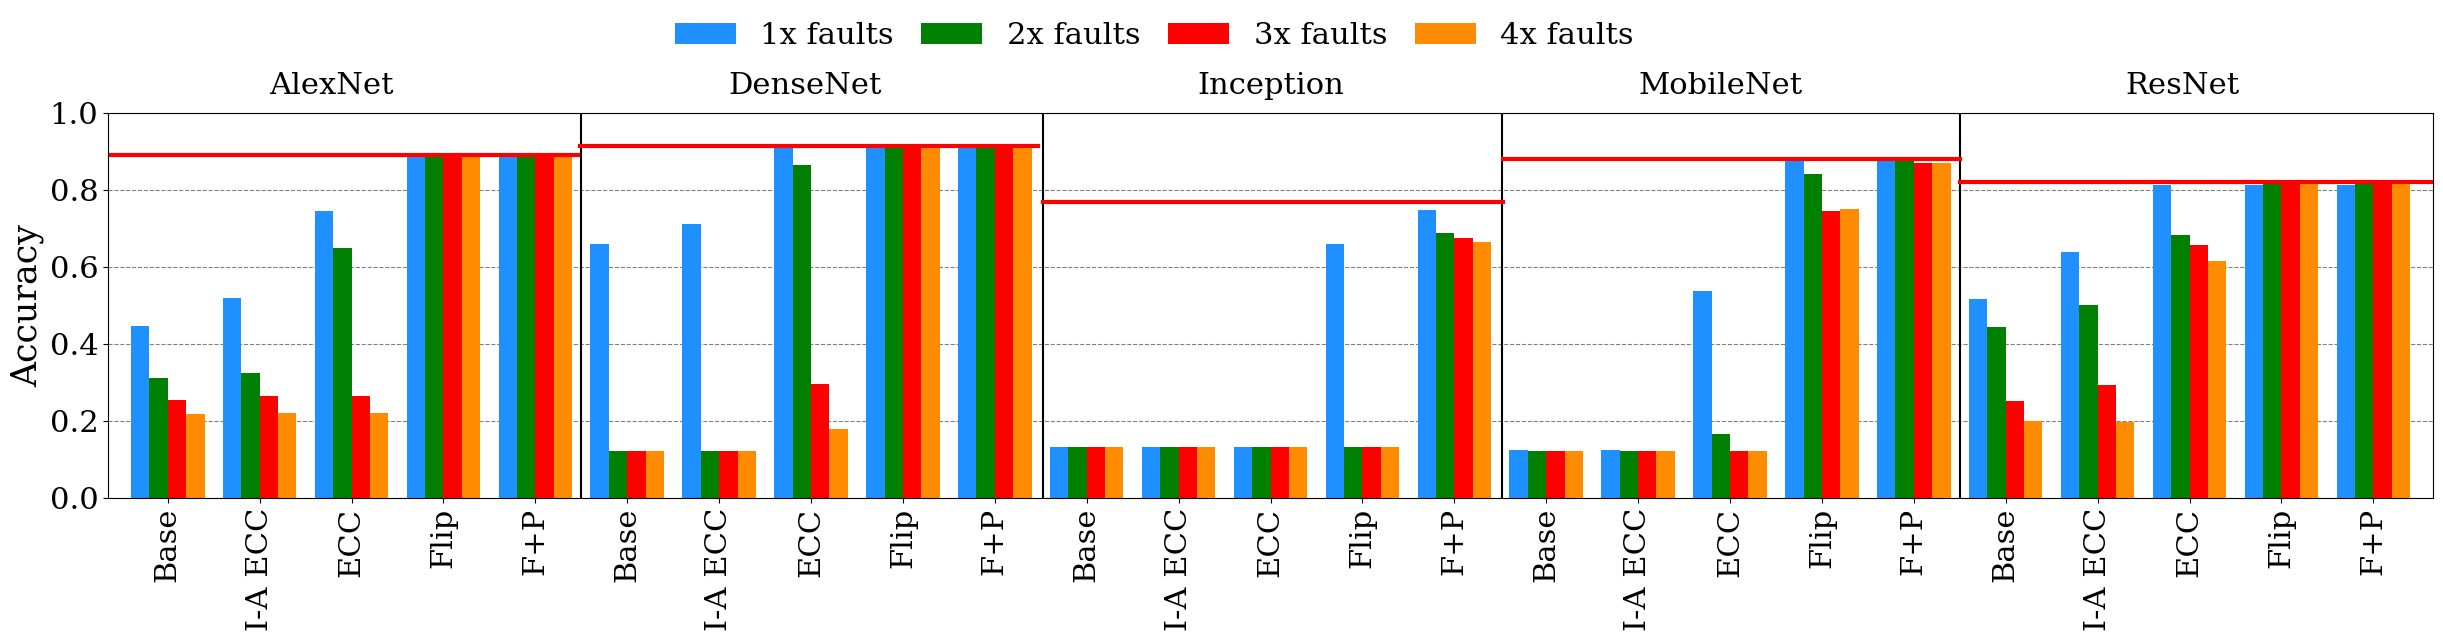

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns
import matplotlib as mpl  
mpl.rcParams['font.family']='serif'

n = len(Resumen_mask_3_vbw16x.index)
x = np.arange(n)
#coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','green','red', 'darkorange']


Resumen_mask_3_vbw16x.plot(kind ='bar', width = 0.80, fontsize=22, color = coloresRedes, figsize=(30,5), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
lg = plt.legend(  fontsize=22,loc ="center", bbox_to_anchor=(0.45,1.2),shadow = True, ncol=4, columnspacing=0.9)
lg.draw_frame(False)
plt.ylim(0,1.0)
plt.ylabel('Accuracy', fontsize=25, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras


plt.axvline(x=4.5, ymax= 5, color="black")
plt.axvline(x=9.52, ymax= 5, color="black")
plt.axvline(x=14.52, ymax= 5, color="black")
plt.axvline(x=19.5, ymax= 5, color="black")
#plt.axvline(x=24.5, ymax= 5, color="black")

plt.axhline(y=0.8907, xmax= 0.202,linewidth=3,color="red") #'AlexNet'
plt.axhline(y=0.9133, xmin=0.203, xmax= 0.4, linewidth=3,color="red")#DenseNet
plt.axhline(y=0.7680, xmin=0.402, xmax= 0.5999, linewidth=3, color="red")#Incept
plt.axhline(y=0.8813, xmin=0.5999, xmax= 0.7966,linewidth=3,color="red")# Mobile
plt.axhline(y=0.82, xmin=0.7966, xmax=1,linewidth=3, color="red")#ResNet
#plt.axhline(y=0.7966, xmin=0.9966, xmax= 1,linewidth=3,color="red")# Squez
#plt.axhline(y=0.805, xmin=0.203, xmax= 0.4, linewidth=3,color="red")#VGG16
#plt.axhline(y=0.9440, xmin=0.402, xmax= 0.5999, linewidth=3, color="red")#VGG19
#plt.axhline(y=0.9040,xmin=0.5999, xmax= 0.7966,linewidth=3,color="red") #'Xception'
#plt.axhline(y=0.8333, xmin=0.7966,  xmax= 1,   linewidth=3, color="red")#ZFNet
#


plt.xlabel('')
plt.xticks(x, Resumen_mask_3_vbw16x.index, fontsize= 22, fontfamily="serif")
plt.xticks(rotation = 90)
plt.text(1.1, 1.05, 'AlexNet', fontsize=22, fontfamily="serif")
plt.text(6.1, 1.05, 'DenseNet', fontsize=22, fontfamily="serif")
plt.text(11.2, 1.05, 'Inception', fontsize=22, fontfamily="serif")
plt.text(16, 1.05, 'MobileNet', fontsize=22, fontfamily="serif")
plt.text(21.3, 1.05, 'ResNet', fontsize=22, fontfamily="serif")


#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '93.07 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '80.53 %', fontsize=20, fontfamily="serif")
#plt.text(26.4, 0.85, '83.33 %', fontsize=20, fontfamily="serif")


plt.savefig('Resumen_acc_exp_mascaras_F+P_modificado_rectificado.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()


In [4]:
Gráfica_general_técnicas_redesvbw16=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja4VBW_16x')
Resumen_mask4vbw16= Gráfica_general_técnicas_redesvbw16.set_index("Tec_red")

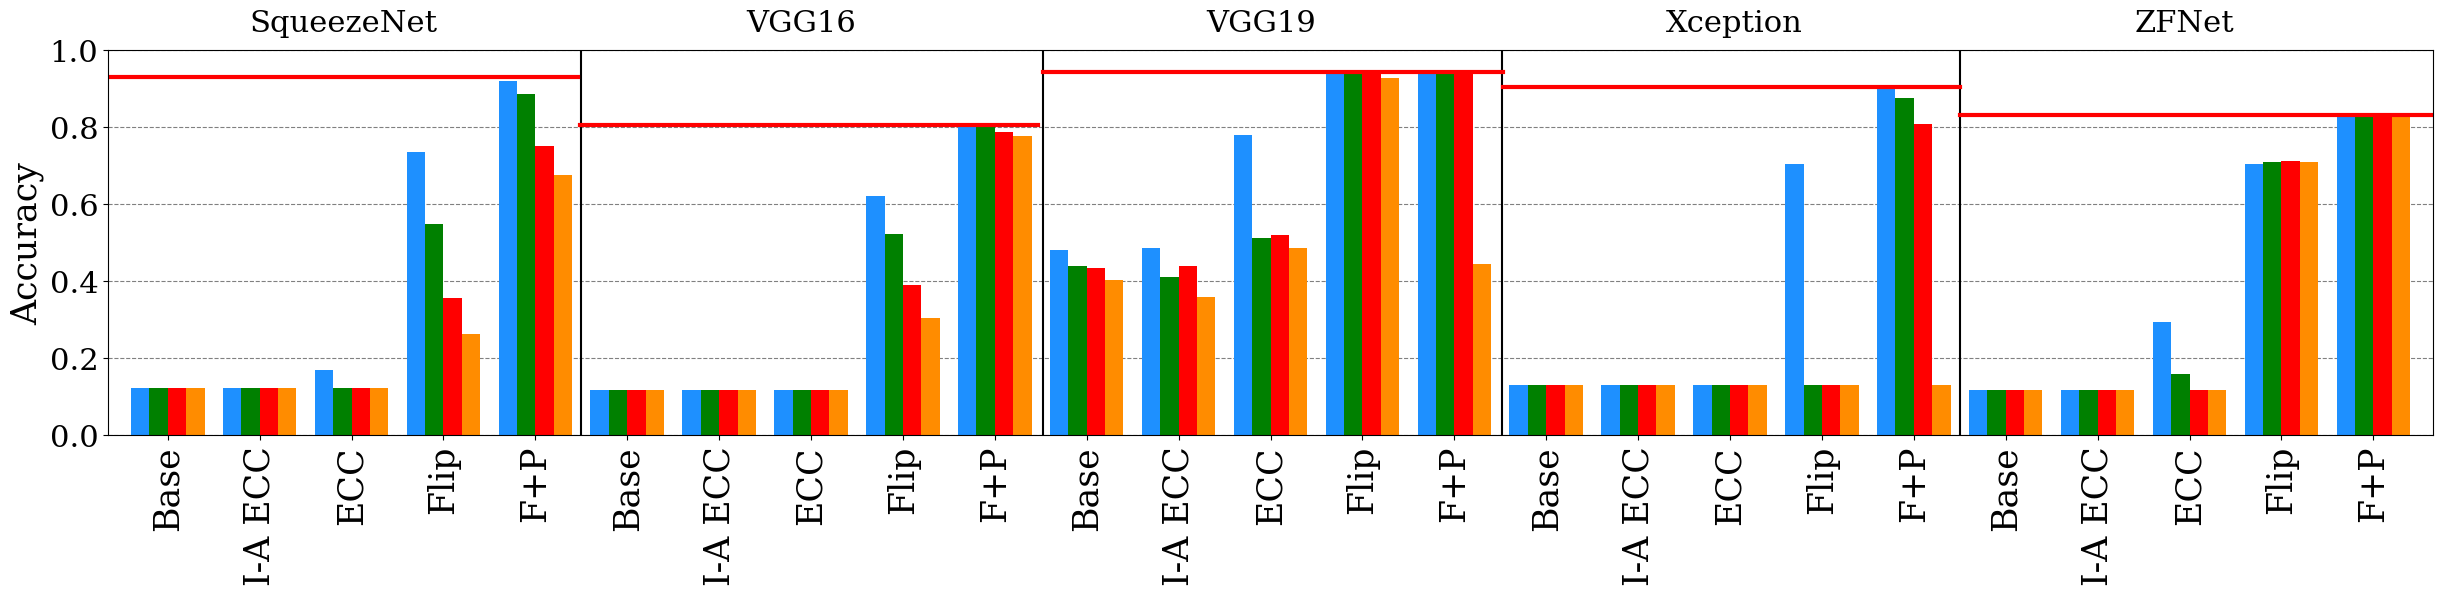

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns

n = len(Resumen_mask4vbw16.index)
x = np.arange(n)
#coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','green','red', 'darkorange']


Resumen_mask4vbw16.plot(kind ='bar', width = 0.80, fontsize=22, color = coloresRedes, figsize=(30,5), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend([],[], frameon=False)
#Resumen_mask4vbw16.plot(legend=None)
#plt.get_legend().remove()
plt.ylim(0,1.0)
plt.ylabel('Accuracy', fontsize=25, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras






plt.axvline(x=4.5, ymax= 5, color="black")
plt.axvline(x=9.52, ymax= 5, color="black")
plt.axvline(x=14.52, ymax= 5, color="black")
plt.axvline(x=19.5, ymax= 5, color="black")
#plt.axvline(x=24.5, ymax= 5, color="black")




plt.axhline(y=0.9307,  xmax= 0.202,linewidth=3,color="red")# Squez
plt.axhline(y=0.805, xmin=0.203, xmax= 0.4, linewidth=3,color="red")#VGG16
plt.axhline(y=0.9440, xmin=0.402, xmax= 0.5999, linewidth=3, color="red")#VGG19
plt.axhline(y=0.9040,xmin=0.5999, xmax= 0.7966,linewidth=3,color="red") #'Xception'
plt.axhline(y=0.8333, xmin=0.7966,  xmax= 1,   linewidth=3, color="red")#ZFNet


plt.xlabel('')
plt.xticks(x, Resumen_mask4vbw16.index, fontsize= 25, fontfamily="serif")
plt.xticks(rotation = 90)
plt.text(0.89, 1.05, 'SqueezeNet', fontsize=22, fontfamily="serif")
plt.text(6.3, 1.05, 'VGG16', fontsize=22, fontfamily="serif")
plt.text(11.3, 1.05, 'VGG19', fontsize=22, fontfamily="serif")
plt.text(16.3, 1.05, 'Xception', fontsize=22, fontfamily="serif")
plt.text(21.4, 1.05, 'ZFNet', fontsize=22, fontfamily="serif")


#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6.2, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '93.07 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '80.53 %', fontsize=20, fontfamily="serif")
#plt.text(26.4, 0.85, '83.33 %', fontsize=20, fontfamily="serif")


#plt.savefig('Resumen_acc_exp_mascaras_F+P_modificado_parte_2.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

# Charla Gaz

In [5]:
import pandas as pd
Gráfica_general_técnicas_redes_hoja3vbw16x=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja3VBW_16x_charla_gaz')
Resumen_mask_3_vbw16x= Gráfica_general_técnicas_redes_hoja3vbw16x.set_index("Tec_red")

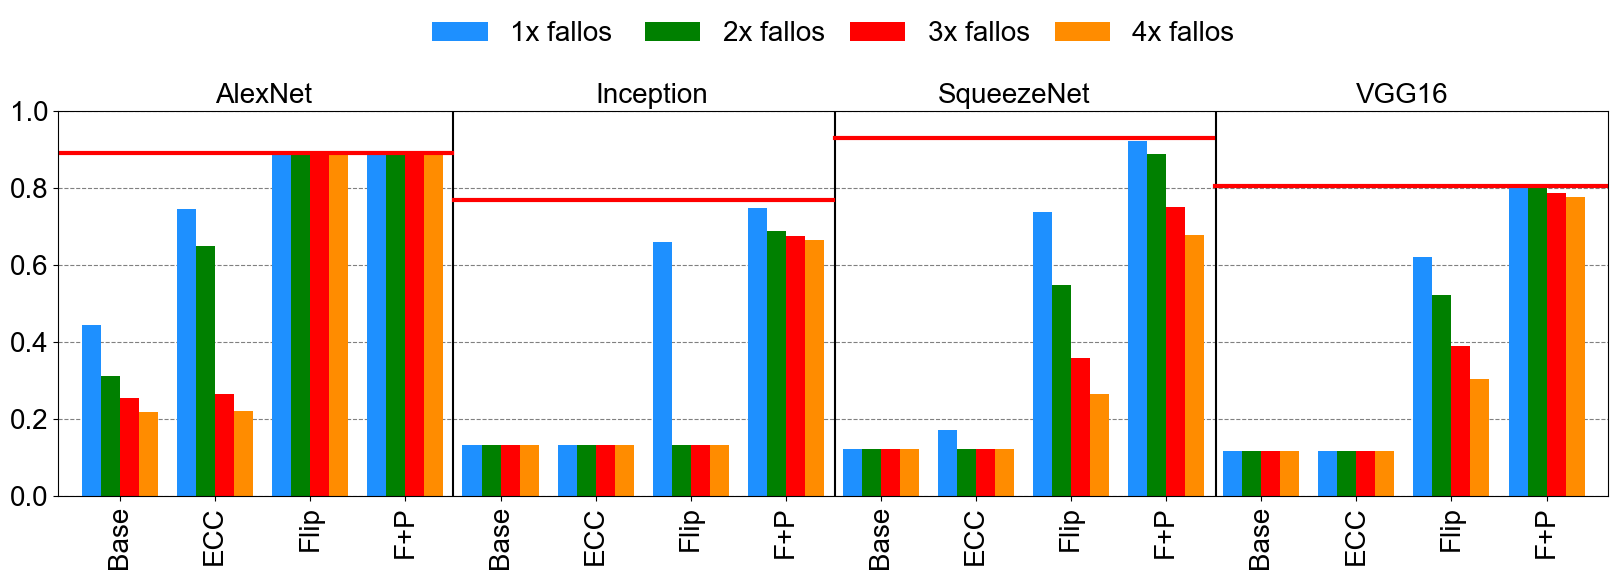

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns
import matplotlib as mpl  
mpl.rcParams['font.family']='Arial'

n = len(Resumen_mask_3_vbw16x.index)
x = np.arange(n)
#coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','green','red', 'darkorange']


Resumen_mask_3_vbw16x.plot(kind ='bar', width = 0.80, fontsize=20, color = coloresRedes, figsize=(20,5), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
lg = plt.legend( ['1x fallos ','2x fallos','3x fallos', '4x fallos'], fontsize=20,loc ="center", bbox_to_anchor=(0.50,1.2),shadow = True, ncol=4, columnspacing=0.9)
lg.draw_frame(False)
plt.ylim(0,1.0)
#plt.ylabel('Accuracy', fontsize=30, fontfamily="arial")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras


plt.axvline(x=3.5, ymax= 5, color="black")
plt.axvline(x=7.52, ymax= 5, color="black")
plt.axvline(x=11.52, ymax= 5, color="black")
#plt.axvline(x=13.5, ymax= 5, color="black")
#plt.axvline(x=24.5, ymax= 5, color="black")

plt.axhline(y=0.8907, xmax= 0.254,linewidth=3,color="red") #'AlexNet'
plt.axhline(y=0.7680, xmin=0.255, xmax= 0.5, linewidth=3,color="red")#Incept
plt.axhline(y=0.9307, xmin=0.501, xmax= 0.745, linewidth=3, color="red")#Squez
plt.axhline(y=0.805, xmin=0.7462, xmax= 1,linewidth=3,color="red")# VGG16
#plt.axhline(y=0.82, xmin=0.7966, xmax=1,linewidth=3, color="red")#ResNet
#plt.axhline(y=0.7966, xmin=0.9966, xmax= 1,linewidth=3,color="red")# Squez
#plt.axhline(y=0.805, xmin=0.203, xmax= 0.4, linewidth=3,color="red")#VGG16
#plt.axhline(y=0.9440, xmin=0.402, xmax= 0.5999, linewidth=3, color="red")#VGG19
#plt.axhline(y=0.9040,xmin=0.5999, xmax= 0.7966,linewidth=3,color="red") #'Xception'
#plt.axhline(y=0.8333, xmin=0.7966,  xmax= 1,   linewidth=3, color="red")#ZFNet
#


plt.xlabel('')
plt.xticks(x, Resumen_mask_3_vbw16x.index, fontsize= 20, fontfamily="arial")
plt.xticks(rotation = 90)
plt.yticks(fontsize= 20,fontfamily="arial")
plt.text(1.0, 1.02, 'AlexNet', fontsize=20, fontfamily="arial")
plt.text(5, 1.02, 'Inception', fontsize=20, fontfamily="arial")
plt.text(8.6, 1.02, 'SqueezeNet', fontsize=20, fontfamily="arial")
plt.text(13, 1.02, 'VGG16', fontsize=20, fontfamily="arial")


#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '93.07 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '80.53 %', fontsize=20, fontfamily="serif")
#plt.text(26.4, 0.85, '83.33 %', fontsize=20, fontfamily="serif")


plt.savefig('Resumen_acc_exp_mascaras_F+P_modificado_rectificado.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

In [ ]:
plt.text(0.4, 1.05, 'AlexNet', fontsize=22, fontfamily="serif")
plt.text(3.2, 1.05, 'DenseNet', fontsize=22, fontfamily="serif")
plt.text(6.2, 1.05, 'Inception', fontsize=22, fontfamily="serif")
plt.text(9.4, 1.05, 'MobileNet', fontsize=22, fontfamily="serif")
plt.text(12.2, 1.05, 'ResNet', fontsize=22, fontfamily="serif")
plt.text(15.5, 1.05, 'SqueezeNet', fontsize=22, fontfamily="serif")
plt.text(18.4, 1.05, 'VGG', fontsize=22, fontfamily="serif")
plt.text(21.5, 1.05, 'Xception', fontsize=22, fontfamily="serif")
plt.text(24.4, 1.05, 'ZFNet', fontsize=22, fontfamily="serif")

In [ ]:
ax1.plot(acc_correc_bits["Acc_Alex"], label='AlexNet', color='r', ls='-', lw=l, marker='s', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Dense"], label='DenseNet', color="blueviolet", ls='-', lw=l, marker='D', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Mobile"], label='MobileNet', color="m", ls='-', lw=l, marker='P', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Sque"], label='SqueezeNet', color="b", ls='-', lw=l, marker='^', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_VGG16"], label='VGG16', color="g", ls='-', lw=l, marker='<', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_ZFNet"], label='ZFNet', color="c", ls='-', lw=l, mark

In [289]:
Gráfica_general_técnicas_redes=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/diferencias_softmax/Prueba_softmax_Redes.xlsx',sheet_name='Resumen')
Resumen_softmax= Gráfica_general_técnicas_redes.set_index("Redes")

In [290]:
Resumen_softmax

,Baseline,Iso-area ECC,ECC,Flip,Flip+Patch
Redes,,,,,
Alex,0.972243,0.857152,0.411888,0.001919,0.001452
Dense,0.501612,0.433701,0.082774,0.010199,0.009472
Mobile,1.712994,1.708563,0.852503,0.071599,0.062368
Squeeze,1.749281,1.749275,1.654127,0.457156,0.077669
VGG,1.529435,1.529435,1.529433,0.473022,0.023040
ZF,1.734443,1.733423,1.244076,0.207653,0.013736


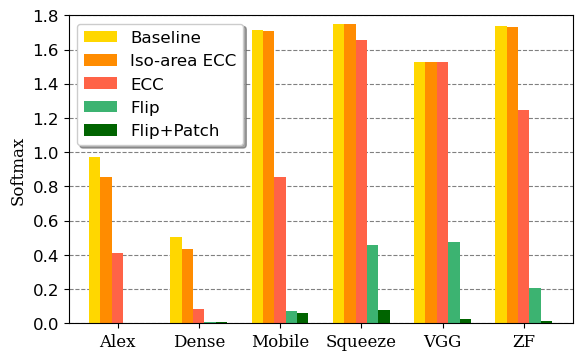

In [335]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_softmax.index)
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
#fig = plt.figure(figsize=(15,5), dpi=100)

Resumen_softmax.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=12,loc='upper left', shadow = True)
#plt.yticks(range(0,1.80,1))
plt.ylim(0,1.80)
plt.ylabel('Softmax', fontsize=12, fontfamily="serif")
xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, Resumen_softmax.index, fontsize= 12, fontfamily="serif")
plt.xticks(rotation = 0)

plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.savefig('Resumen_softmax.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()



# colocar redes en el eje x parecido a la fig 7

In [33]:
import pandas as pd
energía=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/energía/Eventos energía_xRedes_ruben_finalok.xlsx',sheet_name='Hoja3', )
energía=energía.set_index("vol")

In [34]:
energía

,Unnamed: 0,Leakage,Leakage Ovh,Read,Read Ovh,Write,Write Ovh
vol,,,,,,,
DVS,AlexNet,0.057819,0.000000,0.941993,0.000000,0.000187,0.000000
Thu,NaN,0.052104,0.000000,0.797637,0.000000,0.000171,0.000000
F+P,NaN,0.049530,0.004168,0.725343,0.075667,0.000136,0.000016
DVS,DenseNet,0.902830,0.000000,0.074334,0.000000,0.022836,0.000000
Thu,NaN,0.820213,0.000000,0.096386,0.000000,0.018319,0.000000
F+P,NaN,0.773504,0.065095,0.057238,0.005972,0.016512,0.001950
DVS,MobileNet,0.761471,0.000000,0.225966,0.000000,0.012563,0.000000
Thu,NaN,0.740583,0.000000,0.211674,0.000000,0.012256,0.000000
F+P,NaN,0.652367,0.054900,0.173996,0.018151,0.009083,0.001072


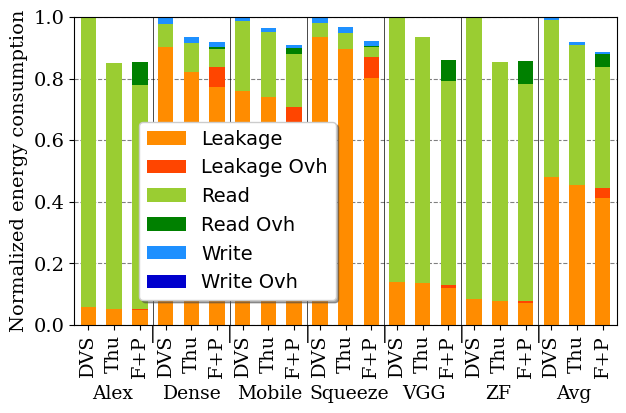

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(energía.index)
x = np.arange(n)
coloresRedes = ['darkorange','orangered','yellowgreen','green',  'dodgerblue','mediumblue']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
#fig = plt.figure(figsize=(15,5), dpi=100)

energía.plot(kind ='bar', stacked=True, width = 0.60, fontsize=12, color = coloresRedes,
                       figsize=(7,4), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.hlines(3,2,5,color="red")
plt.legend(  fontsize=14,bbox_to_anchor=(0.5,0.05), shadow = True)
#plt.yticks(range(0,1.80,1))
plt.ylim(0,1)
plt.ylabel('Normalized energy consumption', fontsize=14, fontfamily="serif")
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, energía.index, fontsize= 14, fontfamily="serif")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0.0', '0.2', '0.4', '0.6','0.8','1.0'),fontsize= 14,fontfamily="serif")
plt.xticks(rotation = 90)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')

plt.text(2.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(5.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(8.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(11.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(14.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(17.4, -0.046, '|', fontsize=12, fontfamily="serif")

plt.axvline(x=2.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=5.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=8.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=11.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=14.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=17.5, ymax= 1, color="black", linewidth=0.5)







plt.text(0.15, -0.24, 'Alex', fontsize=13.5, fontfamily="serif")
plt.text(2.90, -0.24, 'Dense', fontsize=13.5, fontfamily="serif")
plt.text(5.8, -0.24, 'Mobile', fontsize=13.5, fontfamily="serif")
plt.text(8.6,-0.24, 'Squeeze', fontsize=13.5, fontfamily="serif")
plt.text(12.2, -0.24, 'VGG', fontsize=13.5, fontfamily="serif")
plt.text(15.45, -0.24, 'ZF', fontsize=13.5, fontfamily="serif")
plt.text(18.2, -0.24, 'Avg', fontsize=13.5, fontfamily="serif")
plt.savefig('energia_Thunder.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)





In [3]:
energía_ppt

,DVS,F+P
Redes,,
Alex,1.0,0.854860
Dense,1.0,0.920269
Mobile,1.0,0.909571
Squeeze,1.0,0.922917
VGG16,1.0,0.861227
ZF,1.0,0.856893
Avg,1.0,0.887623


In [17]:
import pandas as pd
energía_ppt=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/energía/Eventos energía_xRedes_ruben_finalok.xlsx',sheet_name='graf_congreso_unizar_2024', )
energía_ppt=energía_ppt.set_index("Redes")

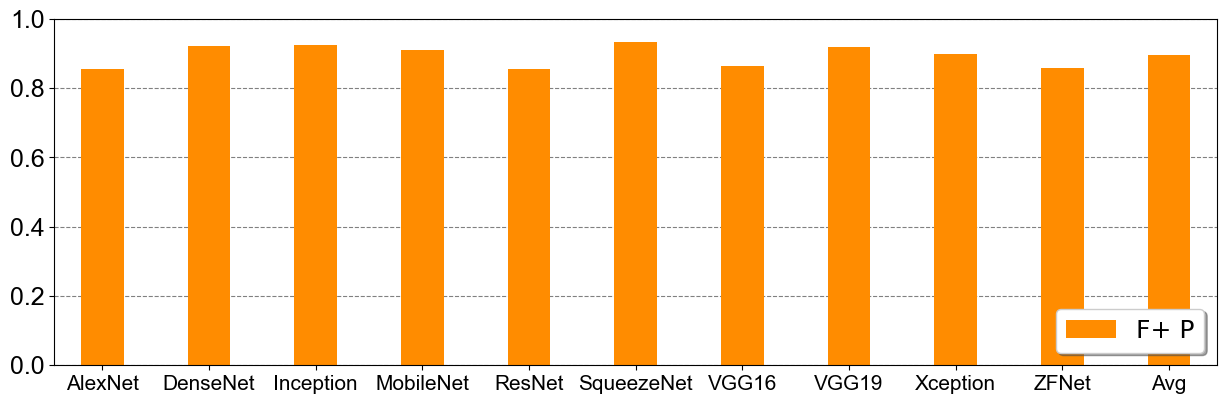

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(energía_ppt.index)
x = np.arange(n)
coloresRedes = [  'darkorange']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
#fig = plt.figure(figsize=(15,5), dpi=100)




energía_ppt.plot(kind ='bar', stacked=False, width = 0.40, color = coloresRedes,
                       figsize=(15,4.5), zorder=2 );
plt.legend(fontsize=18, loc ="lower right", shadow = True)
plt.hlines(3,2,5,color="red")
#plt.legend( fontsize=14,bbox_to_anchor=(0.836,0.85), shadow = True)
#plt.legend( fontsize=14,bbox_to_anchor=(1,1), shadow = False)
#plt.yticks(range(0,1.80,1))
plt.ylim(0,1)
#plt.ylabel('Normalized energy consumption', fontsize=18, fontfamily="arial")
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, energía_ppt.index, fontsize= 15, fontfamily="arial")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0.0', '0.2', '0.4', '0.6','0.8','1.0'),fontsize= 18,fontfamily="arial")
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')

#plt.text(1.45, -0.046, '|', fontsize=12, fontfamily="serif")
#plt.text(3.45, -0.046, '|', fontsize=12, fontfamily="serif")
#plt.text(5.45, -0.046, '|', fontsize=12, fontfamily="serif")
#plt.text(7.45, -0.046, '|', fontsize=12, fontfamily="serif")
#plt.text(9.45, -0.046, '|', fontsize=12, fontfamily="serif")
#plt.text(11.5, -0.046, '|', fontsize=12, fontfamily="serif")
#
#plt.axvline(x=1.5, ymax= 1, color="black", linewidth=0.5)
#plt.axvline(x=3.5, ymax= 1, color="black", linewidth=0.5)
#plt.axvline(x=5.5, ymax= 1, color="black", linewidth=0.5)
#plt.axvline(x=7.5, ymax= 1, color="black", linewidth=0.5)
#plt.axvline(x=9.5, ymax= 1, color="black", linewidth=0.5)
#plt.axvline(x=11.5, ymax= 1, color="black", linewidth=0.5)


#plt.text(0.08, -0.30, 'Alex', fontsize=18, fontfamily="arial")
#plt.text(1.7, -0.30, 'Dense', fontsize=18, fontfamily="arial")
#plt.text(3.6, -0.30, 'Mobile', fontsize=18, fontfamily="arial")
#plt.text(5.5,-0.30, 'Squeeze', fontsize=18, fontfamily="arial")
#plt.text(7.9, -0.30, 'VGG', fontsize=18, fontfamily="arial")
#plt.text(10.1, -0.30, 'ZF', fontsize=18, fontfamily="arial")
#plt.text(12, -0.30, 'Avg', fontsize=18, fontfamily="arial")
plt.savefig('energia_esp_ppt.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)




In [23]:
pwd

'C:\\Users\\usuario\\Desktop\\CNN_Gating'

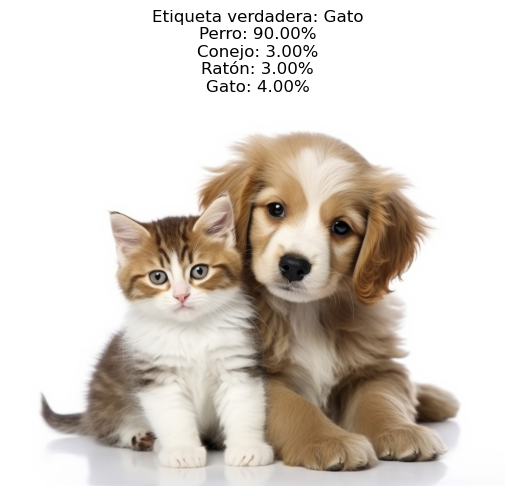

In [27]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Función para mostrar una imagen con las probabilidades predichas
def show_image_with_predictions(image_path, true_label, predicted_probabilities, class_names):
    # Cargar la imagen
    image = Image.open(image_path)
    
    # Crear la figura y los ejes
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.axis('off')  # No mostrar los ejes
    
    # Crear el título con las probabilidades predichas
    title = f'Etiqueta verdadera: {true_label}\n'
    for i, class_name in enumerate(class_names):
        title += f'{class_name}: {predicted_probabilities[i]*100:.2f}%\n'
    
    # Establecer el título
    ax.set_title(title, fontsize=12)
    plt.show()

# Ejemplo de uso
# Ruta de la imagen del gato
image_path = 'imagenes/cat_dog.jpg'  # Reemplaza con la ruta a tu imagen de gato

# Etiqueta verdadera y probabilidades predichas
true_label = 'Gato'
predicted_probabilities = [0.9, 0.03, 0.03, 0.04]  # Probabilidades simuladas (80% de que no sea un gato)
class_names = ['Perro', 'Conejo', 'Ratón', 'Gato']

show_image_with_predictions(image_path, true_label, predicted_probabilities, class_names)

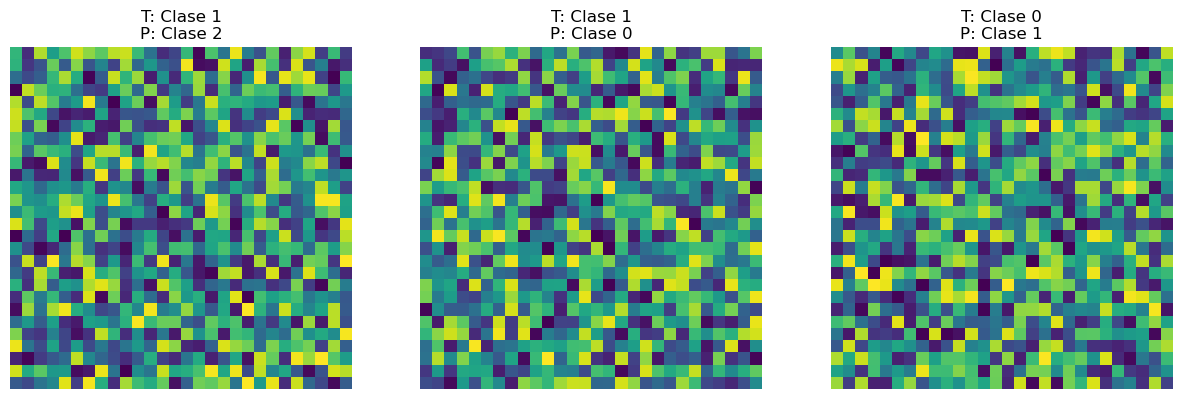

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar imágenes mal clasificadas
def plot_misclassified_images(images, y_true, y_pred, class_names):
    misclassified_indices = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
    num_images = len(misclassified_indices)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    if num_images == 0:
        print("No hay imágenes mal clasificadas.")
        return

    for i, idx in enumerate(misclassified_indices):
        axes[i].imshow(images[idx])
        axes[i].set_title(f'T: {class_names[y_true[idx]]}\nP: {class_names[y_pred[idx]]}')
        axes[i].axis('off')
    plt.show()

# Ejemplo de uso
# Supongamos que tienes las imágenes, las etiquetas verdaderas y las etiquetas predichas
# Aquí 'images' es una lista o array de imágenes, 'y_true' son las etiquetas verdaderas y 'y_pred' son las etiquetas predichas
images = [np.random.rand(28, 28) for _ in range(8)]  # Ejemplo de imágenes aleatorias (28x28 píxeles)
y_true = [0, 1, 2, 2, 0, 1, 0, 2]
y_pred = [0, 2, 2, 2, 0, 0, 1, 2]
class_names = ['Clase 0', 'Clase 1', 'Clase 2']

plot_misclassified_images(images, y_true, y_pred, class_names)

In [3]:
import pandas as pd
energía_final=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/energía/Eventos energía_xRedes_ruben_finalok.xlsx',sheet_name='Energía_final', )
energía_final=energía_final.set_index("vol")

In [4]:
energía_final

,Unnamed: 0,Leakage,Leakage Ovh,Read,Read Ovh,Write,Write Ovh
vol,,,,,,,
DVS,AlexNet,0.057819,0.000000,0.941993,0.000000,0.000187,0.000000
iTUV,NaN,0.053267,0.000000,0.833328,0.000000,0.000178,0.000000
F+P,NaN,0.049530,0.004862,0.725343,0.075667,0.000136,0.000016
DVS,DenseNet,0.807113,0.000000,0.172472,0.000000,0.020415,0.000000
iTUV,NaN,0.743773,0.000000,0.149762,0.000000,0.011285,0.000000
F+P,NaN,0.691498,0.067886,0.132805,0.013855,0.014761,0.001743
DVS,Inception,0.822693,0.000000,0.173566,0.000000,0.003741,0.000000
iTUV,NaN,0.765328,0.000000,0.154109,0.000000,0.003245,0.000000
F+P,NaN,0.704740,0.069186,0.133647,0.013942,0.002705,0.000319


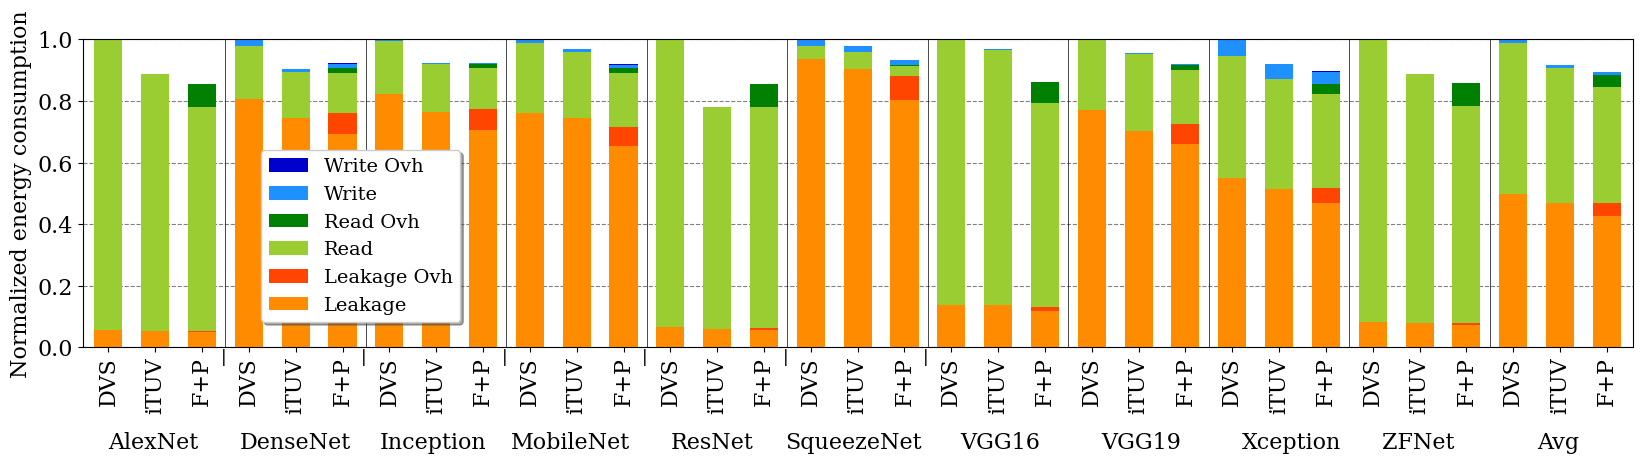

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(energía_final.index)
x = np.arange(n)
coloresRedes = ['darkorange','orangered','yellowgreen','green',  'dodgerblue','mediumblue']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
#fig = plt.figure(figsize=(15,5), dpi=100)

energía_final.plot(kind ='bar', stacked=True, width = 0.60, fontsize=12, color = coloresRedes,  figsize=(20,4), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
#plt.hlines(3,2,5,color="red")
#plt.legend( fontsize=14,bbox_to_anchor=(0.18,0.05),shadow = True)
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [5,4,3,2,1,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=14,loc ="lower right",bbox_to_anchor=(0.25,0.05),shadow = True)


#lg.draw_frame(False)
plt.ylim(0,1)
plt.ylabel('Normalized energy consumption', fontsize=16, fontfamily="serif")
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, energía_final.index, fontsize= 16, fontfamily="serif")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0.0', '0.2', '0.4', '0.6','0.8','1.0'), fontsize= 16, fontfamily="serif")
plt.xticks(rotation = 90,fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')

plt.text(2.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(5.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(8.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(11.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(14.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(17.4, -0.046, '|', fontsize=12, fontfamily="serif")

plt.axvline(x=2.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=5.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=8.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=11.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=14.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=17.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=20.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=23.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=26.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=29.5, ymax= 1, color="black", linewidth=0.5)




plt.text(0, -0.33, 'AlexNet', fontsize=16, fontfamily="serif")
plt.text(2.8, -0.33, 'DenseNet', fontsize=16, fontfamily="serif")
plt.text(5.8, -0.33, 'Inception', fontsize=16, fontfamily="serif")
plt.text(8.6,-0.33, 'MobileNet', fontsize=16, fontfamily="serif")
plt.text(12, -0.33, 'ResNet', fontsize=16, fontfamily="serif")
plt.text(14.46, -0.33, 'SqueezeNet', fontsize=16, fontfamily="serif")
plt.text(18.2, -0.33, 'VGG16', fontsize=16, fontfamily="serif")
plt.text(21.2, -0.33, 'VGG19', fontsize=16, fontfamily="serif")
plt.text(24.2, -0.33, 'Xception', fontsize=16, fontfamily="serif")
plt.text(27.2, -0.33, 'ZFNet', fontsize=16, fontfamily="serif")
plt.text(30.5, -0.33, 'Avg', fontsize=16, fontfamily="serif")
plt.savefig('energia_Thunder_all_nets_.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)


# energia español

In [14]:
import pandas as pd
energía_final_esp=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/energía/Eventos energía_xRedes_ruben_finalok.xlsx',sheet_name='Energía_final_esp', )
energía_final_esp=energía_final_esp.set_index("vol")

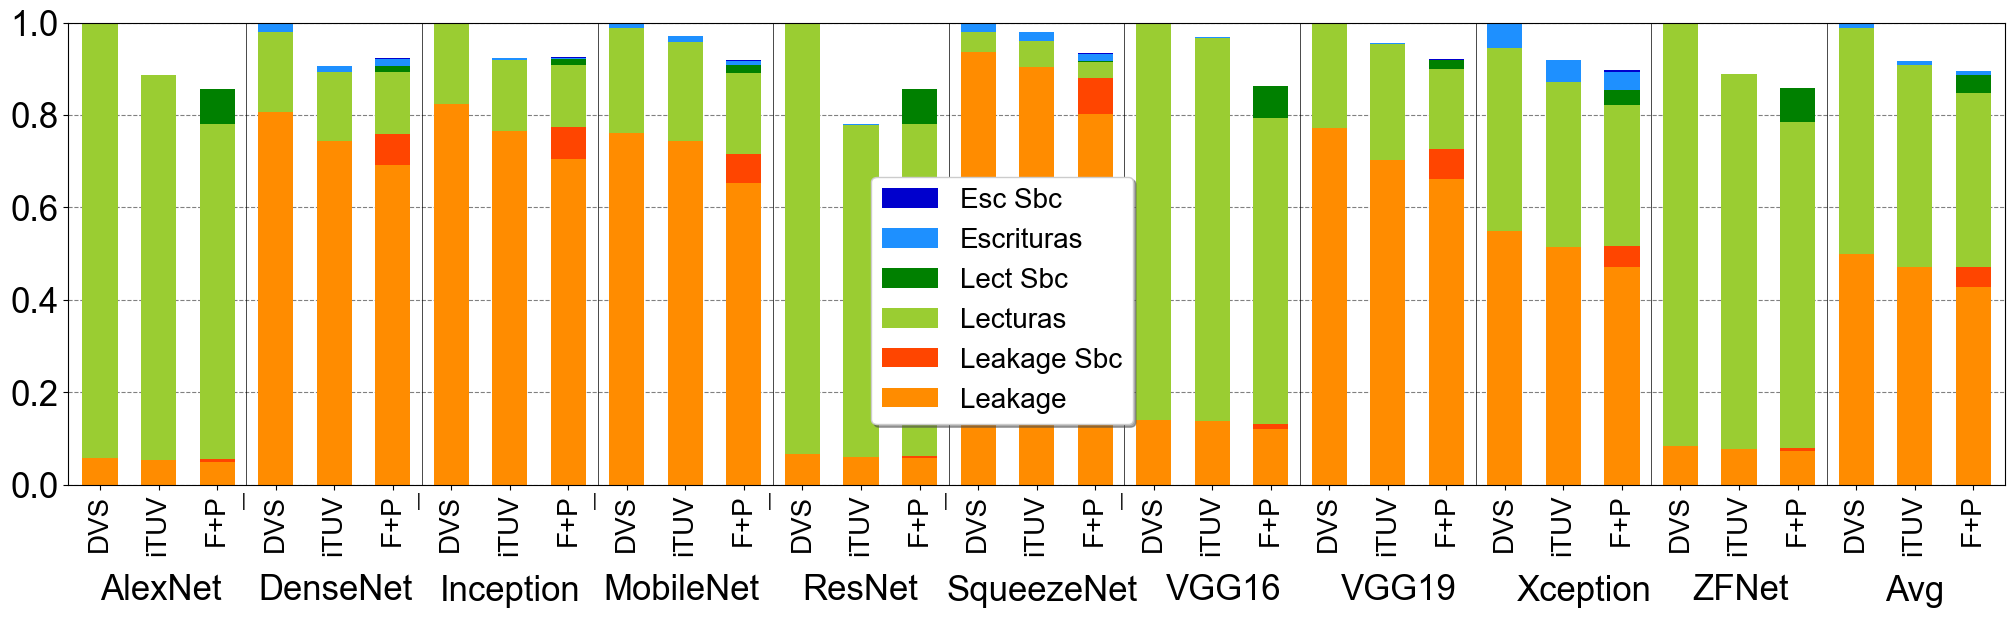

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import matplotlib as mpl 
mpl.rcParams['font.family']='Arial'
plt.rcParams["font.family"] = "Arial"

n = len(energía_final_esp.index)
x = np.arange(n)
coloresRedes = ['darkorange','orangered','yellowgreen','green',  'dodgerblue','mediumblue']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
#fig = plt.figure(figsize=(15,5), dpi=100)

energía_final_esp.plot(kind ='bar', stacked=True, width = 0.60, fontsize=20, color = coloresRedes,  figsize=(25,6), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
#plt.hlines(3,2,5,color="red")
#plt.legend( fontsize=14,bbox_to_anchor=(0.18,0.05),shadow = True)
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [5,4,3,2,1,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20,loc ="lower right",bbox_to_anchor=(0.557,0.1),shadow = True)
mpl.rcParams['font.family']='Arial'

#lg.draw_frame(False)
plt.ylim(0,1)
#plt.ylabel('Normalized energy consumption', fontsize=16, fontfamily="serif")
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, energía_final_esp.index, fontsize= 20, fontfamily="arial")

plt.yticks(np.arange(0, 1.02, step=0.2), ('0.0', '0.2', '0.4', '0.6','0.8','1.0'), fontsize= 25, fontfamily="arial")
plt.xticks(rotation = 90,fontfamily="arial")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')

plt.text(2.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(5.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(8.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(11.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(14.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(17.4, -0.046, '|', fontsize=12, fontfamily="serif")

plt.axvline(x=2.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=5.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=8.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=11.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=14.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=17.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=20.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=23.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=26.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=29.5, ymax= 1, color="black", linewidth=0.5)




plt.text(0, -0.25, 'AlexNet', fontsize=25, fontfamily="arial")
plt.text(2.7, -0.25, 'DenseNet', fontsize=25, fontfamily="arial")
plt.text(5.8, -0.25, 'Inception', fontsize=25, fontfamily="arial")
plt.text(8.6,-0.25, 'MobileNet', fontsize=25, fontfamily="arial")
plt.text(12, -0.25, 'ResNet', fontsize=25, fontfamily="arial")
plt.text(14.46, -0.25, 'SqueezeNet', fontsize=25, fontfamily="arial")
plt.text(18.2, -0.25, 'VGG16', fontsize=25, fontfamily="arial")
plt.text(21.2, -0.25, 'VGG19', fontsize=25, fontfamily="arial")
plt.text(24.2, -0.25, 'Xception', fontsize=25, fontfamily="arial")
plt.text(27.2, -0.25, 'ZFNet', fontsize=25, fontfamily="arial")
plt.text(30.5, -0.25, 'Avg', fontsize=25, fontfamily="arial")
plt.savefig('energia_Thunder_all_nets_esp.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)


# energia Poster

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(energía.index)
x = np.arange(n)
coloresRedes = ['darkorange','orangered','yellowgreen','green',  'dodgerblue','mediumblue']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
#fig = plt.figure(figsize=(15,5), dpi=100)

energía.plot(kind ='bar', stacked=True, width = 0.60, fontsize=14, color = coloresRedes,
                       figsize=(8,4), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.hlines(3,2,5,color="red")
plt.legend(  fontsize=16,bbox_to_anchor=(0.5,0.05), shadow = True)
#plt.yticks(range(0,1.80,1))
plt.ylim(0,1)
plt.ylabel('Normalized energy consumption', fontsize=14, fontfamily="serif")
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, energía.index, fontsize= 14, fontfamily="serif")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0.0', '0.2', '0.4', '0.6','0.8','1.0'),fontsize= 14, fontfamily="serif")
plt.xticks(rotation = 90)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')

plt.text(2.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(5.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(8.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(11.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(14.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(17.4, -0.046, '|', fontsize=12, fontfamily="serif")

plt.axvline(x=2.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=5.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=8.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=11.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=14.5, ymax= 1, color="black", linewidth=0.5)
plt.axvline(x=17.5, ymax= 1, color="black", linewidth=0.5)


plt.text(0.25, 1.02, 'Alex', fontsize=14, fontfamily="serif")
plt.text(3.2, 1.02, 'Dense', fontsize=14, fontfamily="serif")
plt.text(6, 1.02, 'Mobile', fontsize=14, fontfamily="serif")
plt.text(8.6,1.02, 'Squeeze', fontsize=14, fontfamily="serif")
plt.text(12.3, 1.02, 'VGG', fontsize=14, fontfamily="serif")
plt.text(15.8, 1.02, 'ZF', fontsize=14, fontfamily="serif")
plt.text(18.3, 1.02, 'Avg', fontsize=14, fontfamily="serif")
plt.savefig('energia_Thunder_poster.TIFF', transparent = True, bbox_inches = 'tight', pad_inches = 0)






NameError: name 'energía' is not defined

### VARIOS VOLTAJESS

In [73]:
voltajes_redes=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/Resumen_acc_exp_todos los voltajes_y redes.xlsx',sheet_name='graficar')
voltajes_redes= voltajes_redes.set_index("voltajes")

In [74]:
voltajes_redes

,Base,I-A ECC,ECC,Flip,F+P
voltajes,,,,,
0.58,1.000000,1.000000,1.000000,1.000000,1.000000
0.56,0.844311,0.850299,1.005988,1.000000,1.000000
0.54,0.500000,0.582335,0.836826,1.000000,1.000000
0.58,0.998544,1.000000,1.000000,1.000000,1.000000
0.56,1.000000,1.000000,1.002911,1.000000,1.000000
0.54,0.720524,0.777293,0.994178,0.998544,1.000000
0.58,1.015625,1.000000,1.000000,1.036458,1.036458
0.56,0.171875,0.171875,0.171875,0.989583,0.989583
0.54,0.171875,0.171875,0.171875,0.859375,0.973958


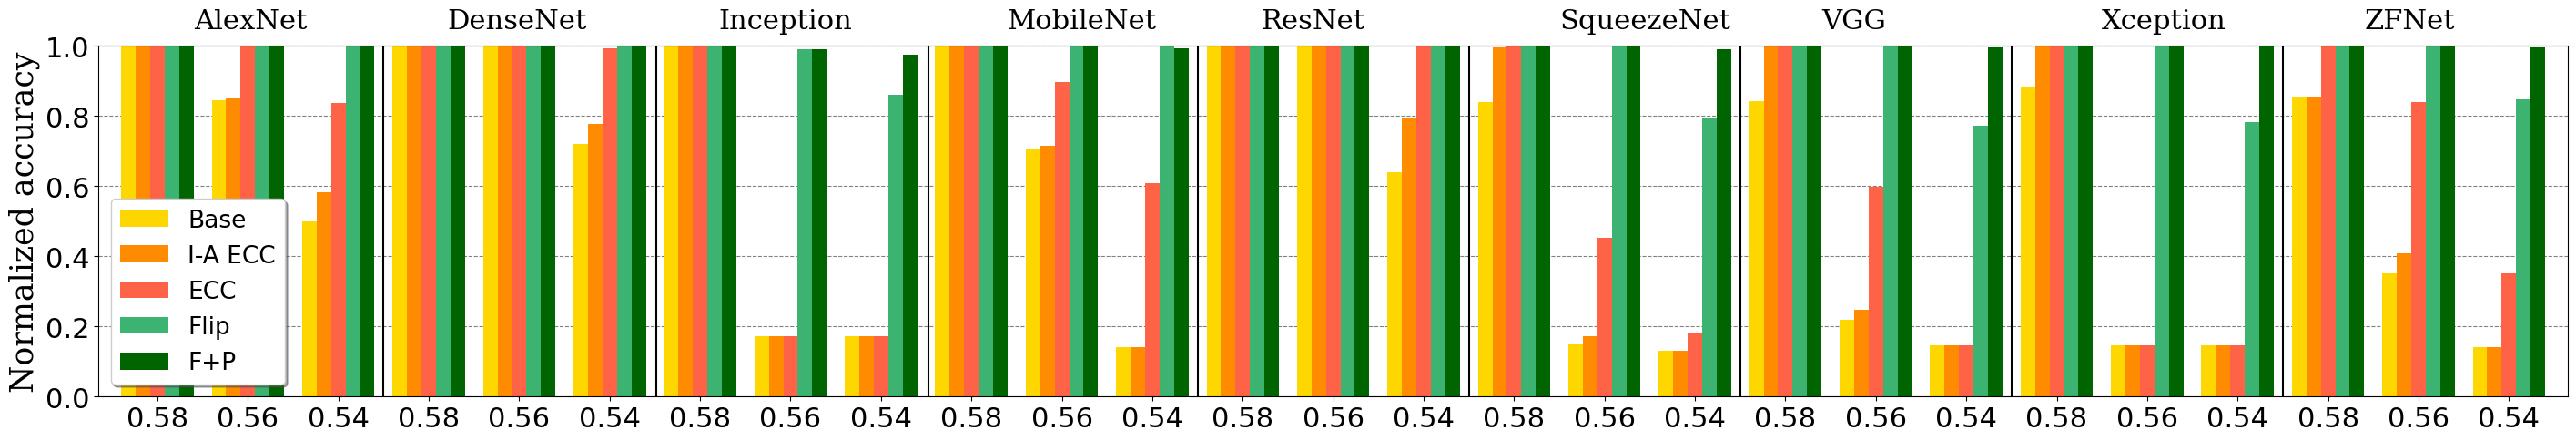

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns

n = len(voltajes_redes.index)
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']



voltajes_redes.plot(kind ='bar',width = 0.80, fontsize=22, color = coloresRedes, figsize=(35,5), zorder=2 );
#Error_by_layer.plot( kind='bar', stacked=True, figsize=(10,5), zorder=2 )
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
#plt.legend(  fontsize=19, bbox_to_anchor=(0.75,0.1),shadow = True)
plt.legend(  fontsize=19, loc='lower left',shadow = True)

plt.ylim(0,1.0)
plt.ylabel('Normalized accuracy', fontsize=25, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras


plt.axvline(x=2.5, ymax= 5, color="black")
plt.axvline(x=5.52, ymax= 5, color="black")
plt.axvline(x=8.52, ymax= 5, color="black")
plt.axvline(x=11.5, ymax= 5, color="black")
plt.axvline(x=14.5, ymax= 5, color="black")
plt.axvline(x=17.5, ymax= 5, color="black")
plt.axvline(x=20.5, ymax= 5, color="black")
plt.axvline(x=23.5, ymax= 5, color="black")

#plt.axhline(y=0.8907, xmax= 0.17,             linewidth=3,color="red") #'AlexNet'
#plt.axhline(y=0.9133, xmin=0.17, xmax= 0.336, linewidth=3,color="red")#DenseNet
#plt.axhline(y=0.8813, xmin=0.336, xmax= 0.50, linewidth=3, color="red")#MobileNet
#plt.axhline(y=0.9307, xmin=0.502, xmax= 0.665,linewidth=3,color="red")# SqueezeNet
#plt.axhline(y=0.8053, xmin=0.665, xmax= 0.83,linewidth=3, color="red")#VGG
#plt.axhline(y=0.8333, xmin=0.83,  xmax= 1,   linewidth=3, color="red")#ZFNet


plt.xlabel('')
#plt.xticks(x, voltajes_redes_index.index, fontsize= 25, fontfamily="serif")
plt.xticks(rotation = 0)
plt.text(0.4, 1.05, 'AlexNet', fontsize=22, fontfamily="serif")
plt.text(3.2, 1.05, 'DenseNet', fontsize=22, fontfamily="serif")
plt.text(6.2, 1.05, 'Inception', fontsize=22, fontfamily="serif")
plt.text(9.4, 1.05, 'MobileNet', fontsize=22, fontfamily="serif")
plt.text(12.2, 1.05, 'ResNet', fontsize=22, fontfamily="serif")
plt.text(15.5, 1.05, 'SqueezeNet', fontsize=22, fontfamily="serif")
plt.text(18.4, 1.05, 'VGG', fontsize=22, fontfamily="serif")
plt.text(21.5, 1.05, 'Xception', fontsize=22, fontfamily="serif")
plt.text(24.4, 1.05, 'ZFNet', fontsize=22, fontfamily="serif")


#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '93.07 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '80.53 %', fontsize=20, fontfamily="serif")
#plt.text(26.4, 0.85, '83.33 %', fontsize=20, fontfamily="serif")


plt.savefig('voltajes_redes_ampliada.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()


In [ ]:
#Para presentación

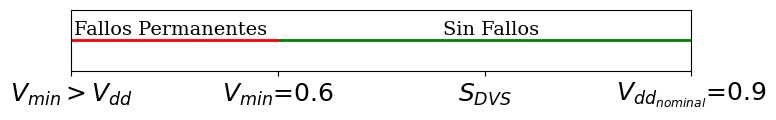

In [4]:
import matplotlib.pyplot as plt
#x="${V_{min} > V_{dd}}$","$V_{min}$=0.6", "$S_{EDT}$", "$V_{dd_{nominal}}$=0.9"
x="${V_{min} > V_{dd}}$","$V_{min}$=0.6", "$S_{DVS}$", "$V_{dd_{nominal}}$=0.9"
plt.figure(figsize=(8,0.8))
plt.ylim(0,1)
#ax = plt.axes()
#ax.spines['left'].set_visible(False)
x_values = range(len(x))
#plt.axis('off')

plt.yticks([])
plt.xticks(x_values, x, fontsize=18)
plt.axhline(y=0.5, xmin=0, xmax= 0.336, linewidth=2,color="red")#DenseNet
plt.axhline(y=0.5, xmin=0.336, xmax= 1, linewidth=2,color="g")#DenseNet
#plt.legend(  fontsize=12, shadow = True)
plt.text(1.80, 0.6, 'Sin Fallos', fontsize=14, fontfamily="serif")
plt.text(0.01, 0.6, 'Fallos Permanentes', fontsize=14, fontfamily="serif")
plt.savefig('DVS_esp.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

  
# rendering the plot
plt.show()

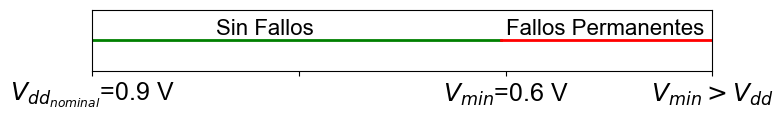

In [9]:
import matplotlib.pyplot as plt
#x="${V_{min} > V_{dd}}$","$V_{min}$=0.6", "$S_{EDT}$", "$V_{dd_{nominal}}$=0.9"
x= "$V_{dd_{nominal}}$=0.9 V", " ","$V_{min}$=0.6 V","${V_{min} > V_{dd}}$"
#x= "", "","","${V_{min} > V_{dd}}$"
plt.figure(figsize=(8,0.8))
plt.ylim(0,1)
#ax = plt.axes()
#ax.spines['left'].set_visible(False)
x_values = range(len(x))
#plt.axis('off')

plt.yticks([])
plt.xticks(x_values, x, fontsize=18, fontfamily="arial")
plt.axhline(y=0.5, xmin=0, xmax= 0.66, linewidth=2,color="g")#DenseNet
plt.axhline(y=0.5, xmin=0.66, xmax= 1, linewidth=2,color="red")#DenseNet
#plt.legend(  fontsize=12, shadow = True)
plt.text(2, 0.6, 'Fallos Permanentes', fontsize=16, fontfamily="arial")
plt.text(0.6, 0.6, 'Sin Fallos', fontsize=16, fontfamily="arial")
plt.savefig('DVS_congres.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

  
# rendering the plot
plt.show()

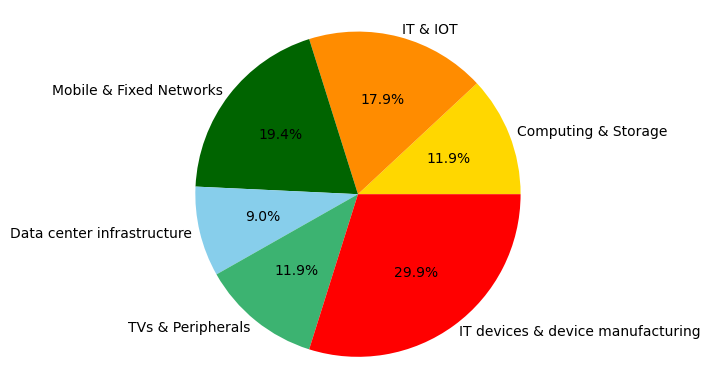

In [138]:
import matplotlib.pyplot as plt
textprops = {"fontsize":20}
TWh = [400 ,600,650,300,400,1000]
nombres = ['Computing & Storage', 'IT & IOT', 'Mobile & Fixed Networks', 'Data center infrastructure',
'TVs & Peripherals', 'IT devices & device manufacturing']
colors = ['gold', 'darkorange','darkgreen','skyblue','mediumseagreen',  'red']
plt.pie(TWh, labels=nombres , pctdistance=0.6,labeldistance = 1.05,colors= colors, radius = 1.1,  autopct = '%1.1f%%')
plt.savefig('DVS.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

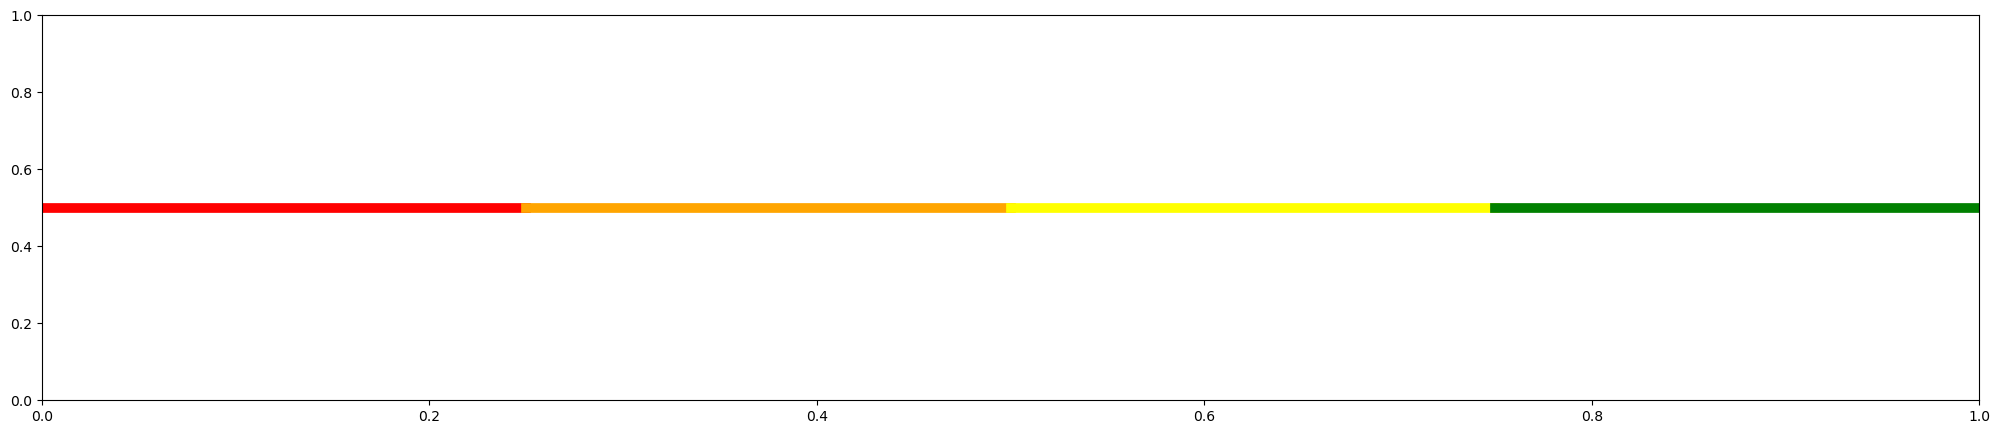

In [113]:
import matplotlib.pyplot as plt
#x="${V_{min} > V_{dd}}$","$V_{min}$=0.6", "$S_{EDT}$", "$V_{dd_{nominal}}$=0.9"
plt.figure(figsize=(25,5))
#plt.ylim(0,1)
#plt.xlim(0,4)
#ax = plt.axes()
#ax.spines['left'].set_visible(False)
#x_values = range(len(x))
#plt.axis('off')

#plt.yticks([])
#plt.xticks(x_values, x)
plt.axhline(y=0.5, xmin=0, xmax= 0.25, linewidth=7,color="red")
plt.axhline(y=0.5, xmin=0.25, xmax= 0.5, linewidth=7,color="orange")
plt.axhline(y=0.5, xmin=0.5, xmax= 0.75, linewidth=7,color="yellow")
plt.axhline(y=0.5, xmin=0.75, xmax= 1, linewidth=7,color="g")
#plt.legend(  fontsize=12, shadow = True)
#plt.text(1.45, 0.6, 'Sin Fallos Permanentes', fontsize=8, fontfamily="serif")
#plt.text(0.05, 0.6, 'Fallos Permanentes', fontsize=8, fontfamily="serif")

  
# rendering the plot
plt.show()

In [ ]:
matplotlib.pyplot.table(cellText=None, 
                        cellColours=None, 
                        cellLoc='right', 
                        colWidths=None, 
                        rowLabels=None, 
                        rowColours=None, 
                        rowLoc='left', 
                        colLabels=None, 
                        colColours=None, 
                        colLoc='center', 
                        loc='bottom', 
                        bbox=None, 
                        edges='closed', 
                        **kwargs)

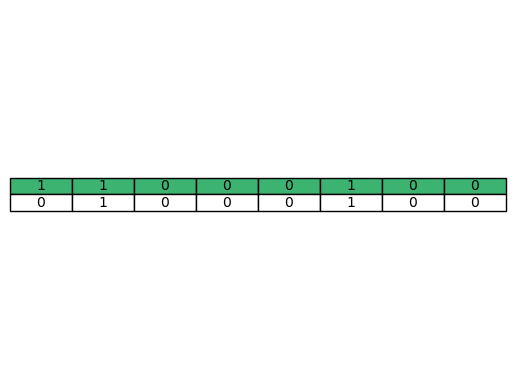

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen','r', 'gold', 'darkorange']



fig, ax =plt.subplots(1,1)
data=[[0,1,0,0,0,1,0,0]]
column_labels=["1", "1", "0","0","0","1","0","0"]
ax.axis('tight')
ax.axis('off')
ax.table(cellText=data,cellLoc='center',colColours =["mediumseagreen"] * 8,colLabels=column_labels,loc="center")

plt.show()


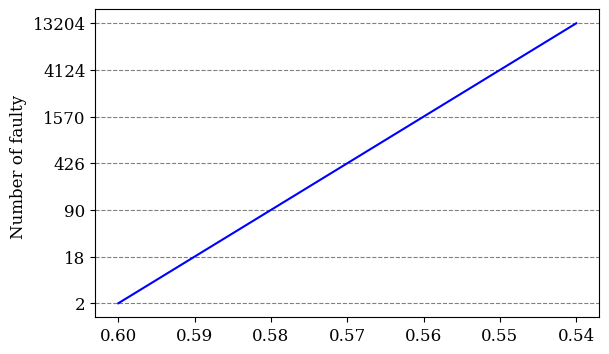

In [246]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile

fallos_xbits= ['2','18', '90','426','1570','4124','13204']
Vdd=['0.60', '0.59','0.58','0.57','0.56','0.55','0.54']

plt.rcParams.update({'font.size': 12})
fig1, ax1 = plt.subplots(figsize=(6.5,4))

x_values = range(len(Vdd))

#plt.xlabel('Vdd', fontsize=12,  fontfamily="serif")
plt.ylabel('Number of faulty ', fontsize=12, fontfamily="serif")
plt.xticks( fontsize=12, fontfamily="serif")
plt.yticks( fontsize=12, fontfamily="serif")


#ax1.set_ylim(0,1)
#ax1.set_title(" Accumulated bit errors")

ax1.plot(Vdd,fallos_xbits,color='b' )
#ax1.plot(df["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
#ax1.plot(fail_xbits["Acum_Base"], label='Convencional', color="orange", ls='-', lw=l, marker='s', markersize=marksize, zorder=2)
ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
#ax1.legend(fontsize=12, loc ="lower right")

#plt.savefig('Errores_bit_acumulados.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile=PdfPages("Accumulated_bit_errors.pdf")
#pdfFile=PdfPages("Errores_bit_acumulados.pdf")
#pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()




C:\Users\usuario\AppData\Local\Temp\ipykernel_13484\3732649229.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



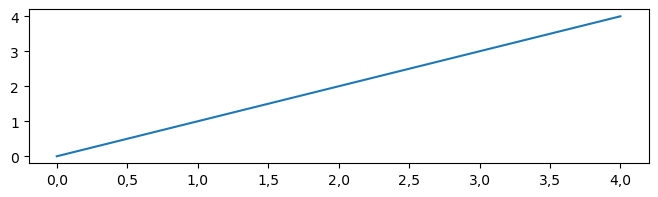

In [20]:
import matplotlib.pyplot as plt
from matplotlib import ticker

#fig, ax = plt.subplots(1, 1, figsize=(8, 2))
#ax.plot(range(0, 5), range(0, 5))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
#plt.show()
#
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.set_xticklabels(['0,0', '0,0', '0,5', '1,0', '1,5', '2,0', '2,5', '3,0', '3,5', '4,0',])
ax.plot(range(0, 5), range(0, 5))
plt.show()


# Diagrama de cajas y Bigotes

In [ ]:

mediana
Q1. mediana del grupo d enumeros menosres
Q2. mediana de todo el conjunto de numeros
Q3. mediana del grupo d enumeros mayores 
Donde la caja es mas ancha quiere decir que el rango entre los numeros es mayor para ese costado de la mediana
valor max
valor min
rango= valor max - valor min
rango_intercuartil(IQR):distancia entre los dos extremos de la caja
Q1 = 25 % valor donde comienza la caja
Q2 = 50%  valor de la mediana
Q3 = 75 % valor donde finaliza la caja
IQR= Q3-Q1



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors



In [143]:
AlexNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\AlexNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
AlexNet

,Base,I-A ECC,ECC,Flip,F + P
0,1.957557,1.957090,1.895195,0.000946,1.081649e-03
1,1.982833,1.957071,0.242701,0.000214,1.433329e-04
2,0.010073,0.012053,0.039729,0.000007,1.424039e-04
3,0.032458,0.032167,0.026965,0.000031,3.803965e-07
4,1.300976,0.568596,0.171837,0.005084,2.486014e-03
...,...,...,...,...,...
745,1.334329,1.040370,0.108300,0.000701,1.032325e-03
746,0.830131,0.875881,0.160765,0.000955,2.096470e-03
747,1.363894,1.260764,0.522994,0.003193,3.270345e-03
748,1.696105,1.840787,0.709911,0.001856,2.180753e-03


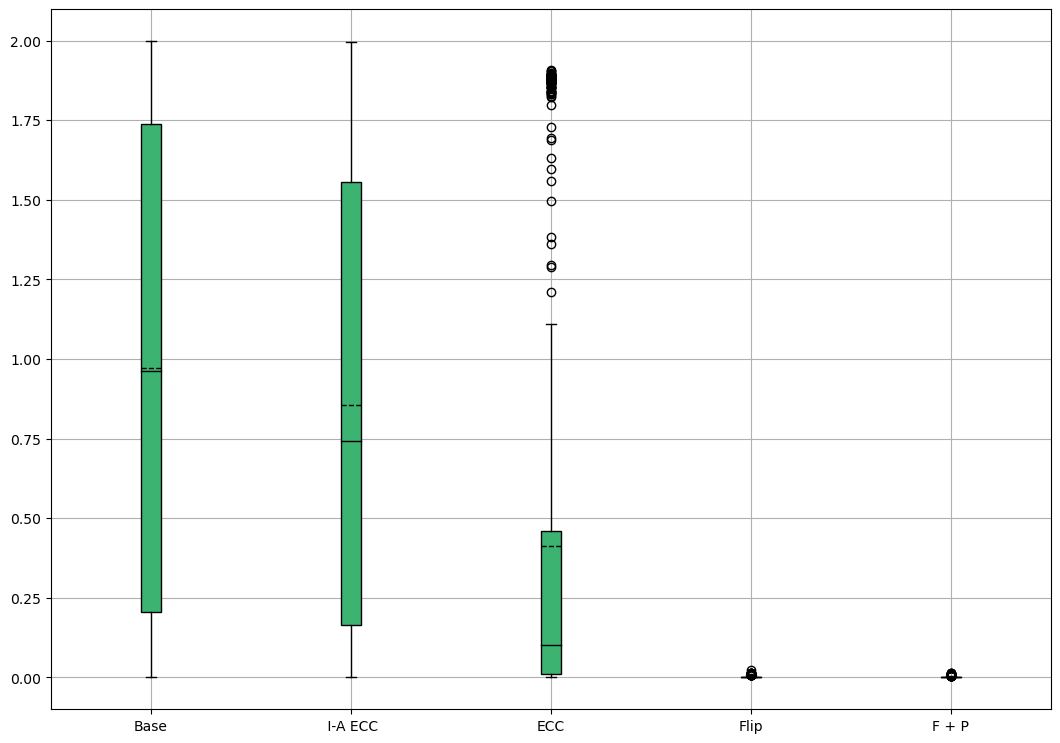

In [146]:

 
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
#fig.set_size_inches(4, 3)
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
bplot=ax.boxplot(AlexNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = True,
                 boxprops = dict(facecolor = "mediumseagreen"),
                 medianprops = dict(color = "black", linewidth = 1),
                 widths = 0.1,
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=True)
plt.grid(True)
#bplot=plt.boxplot(data)
#outliers_ECC = bplot["fliers"][2].get_ydata()
#outliers_filp = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_ECC',len(outliers_ECC))
#print('outliers_F',len(outliers_filp))
#print('outliers_F_P',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
#    outliers = bplot["fliers"][idx].get_ydata()
#    print(idx)
#plt.savefig('AlexNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
# show plot
plt.show()

In [46]:
print(np.min(AlexNet))
print(np.quantile(AlexNet, 0.25))
print(np.quantile(AlexNet,0.75))
print(np.mean(AlexNet))

Base       1.906461e-06
I-A ECC    4.136796e-07
ECC        3.269339e-08
Flip       7.026499e-09
F + P      2.865207e-10
dtype: float64
0.0007510464929509908
0.7220373898744583
Base       0.972243
I-A ECC    0.857152
ECC        0.411888
Flip       0.001919
F + P      0.001452
dtype: float64


# Prueba de Tukey

In [67]:
DenseNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\DenseNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
DenseNet

,Base,I-A ECC,ECC,Flip,F + P
0,1.040413,0.855657,0.126635,0.029790,0.028101
1,1.094519,1.108753,0.018075,0.000699,0.000524
2,0.639126,0.059735,0.248525,0.037764,0.060538
3,0.031287,0.028919,0.016494,0.006661,0.004734
4,0.998374,0.624537,0.006240,0.000118,0.000102
...,...,...,...,...,...
745,0.025814,0.010245,0.010629,0.001657,0.002856
746,1.640232,1.502931,0.061477,0.002900,0.002466
747,0.013978,0.009995,0.002388,0.001238,0.000946
748,1.789022,1.649746,0.066019,0.020072,0.021020


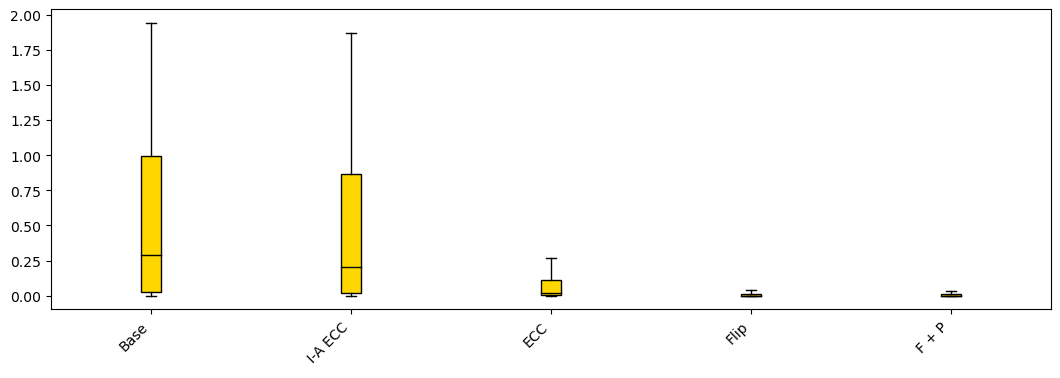

In [71]:

coloresRedes = ['gold', 'darkorange','yellow','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 3))
#fig.set_size_inches(2,2)

ax = fig.add_axes([0, 0, 1, 1])
xlabels=['Base',' I-A ECC','ECC','Flip','F + P']
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
#bplot=ax.boxplot(DenseNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'], patch_artist=True, showfliers=False)
bplot=ax.boxplot(DenseNet,showmeans = False,
                 boxprops = dict(facecolor = "gold"),
                 widths=(0.1),
                 medianprops = dict(color = "black", linewidth = 1),
                 #meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = False, showfliers=False)
ax.set_xticks(np.arange(len(xlabels))+1)
ax.set_xticklabels(xlabels, rotation=45, ha='right')

#ylabels = yticks = np.linspace(0, 20, 5)
#ax.set_yticks(yticks)
#ax.set_yticklabels(ylabels)
#bplot=plt.boxplot(data)
#outliers_ECC = bplot["fliers"][2].get_ydata()
#outliers_filp = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_ECC',len(outliers_ECC))
#print('outliers_F',len(outliers_filp))
#print('outliers_F_P',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
 
# show plot
plt.savefig('DenseNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

C:\Users\usuario\AppData\Local\Temp\ipykernel_7812\299045643.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(full_label, rotation=90, fontsize=12,fontfamily="serif")


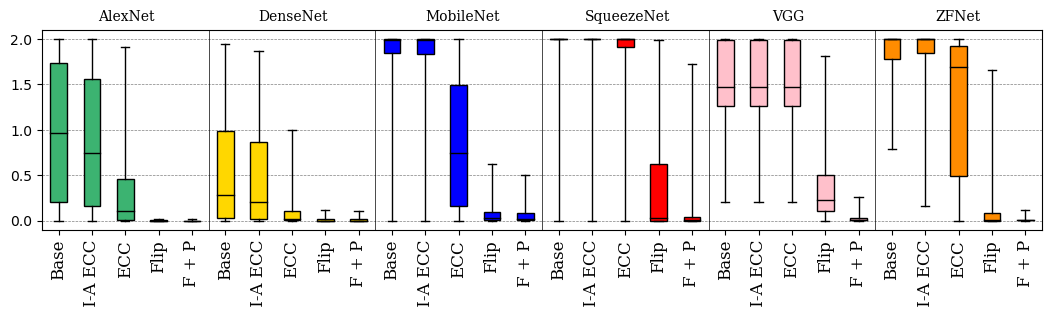

In [23]:
#data= data.set_index("df_experimentos")
import pandas as pd
AlexNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\AlexNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
DenseNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\DenseNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
MobileNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\MobileNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
SqueezeNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\SqueezeNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
ZFNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\ZFNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
VGG16 =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\VGG16_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')





fig = plt.figure()
fig.set_size_inches(10, 2)


ax = fig.add_axes([0, 0, 1, 1])


nets_width = 0.5
box_width = 0.5
experiments = 5

nets = []
nets.append(AlexNet)
nets.append(DenseNet)
nets.append(MobileNet)
nets.append(SqueezeNet)
nets.append(VGG16)
nets.append(ZFNet)


#colors = ["b", "gold", "darkorange", "r"]
colors=['mediumseagreen','gold', 'b','r','pink','darkorange']
full_label = ['Base',' I-A ECC','ECC','Flip','F + P']
empty_label = ['','','','','']
len_label=np.arange(len(full_label))
#len_abel=ax.set_xticks(np.arange(len(full_label)))
ax.set_xticklabels(full_label, rotation=90, fontsize=12,fontfamily="serif")

for i, net in enumerate(nets):
     
    
    color = colors[i]
    label = full_label if 0 == i else empty_label
    
    bplot = ax.boxplot(net,
                       labels=full_label,
                       
                       #positions=np.array(range(experiments)) * nets_width + i * box_width,
                       positions=np.array(range(experiments))+5*i,
                       showmeans = False,
                       widths=0.5,
                       boxprops = dict(facecolor = color),
                       medianprops = dict(color = "black", linewidth = 1),
                       meanprops = dict(color = "black", linewidth = 1),
                       patch_artist=True,
                       meanline = False,
                       showfliers = True,whis=5500)
    
    
plt.axvline(x=4.5, ymax= 5, color="black", linewidth=0.5)
plt.axvline(x=9.5, ymax= 5, color="black", linewidth=0.5)
plt.axvline(x=14.5, ymax= 5, color="black", linewidth=0.5)
plt.axvline(x=19.5, ymax= 5, color="black", linewidth=0.5)
plt.axvline(x=24.5, ymax= 5, color="black", linewidth=0.5)

plt.text(1.2, 2.2, 'AlexNet', fontsize=10, fontfamily="serif")
plt.text(6, 2.2, 'DenseNet', fontsize=10, fontfamily="serif")
plt.text(11, 2.2, 'MobileNet', fontsize=10, fontfamily="serif")
#plt.text(9.4, 1.05, 'ResNet', fontsize=22, fontfamily="serif")
plt.text(15.8, 2.2, 'SqueezeNet', fontsize=10, fontfamily="serif")
plt.text(21.4, 2.2, 'VGG', fontsize=10, fontfamily="serif")
plt.text(26.3, 2.2, 'ZFNet', fontsize=10, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed', linewidth=0.5)
#plt.axvline(x=29, ymax= 5, color="black")   
#plt.grid(True)    
#ax.set_xticks(np.arange(len(full_label)))

#ax.set_xticklabels(full_label, rotation=0, fontsize=8)
plt.savefig('diff_softmax_redes.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
                       

In [188]:
ZFNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\ZFNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
ZFNet

,Base,I-A ECC,ECC,Flip,F + P
0,1.999170,1.999150,1.923924,1.422451,0.017246
1,1.999170,1.999150,1.923924,1.422451,0.007024
2,1.999990,1.999862,1.856279,0.039858,0.014781
3,1.999990,1.999862,1.856279,0.039858,0.007024
4,0.995124,1.801629,1.945896,0.003835,0.032139
...,...,...,...,...,...
745,1.982675,1.982692,1.970541,0.003163,0.007024
746,1.994149,1.994181,0.602489,0.031137,0.007962
747,1.994149,1.994181,0.602489,0.031137,0.007024
748,1.998092,1.997853,1.914711,1.368589,0.056942


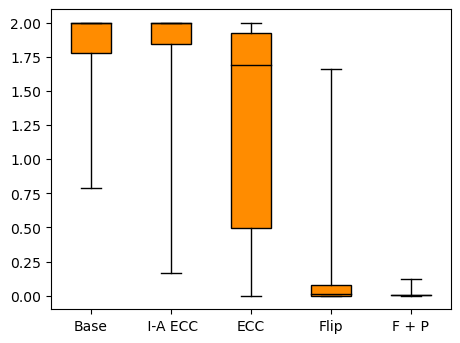

In [194]:
coloresRedes = ['gold', 'darkorange','yellow','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(4, 3)

ax = fig.add_axes([0, 0, 1, 1])
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
#bplot=ax.boxplot(ZFNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'], patch_artist=True)
bplot=ax.boxplot(ZFNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = False,
                 boxprops = dict(facecolor = "darkorange"),
                 medianprops = dict(color = "black", linewidth = 1),
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=True,whis=50)
plt.savefig('ZFNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

#bplot=plt.boxplot(data)
#outliers_base = bplot["fliers"][0].get_ydata()
#outliers_I_F = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_base',len(outliers_ECC))
#print('outliers_I_F',len(outliers_filp))
#print('outliers_F_p',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
# 

In [198]:
SqueezeNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\SqueezeNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
SqueezeNet

,Base,I-A ECC,ECC,Flip,F + P
0,2.000000,2.000000,1.999999,1.983297,0.010320
1,1.999985,1.999985,1.999985,0.005914,0.000042
2,0.073711,0.073728,1.995313,0.068703,0.039729
3,0.031660,0.031674,1.969537,0.024552,0.009110
4,2.000000,2.000000,2.000000,0.000142,0.000013
...,...,...,...,...,...
745,2.000000,2.000000,0.000458,0.007483,0.000097
746,1.999985,1.999995,1.999991,0.002827,0.000136
747,1.999508,1.999523,1.973775,0.018725,0.023983
748,1.999977,1.999992,1.990906,1.437104,0.508663


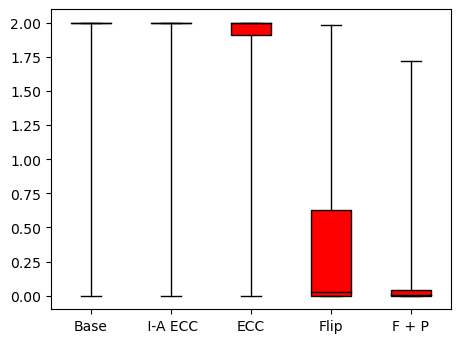

In [216]:
coloresRedes = ['gold', 'darkorange','yellow','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(4, 3)

ax = fig.add_axes([0, 0, 1, 1])
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
#bplot=ax.boxplot(ZFNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'], patch_artist=True)
bplot=ax.boxplot(SqueezeNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = False,
                 boxprops = dict(facecolor = "r"),
                 medianprops = dict(color = "black", linewidth = 1),
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=True, whis=5500)
plt.savefig('SqueezNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

#bplot=plt.boxplot(data)
#outliers_base = bplot["fliers"][0].get_ydata()
#outliers_I_F = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_base',len(outliers_ECC))
#print('outliers_I_F',len(outliers_filp))
#print('outliers_F_p',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
# 

In [180]:
VGG16 =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\VGG16_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
VGG16

,Base,I-A ECC,ECC,Flip,F + P
0,1.999764,1.999764,1.999756,1.808483,0.025908
1,1.992171,1.992171,1.992171,0.099040,0.008158
2,1.036821,1.036821,1.036821,0.303873,0.024107
3,1.362626,1.362626,1.362626,0.050959,0.001961
4,1.999705,1.999705,1.999704,0.123410,0.001749
...,...,...,...,...,...
745,1.231604,1.231604,1.231604,1.079463,0.080934
746,1.818879,1.818879,1.818879,0.239635,0.001885
747,0.820854,0.820854,0.820854,0.264132,0.032794
748,1.470904,1.470904,1.470904,0.244493,0.007544


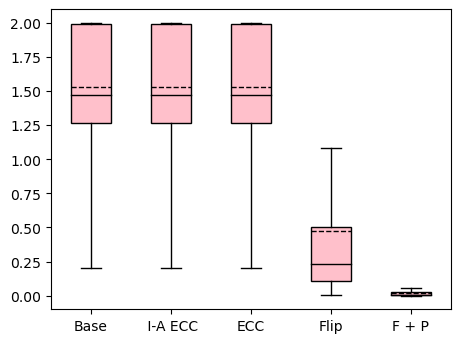

In [182]:
coloresRedes = ['gold', 'darkorange','yellow','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(4, 3)

ax = fig.add_axes([0, 0, 1, 1])
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
#bplot=ax.boxplot(ZFNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'], patch_artist=True)
bplot=ax.boxplot(VGG16,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = True,
                 boxprops = dict(facecolor = "pink"),
                 medianprops = dict(color = "black", linewidth = 1),
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=False)
plt.savefig('VGG16_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

#bplot=plt.boxplot(data)
#outliers_base = bplot["fliers"][0].get_ydata()
#outliers_I_F = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_base',len(outliers_ECC))
#print('outliers_I_F',len(outliers_filp))
#print('outliers_F_p',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])

In [16]:
import numpy as np
import matplotlib.colors as mcolors
data_1 = np.random.normal(100, 10, 200)
data_2 = np.random.normal(90, 20, 200)
data_3 = np.random.normal(80, 30, 200)
data_4 = np.random.normal(70, 40, 200)

[]
0


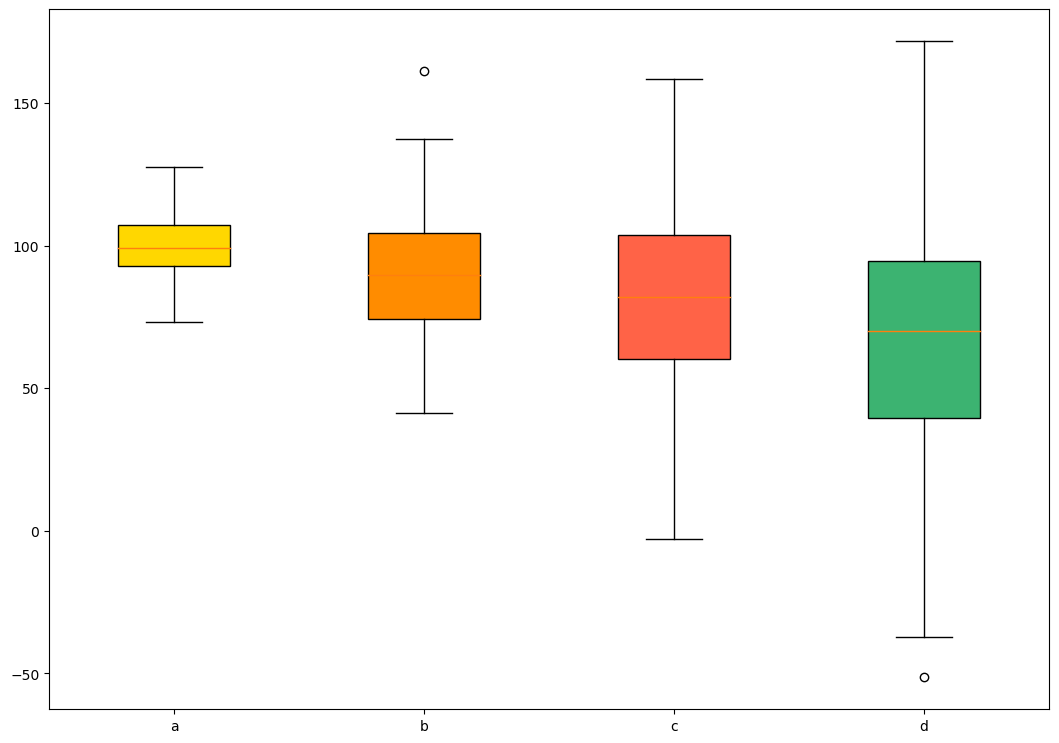

In [21]:
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
data = [data_1, data_2, data_3, data_4]
data
 
fig = plt.figure(figsize =(10, 7))
# 
## Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# 
## Creating plot
bplot=ax.boxplot(data,labels=['a','b','c','d'], patch_artist=True)

outliers = bplot["fliers"][0].get_ydata()
print((outliers))
print(len(outliers))
#bp = ax.boxplot(data)
# for
#boxes = bplot["boxes"][0].set_facecolor('b')

for idx, box in enumerate(bplot["boxes"]):
    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
    #box.set_facecolor(coloresRedes[0])

#boxes = bplot["boxes"][0]
#print(boxes)
#boxes.set_facecolor(mcolors.CSS4_COLORS['darkorange'])
## show plot
plt.show()

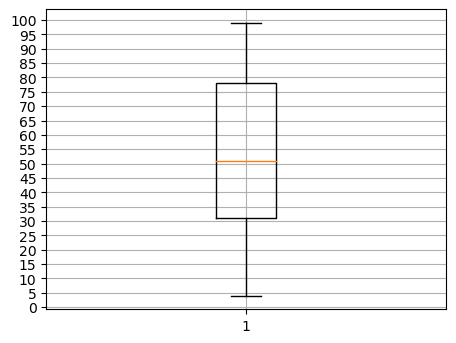

In [178]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(4, 3)

ax = fig.add_axes([0, 0, 1, 1])
 
# Creating axes instance

edades = np.array([4, 17, 29, 33, 50, 51, 61, 71, 85, 92, 99])

plt.yticks(np.arange(0, 110, 5))
plt.grid(True)
plt.boxplot(edades)
plt.show()